<a href="https://colab.research.google.com/github/zhus-dika/togyz-qumalaq-agent/blob/main/togyzqumalaq_aec_vs_random_policy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 🦛 Install need packages

In [1]:
#!python -m ipykernel install --user --name=venv

### 🐞 Imports

In [1]:
import gymnasium
import os
import numpy as np
from gymnasium.spaces import Discrete, MultiDiscrete
from gymnasium import spaces

from IPython.display import clear_output
import time
from pettingzoo import AECEnv
from pettingzoo.utils import agent_selector, wrappers
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import csv
import pandas as pd
from scipy.interpolate import interp1d

import os
from typing import Optional, Tuple

from torch.utils.tensorboard import SummaryWriter
from tianshou.utils import TensorboardLogger

import gymnasium
import numpy as np
import torch
from copy import deepcopy
from tianshou.data import Collector, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.env.pettingzoo_env import PettingZooEnv
from tianshou.policy import BasePolicy, DQNPolicy, RainbowPolicy, MultiAgentPolicyManager, RandomPolicy
from tianshou.trainer import OffpolicyTrainer
from tianshou.utils.net.common import Net

import random
import copy

NUM_ITERS = 400
PLAYS = {"bastaushy": 0, "qostaushy": 0}

### 🐯 Parameters

In [2]:
NET_ARCHS = [[512, 1024, 512]]

MAX_EPOCHS = 1000

# step_per_epoch=1000,
# step_per_collect=50,
# episode_per_test=10,

STEP_PER_EPOCH = 1000

STEP_PER_COLLECT = 100 #50

EPISODE_PER_TEST = 50 #10

BATCH_SIZE = 256

MODELS_PATH = {}

MODELS_PATH['bastaushy'] = os.path.join('..', 'models', 'dqn', 'curriculum_learning','bastaushy')

MODELS_PATH['qostaushy'] = os.path.join('..', 'models', 'dqn', 'curriculum_learning','qostaushy')

LOGS_PATH = {}

LOGS_PATH['bastaushy'] = os.path.join('..', 'logs', 'dqn', 'bastaushy')

LOGS_PATH['qostaushy'] = os.path.join('..', 'logs', 'dqn', 'qostaushy')

#  🐘 AEC environment https://pettingzoo.farama.org/api/aec/#about-aec

### 🦉 Create environment

In [29]:
def env(render_mode=None):
    """
    The env function often wraps the environment in wrappers by default.
    You can find full documentation for these methods
    elsewhere in the developer documentation.
    """
    internal_render_mode = render_mode if render_mode != "ansi" else "human"
    env = raw_env(render_mode=internal_render_mode)
    # This wrapper is only for environments which print results to the terminal
    if render_mode == "ansi":
        env = wrappers.CaptureStdoutWrapper(env)
    # this wrapper helps error handling for discrete action spaces
    env = wrappers.AssertOutOfBoundsWrapper(env)
    # Provides a wide vareity of helpful user errors
    # Strongly recommended
    env = wrappers.OrderEnforcingWrapper(env)
    return env


class raw_env(AECEnv):
    """
    The metadata holds environment constants. From gymnasium, we inherit the "render_modes",
    metadata which specifies which modes can be put into the render() method.
    At least human mode should be supported.
    The "name" metadata allows the environment to be pretty printed.
    """

    metadata = {
        "render_modes": ["ansi", "human"],
        "name": "togyzqumalaq_v0"
        }

    def __init__(self, render_mode=None):
        """
        The init method takes in environment arguments and
         should define the following attributes:
        - otaular
        - tuzdyq
        - qazandar
        - possible_agents
        - render_mode

        Note: as of v1.18.1, the action_spaces and observation_spaces attributes are deprecated.
        Spaces should be defined in the action_space() and observation_space() methods.
        If these methods are not overridden, spaces will be inferred from self.observation_spaces/action_spaces, raising a warning.

        These attributes should not be changed after initialization.
        """
        self.otaular = []
        self.tuzdyq = []
        self.qazandar = []
        self.direction = []
        self.agents = ["bastaushy", "qostaushy"]
        self.possible_agents = self.agents[:]
        # optional: we can define the observation and action spaces here as attributes to be used in their corresponding methods
        self.action_spaces = {i: spaces.Discrete(9) for i in self.agents}
        self.observation_spaces = {
            i: spaces.Dict(
                {
                    "observation": MultiDiscrete([100] * 18 + [9] * 2 + [82] * 2),
                    "action_mask": Discrete(9),
                }
            )
            for i in self.agents
        }
        self.render_mode = render_mode
        self.nsteps = 0

    # Observation space should be defined here.
    def action_space(self, agent):
        return self.action_spaces[agent]

    # Action space should be defined here.
    def observation_space(self, agent):
        return self.observation_spaces[agent]

    def render(self):
        """
        Renders the environment. In human mode, it can print to terminal, open
        up a graphical window, or open up some other display that a human can see and understand.
        """
        """Renders the environment."""
        if self.render_mode is None:
            gymnasium.logger.warn(
                "You are calling render method without specifying any render mode."
            )
            return

        if len(self.agents) == 2:
            points_bastaushy_x = np.array([i * 2 for i in range(10)])
            points_bastaushy_y = np.array([i % 5 for i in range(50)])

            x = np.arange(-3, 225, 1)
            y = -1

            text_kwargs = dict(ha='center', va='center', fontsize=12)
            plt.figure(figsize=(17, 6))

            for i in range(9):
                # qostaushy's part
                plt.scatter(np.repeat(points_bastaushy_x + 25 * i, 5)[:self.otaular[17 - i]], points_bastaushy_y[:self.otaular[17 - i]], marker='o')
                # horizontal line
                plt.plot(x, np.repeat(y, len(x)))
                # vertical lines
                plt.plot(np.repeat(25 * i - 2, len(x)), np.arange(-7, 5, 12 / len(x)))
                # bastaushy's part
                plt.scatter(np.repeat(points_bastaushy_x + 25 * i, 5)[:self.otaular[i]], points_bastaushy_y[:self.otaular[i]] - 6, marker='o')

            #last vertical line
            plt.plot(np.repeat(25 * 9 - 2, len(x)), np.arange(-7, 5, 12 / len(x)))

            for i in range(9):
                # bastaushy's qumalaqtar
                plt.text(25 * i + 10, -7, f'{i} ({self.otaular[i]})', **text_kwargs)
                # qostaushy's qumalaqtar
                plt.text(25 * i + 10, 5, f'{17 - i} ({self.otaular[17 - i]})', **text_kwargs)
            # bastaushy qazan's qumalaqtar
            plt.text(230, -4, f'qazan: {self.qazandar[0]}', **text_kwargs)
            # qostaushy qazan's qumalaqtar
            plt.text(230, 2, f'qazan: {self.qazandar[1]}', **text_kwargs);
            # bastaushy tuzdyq's qumalaqtar
            plt.text(230, -6, f'tuzdyq: {self.tuzdyq[0]}', **text_kwargs)
            # qostaushy tuzdyq's qumalaqtar
            plt.text(230, 0, f'tuzdyq: {self.tuzdyq[1]}', **text_kwargs);
            plt.show()
        else:
            if self.render_mode == "human":
                print("Game over")
        time.sleep(2)
        clear_output(True)

    def _legal_moves(self, agent):
        cur_player = self.possible_agents.index(agent)
        opp_player = (cur_player + 1) % 2
        return [item for item in range(9 * cur_player, (cur_player + 1) * 9) if self.tuzdyq[opp_player] != item and self.otaular[item] > 0]

    def observe(self, agent):
        """
        Observe should return the observation of the specified agent. This function
        should return a sane observation (though not necessarily the most up to date possible)
        at any time after reset() is called.
        """
        # observation of one agent is the previous state of the other
        legal_moves = self._legal_moves(agent) if agent == self.agent_selection else []
        action_mask = np.zeros(9, "int8")
        if self.possible_agents.index(agent) == 1:
            legal_moves = [i - 9 for i in legal_moves]
        for i in legal_moves:
            action_mask[i] = 1
        observation = tuple(
            self.otaular + self.tuzdyq + self.qazandar
        )
        return {"observation": observation, "action_mask": action_mask}

    def close(self):
        """
        Close should release any graphical displays, subprocesses, network connections
        or any other environment data which should not be kept around after the
        user is no longer using the environment.
        """
        pass

    def reset(self, seed=None, options=None):
        """
        Reset needs to initialize the following attributes
        - agents
        - rewards
        - _cumulative_rewards
        - terminations
        - truncations
        - infos
        - agent_selection
        And must set up the environment so that render(), step(), and observe()
        can be called without issues.
        Here it sets up the state dictionary which is used by step() and the observations dictionary which is used by step() and observe()
        """
        self.agents = self.possible_agents[:]
        self.rewards = {agent: 0 for agent in self.agents}
        self._cumulative_rewards = {agent: 0 for agent in self.agents}
        self.otaular = [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
        self.direction = [list(range(18)), [9, 10, 11, 12, 13, 14, 15, 16, 17, 0, 1, 2, 3, 4, 5, 6, 7, 8]]
        self.tuzdyq = [-1, -1]
        self.qazandar = [0, 0]
        self.terminations = {agent: False for agent in self.agents}
        self.truncations = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}
        self.num_moves = 0
        observation = tuple(
            self.otaular + self.tuzdyq + self.qazandar
        )
        self.observations = {agent: observation for agent in self.agents}
        """
        Our agent_selector utility allows easy cyclic stepping through the agents list.
        """
        self._agent_selector = agent_selector(self.agents)
        self.agent_selection = self._agent_selector.next()

    def step(self, action):
        """
        step(action) takes in an action for the current agent (specified by
        agent_selection) and needs to update
        - rewards
        - _cumulative_rewards (accumulating the rewards)
        - terminations
        - truncations
        - infos
        - agent_selection (to the next agent)
        And any internal state used by observe() or render()
        """
        if (
            self.terminations[self.agent_selection]
            or self.truncations[self.agent_selection]
        ):
            # handles stepping an agent which is already dead
            # accepts a None action for the one agent, and moves the agent_selection to
            # the next dead agent,  or if there are no more dead agents, to the next live agent
            self._was_dead_step(action)
            return

        cur_player = self.possible_agents.index(self.agent_selection)
        opp_player = (cur_player + 1) % 2
        self.num_moves += 1
        if self.render_mode == "human":
            print(f'MOVE #{self.num_moves}')
        # The truncations dictionary must be updated for all players.
        self.truncations = {
            agent: self.num_moves >= NUM_ITERS for agent in self.agents
        }
        # distribute qumalaqs
        if cur_player == 1:
            action += 9
        if self.render_mode == "human":
            print(f'{self.agent_selection} made action {action}')
        num_qumalaq = self.otaular[action]
        idx_action = self.direction[cur_player].index(action)
        if self.otaular[action] == 1:
            self.otaular[self.direction[cur_player][idx_action + 1]] += 1
            self.otaular[action] -= 1
        else:
            i = 1
            while self.otaular[action] > 1:
                self.otaular[self.direction[cur_player][(idx_action + i) % 18]] += 1
                self.otaular[action] -= 1
                i += 1
        # check tuzdyq & add rewards to qazandar
        reward = 0
        if self.check_tuzdyq(self.agent_selection, action):
            reward += 3
            if self.render_mode == "human":
                print(f'{self.agent_selection} won tuzdyq {reward}')
        else:

            if num_qumalaq > 1:
                last_otau = self.direction[cur_player][(idx_action + num_qumalaq - 1) % 18]
            else:
                last_otau = self.direction[cur_player][(idx_action + num_qumalaq) % 18]

            if last_otau in range(opp_player * 9, (opp_player + 1) * 9) and self.otaular[last_otau] % 2 == 0:
                reward += self.otaular[last_otau]
                if self.render_mode == "human":
                    print(f'{self.agent_selection} won {reward}')
                self.otaular[last_otau] = 0
            if self.tuzdyq[cur_player] >= 0 and self.otaular[self.tuzdyq[cur_player]] > 0:
                reward += self.otaular[self.tuzdyq[cur_player]]
                if self.render_mode == "human":
                    print(f'{self.agent_selection} won tuzdyq {self.otaular[self.tuzdyq[cur_player]]}')
                self.otaular[self.tuzdyq[cur_player]] = 0
        if self.render_mode == "human":
            print(f'{self.agent_selection} won total {reward}')
        self.qazandar[cur_player] += reward
        #=======================================================================#
        # curriculum lesson # 1
        # for i in range(cur_player * 9, 9 + cur_player * 9):
        #     if self.otaular[i] % 2 != 0:
        #         reward -= 1
        
        #=======================================================================#
        # curriculum lesson # 2
        opp_actions = self._legal_moves(self.possible_agents[opp_player])
        rew_opp = 0
        for opp_act in opp_actions:
            num_qumalaq = self.otaular[opp_act]
            idx_action = self.direction[opp_player].index(action)
            if num_qumalaq > 1:
                last_otau = self.direction[opp_player][(idx_action + num_qumalaq - 1) % 18]
            else:
                last_otau = self.direction[opp_player][(idx_action + num_qumalaq) % 18]
            if rew_opp < self.otaular[last_otau] and self.otaular[last_otau] % 2 == 1 and last_otau in range(cur_player * 9, (cur_player + 1) * 9):
                rew_opp = self.otaular[last_otau]
        self.rewards[self.agent_selection] -= rew_opp
        #=======================================================================#
        # curriculum lesson # 3
        # reduce the number of steps
        self.rewards[self.agent_selection] -= 0.5
        
        self.rewards[self.agent_selection] += reward
        # check if there is a winner
        winner = self.check_for_winner()

        #=======================================================================#
        # curriculum lesson # 4
        # increase reward for winning the game
        self.nsteps += 1

        #=======================================================================#
        # curriculum lesson # 5
        # calculate reward in other way
        # self.rewards[self.agent_selection] += (self.qazandar[cur_player] - self.qazandar[opp_player]) / 82
        # self.rewards[self.agent_selection] -= 0.05
        if winner:
            # print("NSTEPS =", self.nsteps)
            self.rewards[self.agent_selection] += 100
            # self.rewards[self.agent_selection] += 1
            self.terminations = {i: True for i in self.agents}
            if self.render_mode == "human":
                print(f'{self.agent_selection} won the game!!!')
        # selects the next agent.
        self.agent_selection = self._agent_selector.next()
        # Adds .rewards to ._cumulative_rewards
        self._accumulate_rewards()

        if self.render_mode == "human":
            self.render()

    def check_tuzdyq(self, agent, action):
        cur_player = self.possible_agents.index(agent)
        opp_player = (cur_player + 1) % 2
        idx = self.direction[cur_player].index(action)
        num_qumalaq = self.otaular[action]

        if num_qumalaq > 1:
            last_otau = self.direction[cur_player][(idx + num_qumalaq - 1) % 18]
        else:
            last_otau = self.direction[cur_player][(idx + num_qumalaq) % 18]

        if last_otau in range(opp_player * 9, (opp_player + 1) * 9) and self.otaular[last_otau] == 3 and last_otau != 17 - cur_player * 9 and abs(last_otau - self.tuzdyq[opp_player]) != 9:
            self.tuzdyq[cur_player] = last_otau
            self.otaular[last_otau] = 0
            if self.render_mode == "human":
                print(f'{agent} got tuzdyq {last_otau}!')
            return True

        return False

    def check_atsyrau(self, agent):
        cur_player = self.possible_agents.index(agent)
        opp_player = (cur_player + 1) % 2

        for idx, i in enumerate(self.otaular[cur_player * 9: (cur_player + 1) * 9]):
            if i > 0 and idx + cur_player * 9 != self.tuzdyq[opp_player]:
                return False
        if self.render_mode == "human":
            print(f'{agent} reached atsyrau')
        return True

    def check_for_winner(self):
        cur_player = self.possible_agents.index(self.agent_selection)
        opp_player = (cur_player + 1) % 2
        if self.qazandar[cur_player] > 81:
            PLAYS[self.agent_selection] += 1
            return True
        if self.check_atsyrau(self.possible_agents[opp_player]) and self.qazandar[opp_player] <= 81:
            PLAYS[self.agent_selection] += 1
            return True
        return False

### 🦚 Testing environment

In [6]:
# env = env(render_mode="human")
# env.reset(seed=42)

# for agent in env.agent_iter():
#     observation, reward, termination, truncation, info = env.last()

#     if termination or truncation:
#         action = None
#     else:
#         mask = observation["action_mask"]
#         # this is where you would insert your policy
#         action = env.action_space(agent).sample(mask)

#     env.step(action)
# env.close()

# 🐼 DQN agent to play vs a random policy agent https://pettingzoo.farama.org/tutorials/tianshou/intermediate/

### 🐫 Prepare main functions

In [4]:
def _get_agents_dqn(
    agent_learn: Optional[BasePolicy] = None,
    agent_opponent: Optional[BasePolicy] = None,
    optim: Optional[torch.optim.Optimizer] = None,
    agent_type = None,
    net_arch = [64, 128, 128, 64]
) -> Tuple[BasePolicy, torch.optim.Optimizer, list]:
    env = _get_env()
    observation_space = (
        env.observation_space["observation"]
        if isinstance(env.observation_space, gymnasium.spaces.Dict)
        else env.observation_space
    )
    if agent_learn is None:
        # model
        net = Net(
            state_shape=observation_space.shape or observation_space.n,
            action_shape=env.action_space.shape or env.action_space.n,
            hidden_sizes=net_arch,
            device="cuda" if torch.cuda.is_available() else "cpu",
        ).to("cuda" if torch.cuda.is_available() else "cpu")

        if optim is None:
            optim = torch.optim.Adam(net.parameters(), lr=1e-4)
        agent_learn = DQNPolicy(
            model=net,
            optim=optim,
            discount_factor=0.9,
            estimation_step=3,
            target_update_freq=320,
            action_space=env.action_space,
            observation_space=observation_space
        ).to("cuda" if torch.cuda.is_available() else "cpu")


    if agent_opponent is None:
        agent_opponent = RandomPolicy(action_space=env.action_space)
        
    if agent_type=="qostaushy":
        agents = [agent_opponent, agent_learn]
    else:
        agents = [agent_learn, agent_opponent]
    policy = MultiAgentPolicyManager(policies=agents, env=env)
    return policy, optim, env.agents


def _get_env(render_mode=None):
    """This function is needed to provide callables for DummyVectorEnv."""
    def env(render_mode=None):
        """
        The env function often wraps the environment in wrappers by default.
        You can find full documentation for these methods
        elsewhere in the developer documentation.
        """
        internal_render_mode = render_mode if render_mode != "ansi" else "human"
        env = raw_env(render_mode=internal_render_mode)
        # This wrapper is only for environments which print results to the terminal
        if render_mode == "ansi":
            env = wrappers.CaptureStdoutWrapper(env)
        # this wrapper helps error handling for discrete action spaces
        env = wrappers.AssertOutOfBoundsWrapper(env)
        # Provides a wide vareity of helpful user errors
        # Strongly recommended
        env = wrappers.OrderEnforcingWrapper(env)
        return env
    return PettingZooEnv(env(render_mode=render_mode))

### 🐦 Add logger (to run tensorboard type in terminal  $tensorboard --logdir logs/dqn)

In [84]:
log_path = os.path.join('..', 'logs', "dqn")
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

# 🐎 Self-play training agents

### 🦚 Methods train agent

In [5]:
def train_agent_dqn_bastaushy(index, net_arch, agent_learn=None, agent_opponent=None, path="bastaushy", seed=11):
    # Before evaluate this cell run the cell with env
    # ======== Step 1: Environment setup =========
    train_envs = DummyVectorEnv([_get_env for _ in range(100)])
    test_envs = DummyVectorEnv([_get_env for _ in range(100)])
    
    # seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    train_envs.seed(seed)
    test_envs.seed(seed)
    
    # ======== Step 2: Agent setup =========
    policy, optim, agents = _get_agents_dqn(agent_learn=agent_learn, agent_opponent=agent_opponent, agent_type=path, net_arch=net_arch)
    
    # # ======== Step 3: Collector setup =========
    train_collector = Collector(
        policy,
        train_envs,
        VectorReplayBuffer(100_000, len(train_envs)),
        exploration_noise=True,
    )
    test_collector = Collector(policy, test_envs, exploration_noise=True)
    log_path = os.path.join(LOGS_PATH[path], str(index))
    writer = SummaryWriter(log_path)
    logger = TensorboardLogger(writer)
    # policy.set_eps(1)
    
    # ======== Step 4: Callback functions setup =========
    def save_best_fn(policy):
        model_save_path = os.path.join(MODELS_PATH[path], f'policy_dqn_{arch2str(net_arch)}_{index}.pth')
        os.makedirs(MODELS_PATH[path], exist_ok=True)
        torch.save(policy.policies[agents[0]].state_dict(), model_save_path)
    
    def stop_fn(mean_rewards):
        return mean_rewards >= 55000
    
    def train_fn(epoch, env_step):
        policy.policies[agents[0]].set_eps(0.1)
    
    def test_fn(epoch, env_step):
        policy.policies[agents[0]].set_eps(0.05)
    
    def reward_metric(rews):
        return rews[:, 0]

    # ======== Step 5: Run the trainer =========
    result = OffpolicyTrainer(
        policy=policy,
        train_collector=train_collector,
        test_collector=test_collector,
        max_epoch=MAX_EPOCHS,
        step_per_epoch=STEP_PER_EPOCH,
        step_per_collect=STEP_PER_COLLECT,
        episode_per_test=EPISODE_PER_TEST,
        batch_size=BATCH_SIZE,
        train_fn=train_fn,
        test_fn=test_fn,
        stop_fn=stop_fn,
        save_best_fn=save_best_fn,
        update_per_step=0.1,
        test_in_train=False,
        reward_metric=reward_metric,
        verbose=True,
        logger=logger
    ).run()
    
    # return result, policy.policies[agents[1]]
    print(f"\n==========Result==========\n{result}")
    print("\n(the trained policy can be accessed via policy.policies[agents[0]])")
    return policy.policies[agents[0]]

In [6]:
def train_agent_dqn_qostaushy(index, net_arch, agent_learn=None, agent_opponent=None, path="qostaushy", seed=11):
    # Before evaluate this cell run the cell with env
    # ======== Step 1: Environment setup =========
    train_envs = DummyVectorEnv([_get_env for _ in range(100)])
    test_envs = DummyVectorEnv([_get_env for _ in range(100)])
    
    # seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    train_envs.seed(seed)
    test_envs.seed(seed)
    
    # ======== Step 2: Agent setup =========
    policy, optim, agents = _get_agents_dqn(agent_learn=agent_learn, agent_opponent=agent_opponent, agent_type=path, net_arch=net_arch)
    
    # # ======== Step 3: Collector setup =========
    train_collector = Collector(
        policy,
        train_envs,
        VectorReplayBuffer(100_000, len(train_envs)),
        exploration_noise=True,
    )
    test_collector = Collector(policy, test_envs, exploration_noise=True)
    log_path = os.path.join(LOGS_PATH[path], str(index))
    writer = SummaryWriter(log_path)
    logger = TensorboardLogger(writer)
    # policy.set_eps(1)
    
    # ======== Step 4: Callback functions setup =========
    def save_best_fn(policy):
        model_save_path = os.path.join(MODELS_PATH[path], f'policy_dqn_{arch2str(net_arch)}_{index}.pth')
        os.makedirs(MODELS_PATH[path], exist_ok=True)
        torch.save(policy.policies[agents[1]].state_dict(), model_save_path)
    
    def stop_fn(mean_rewards):
        return mean_rewards >= 55000
    
    def train_fn(epoch, env_step):
        policy.policies[agents[1]].set_eps(0.1)
    
    def test_fn(epoch, env_step):
        policy.policies[agents[1]].set_eps(0.05)
    
    def reward_metric(rews):
        return rews[:, 1]

    # ======== Step 5: Run the trainer =========
    result = OffpolicyTrainer(
        policy=policy,
        train_collector=train_collector,
        test_collector=test_collector,
        max_epoch=MAX_EPOCHS,
        step_per_epoch=STEP_PER_EPOCH,
        step_per_collect=STEP_PER_COLLECT,
        episode_per_test=EPISODE_PER_TEST,
        batch_size=BATCH_SIZE,
        train_fn=train_fn,
        test_fn=test_fn,
        stop_fn=stop_fn,
        save_best_fn=save_best_fn,
        update_per_step=0.1,
        test_in_train=False,
        reward_metric=reward_metric,
        verbose=True,
        logger=logger
    ).run()
    
    # return result, policy.policies[agents[1]]
    print(f"\n==========Result==========\n{result}")
    print("\n(the trained policy can be accessed via policy.policies[agents[1]])")
    return policy.policies[agents[1]]

## 🐡 Train initial agents via random policy

### 🐜 Set net architectures 

In [7]:
def arch2str(net_arch):
    out = str(net_arch[0])
    for i in net_arch[1:]:
        out += 'x' + str(i)
    return out

def str2arch(inp):
    lst = inp.split('x')
    return [int(i) for i in lst]

arch2str(NET_ARCHS[0])

'512x1024x512'

### 🦆 Training code

In [ ]:
for arch in NET_ARCHS:
    print(f"Train with initial agents for net arch={arch}")
    env = _get_env()
    net = Net(
                state_shape=(22,),
                action_shape=env.action_space.shape or env.action_space.n,
                hidden_sizes=arch,
                device="cuda" if torch.cuda.is_available() else "cpu",
            ).to("cuda" if torch.cuda.is_available() else "cpu")
    
    agent_learned = DQNPolicy(
                model=net,
                optim = torch.optim.Adam(net.parameters(), lr=1e-4),
                discount_factor=0.9,
                estimation_step=3,
                target_update_freq=320,
                action_space=env.action_space,
                observation_space=env.observation_space
            ).to("cuda" if torch.cuda.is_available() else "cpu")

    agent_trained_bastaushy = train_agent_dqn_bastaushy(index=1, net_arch=arch, agent_learn=agent_learned, path="bastaushy")
    # agent_trained_qostaushy = train_agent_dqn_qostaushy(index=1, net_arch=arch, agent_learn=agent_learned, path="qostaushy")

## 🦉 Main self-play training code

### 🐘 Load trained agents

In [37]:
agents_learned_bastaushy = {arch2str(key): [] for key in NET_ARCHS}
agents_learned_qostaushy = {arch2str(key): [] for key in NET_ARCHS}

In [38]:
for file in sorted(os.listdir(MODELS_PATH['bastaushy'])):  
    env = _get_env()
    arch = str2arch(file.split('_')[2])
    if arch in NET_ARCHS:
        print(file)
        net = Net(
                    state_shape=(22,),
                    action_shape=env.action_space.shape or env.action_space.n,
                    hidden_sizes=arch,
                    device="cuda" if torch.cuda.is_available() else "cpu",
                ).to("cuda" if torch.cuda.is_available() else "cpu")
        agent_learned = DQNPolicy(
                    model=net,
                    optim = torch.optim.Adam(net.parameters(), lr=1e-4),
                    discount_factor=0.9,
                    estimation_step=3,
                    target_update_freq=320,
                    action_space=env.action_space
                ).to("cuda" if torch.cuda.is_available() else "cpu")
        agent_learned.load_state_dict(torch.load(f"{MODELS_PATH['bastaushy']}/{file}"))
        agents_learned_bastaushy[arch2str(arch)].append(agent_learned)

policy_dqn_512x1024x512_0.pth
policy_dqn_512x1024x512_1.pth
policy_dqn_512x1024x512_2.pth
policy_dqn_512x1024x512_3.pth
policy_dqn_512x1024x512_4.pth


In [39]:
for file in sorted(os.listdir(MODELS_PATH['qostaushy'])):
    env = _get_env()
    arch = str2arch(file.split('_')[2])
    if arch in NET_ARCHS:
        print(file)
        net = Net(
                    state_shape=(22,),
                    action_shape=env.action_space.shape or env.action_space.n,
                    hidden_sizes=arch,
                    device="cuda" if torch.cuda.is_available() else "cpu",
                ).to("cuda" if torch.cuda.is_available() else "cpu")
        agent_learned = DQNPolicy(
                    model=net,
                    optim = torch.optim.Adam(net.parameters(), lr=1e-4),
                    discount_factor=0.9,
                    estimation_step=3,
                    target_update_freq=320,
                    action_space=env.action_space
                ).to("cuda" if torch.cuda.is_available() else "cpu")
        
        agent_learned.load_state_dict(torch.load(f"{MODELS_PATH['qostaushy']}/{file}"))
        agents_learned_qostaushy[arch2str(arch)].append(agent_learned)

policy_dqn_512x1024x512_0.pth
policy_dqn_512x1024x512_1.pth
policy_dqn_512x1024x512_2.pth
policy_dqn_512x1024x512_3.pth
policy_dqn_512x1024x512_4.pth


### 🐑 Self-play

In [30]:
NUM_MODELS = 5

for arch in NET_ARCHS:
    
    count = 0
    
    for i in range(NUM_MODELS, NUM_MODELS + 1):
        
            arch_name = arch2str(arch)
            
            # random select opponent
            full_opp_bastaushy = []
            for arch_loc in NET_ARCHS:
                full_opp_bastaushy += agents_learned_bastaushy[arch2str(arch_loc)] 
            agent_opp_random_bastaushy = random.choice(full_opp_bastaushy)
            idx_opp_bastaushy = full_opp_bastaushy.index(agent_opp_random_bastaushy)
            
            full_opp_qostaushy = []
            for arch_loc in NET_ARCHS:
                full_opp_qostaushy += agents_learned_qostaushy[arch2str(arch_loc)] 
            agent_opp_random_qostaushy = random.choice(full_opp_qostaushy)
            idx_opp_qostaushy = full_opp_qostaushy.index(agent_opp_random_qostaushy)
            # training
            env = _get_env()
            net = Net(
                        state_shape=(22,),
                        action_shape=env.action_space.shape or env.action_space.n,
                        hidden_sizes=arch,
                        device="cuda" if torch.cuda.is_available() else "cpu",
                    ).to("cuda" if torch.cuda.is_available() else "cpu")
            
            agent_learned_bastaushy = DQNPolicy(
                        model=net,
                        optim = torch.optim.Adam(net.parameters(), lr=1e-4),
                        discount_factor=0.9,
                        estimation_step=3,
                        target_update_freq=320,
                        action_space=env.action_space,
                        observation_space=env.observation_space
                    ).to("cuda" if torch.cuda.is_available() else "cpu")
            agent_learned_qostaushy = DQNPolicy(
                        model=net,
                        optim = torch.optim.Adam(net.parameters(), lr=1e-4),
                        discount_factor=0.9,
                        estimation_step=3,
                        target_update_freq=320,
                        action_space=env.action_space,
                        observation_space=env.observation_space
                    ).to("cuda" if torch.cuda.is_available() else "cpu")
            if count == 0:
                agent_learned_bastaushy.load_state_dict(torch.load(f"{MODELS_PATH['bastaushy']}/policy_dqn_{arch_name}_3.pth"))
                #agent_learned_qostaushy.load_state_dict(torch.load(f"{MODELS_PATH['qostaushy']}/policy_dqn_{arch_name}_{i-1}.pth"))
                count += 1
            
            net = Net(
                        state_shape=(22,),
                        action_shape=env.action_space.shape or env.action_space.n,
                        hidden_sizes=arch,
                        device="cuda" if torch.cuda.is_available() else "cpu",
                    ).to("cuda" if torch.cuda.is_available() else "cpu")
            
            agent_learned_bastaushy = DQNPolicy(
                        model=net,
                        optim = torch.optim.Adam(net.parameters(), lr=1e-4),
                        discount_factor=0.9,
                        estimation_step=3,
                        target_update_freq=320,
                        action_space=env.action_space,
                        observation_space=env.observation_space
                    ).to("cuda" if torch.cuda.is_available() else "cpu")

            print(f'Train agent bastaushy vs qostaushy #{idx_opp_qostaushy}')
        
            train_agent_dqn_bastaushy(index=i, net_arch=arch, agent_learn=agent_learned_bastaushy, agent_opponent=agent_opp_random_qostaushy, path="bastaushy")
            
            #load best bastaushy policy model
            agent_learned_bastaushy.load_state_dict(torch.load(f"{MODELS_PATH['bastaushy']}/policy_dqn_{arch_name}_{i}.pth"))
        
            #print(f'Train agent qostaushy vs bastaushy #{idx_opp_bastaushy}')
        
            #train_agent_dqn_qostaushy(index=i, net_arch=arch, agent_learn=agent_learned_qostaushy, agent_opponent=agent_opp_random_bastaushy, path="qostaushy")
            
            # load best qostaushy policy model
            #agent_learned_qostaushy.load_state_dict(torch.load(f"{MODELS_PATH['qostaushy']}/policy_dqn_{arch_name}_{i}.pth"))
            
            # add new learned agents
            
            agents_learned_bastaushy[arch_name].append(agent_learned_bastaushy)
            #agents_learned_qostaushy[arch_name].append(agent_learned_qostaushy)
            
            # rewrite new agents
            # agent_learned_bastaushy = copy.deepcopy(next_agent_learned_bastaushy)
            # agent_learned_qostaushy = copy.deepcopy(next_agent_learned_qostaushy)

Train agent bastaushy vs qostaushy #4


Epoch #1: 1001it [00:02, 336.08it/s, env_step=1000, gradient_step=100, len=0, n/ep=0, n/st=100, rew=0.00]                                                                                         


Epoch #1: test_reward: -33436.540000 ± 25122.549399, best_reward: -33436.540000 ± 25122.549399 in #1


Epoch #2: 1001it [00:02, 388.70it/s, env_step=2000, gradient_step=200, len=0, n/ep=0, n/st=100, rew=0.00]                                                                                         


Epoch #2: test_reward: -94943.990000 ± 64706.865291, best_reward: -33436.540000 ± 25122.549399 in #1


Epoch #3: 1001it [00:02, 429.06it/s, env_step=3000, gradient_step=300, len=0, n/ep=0, n/st=100, rew=0.00]                                                                                         


Epoch #3: test_reward: -150285.240000 ± 99589.577476, best_reward: -33436.540000 ± 25122.549399 in #1


Epoch #4: 1001it [00:03, 327.63it/s, env_step=4000, gradient_step=400, len=32, n/ep=0, n/st=100, rew=287.50]                                                                                      


Epoch #4: test_reward: -94092.940000 ± 57143.080416, best_reward: -33436.540000 ± 25122.549399 in #1


Epoch #5: 1001it [00:02, 355.15it/s, env_step=5000, gradient_step=500, len=46, n/ep=0, n/st=100, rew=-781.25]                                                                                     


Epoch #5: test_reward: -28878.820000 ± 15514.736592, best_reward: -28878.820000 ± 15514.736592 in #5


Epoch #6: 1001it [00:02, 472.63it/s, env_step=6000, gradient_step=600, len=58, n/ep=0, n/st=100, rew=-1382.75]                                                                                    


Epoch #6: test_reward: -79836.300000 ± 55845.340084, best_reward: -28878.820000 ± 15514.736592 in #5


Epoch #7: 1001it [00:02, 429.11it/s, env_step=7000, gradient_step=700, len=70, n/ep=3, n/st=100, rew=-1828.58]                                                                                    


Epoch #7: test_reward: -47187.400000 ± 46339.874481, best_reward: -28878.820000 ± 15514.736592 in #5


Epoch #8: 1001it [00:02, 433.82it/s, env_step=8000, gradient_step=800, len=80, n/ep=4, n/st=100, rew=-3521.62]                                                                                    


Epoch #8: test_reward: -59659.460000 ± 34509.289019, best_reward: -28878.820000 ± 15514.736592 in #5


Epoch #9: 1001it [00:02, 427.50it/s, env_step=9000, gradient_step=900, len=90, n/ep=1, n/st=100, rew=-3784.25]                                                                                    


Epoch #9: test_reward: -44333.380000 ± 32315.772762, best_reward: -28878.820000 ± 15514.736592 in #5


Epoch #10: 1001it [00:02, 415.85it/s, env_step=10000, gradient_step=1000, len=100, n/ep=2, n/st=100, rew=-5323.00]                                                                                


Epoch #10: test_reward: -37036.550000 ± 15682.939939, best_reward: -28878.820000 ± 15514.736592 in #5


Epoch #11: 1001it [00:02, 337.26it/s, env_step=11000, gradient_step=1100, len=110, n/ep=1, n/st=100, rew=-7644.25]                                                                                


Epoch #11: test_reward: -6199.860000 ± 17001.890095, best_reward: -6199.860000 ± 17001.890095 in #11


Epoch #12: 1001it [00:02, 418.92it/s, env_step=12000, gradient_step=1200, len=120, n/ep=1, n/st=100, rew=-8637.00]                                                                                


Epoch #12: test_reward: -4429.230000 ± 7939.440286, best_reward: -4429.230000 ± 7939.440286 in #12


Epoch #13: 1001it [00:02, 355.99it/s, env_step=13000, gradient_step=1300, len=130, n/ep=1, n/st=100, rew=-5894.25]                                                                                


Epoch #13: test_reward: -8114.960000 ± 10624.808478, best_reward: -4429.230000 ± 7939.440286 in #12


Epoch #14: 1001it [00:02, 339.50it/s, env_step=14000, gradient_step=1400, len=101, n/ep=2, n/st=100, rew=-11393.38]                                                                               


Epoch #14: test_reward: -20184.740000 ± 18900.719991, best_reward: -4429.230000 ± 7939.440286 in #12


Epoch #15: 1001it [00:02, 413.26it/s, env_step=15000, gradient_step=1500, len=66, n/ep=0, n/st=100, rew=-3466.00]                                                                                 


Epoch #15: test_reward: -14606.580000 ± 18332.764503, best_reward: -4429.230000 ± 7939.440286 in #12


Epoch #16: 1001it [00:02, 363.56it/s, env_step=16000, gradient_step=1600, len=81, n/ep=2, n/st=100, rew=-4228.38]                                                                                 


Epoch #16: test_reward: -13047.500000 ± 12758.769845, best_reward: -4429.230000 ± 7939.440286 in #12


Epoch #17: 1001it [00:02, 389.88it/s, env_step=17000, gradient_step=1700, len=81, n/ep=3, n/st=100, rew=-5367.33]                                                                                 


Epoch #17: test_reward: -35718.160000 ± 22685.287927, best_reward: -4429.230000 ± 7939.440286 in #12


Epoch #18: 1001it [00:02, 393.07it/s, env_step=18000, gradient_step=1800, len=93, n/ep=1, n/st=100, rew=-10709.75]                                                                                


Epoch #18: test_reward: -23827.160000 ± 15882.044395, best_reward: -4429.230000 ± 7939.440286 in #12


Epoch #19: 1001it [00:02, 399.89it/s, env_step=19000, gradient_step=1900, len=74, n/ep=1, n/st=100, rew=-1499.25]                                                                                 


Epoch #19: test_reward: -96327.720000 ± 83424.115982, best_reward: -4429.230000 ± 7939.440286 in #12


Epoch #20: 1001it [00:02, 383.86it/s, env_step=20000, gradient_step=2000, len=97, n/ep=0, n/st=100, rew=-11221.25]                                                                                


Epoch #20: test_reward: -6527.550000 ± 6532.482885, best_reward: -4429.230000 ± 7939.440286 in #12


Epoch #21: 1001it [00:02, 338.48it/s, env_step=21000, gradient_step=2100, len=141, n/ep=0, n/st=100, rew=-9497.75]                                                                                


Epoch #21: test_reward: -11936.250000 ± 17378.595636, best_reward: -4429.230000 ± 7939.440286 in #12


Epoch #22: 1001it [00:02, 349.13it/s, env_step=22000, gradient_step=2200, len=217, n/ep=0, n/st=100, rew=-37130.25]                                                                               


Epoch #22: test_reward: -18978.720000 ± 10667.445263, best_reward: -4429.230000 ± 7939.440286 in #12


Epoch #23: 1001it [00:02, 349.39it/s, env_step=23000, gradient_step=2300, len=87, n/ep=0, n/st=100, rew=-4666.88]                                                                                 


Epoch #23: test_reward: -25264.660000 ± 28691.941533, best_reward: -4429.230000 ± 7939.440286 in #12


Epoch #24: 1001it [00:02, 391.64it/s, env_step=24000, gradient_step=2400, len=70, n/ep=1, n/st=100, rew=-3608.75]                                                                                 


Epoch #24: test_reward: -59185.380000 ± 39286.300164, best_reward: -4429.230000 ± 7939.440286 in #12


Epoch #25: 1001it [00:02, 373.86it/s, env_step=25000, gradient_step=2500, len=162, n/ep=0, n/st=100, rew=-23781.25]                                                                               


Epoch #25: test_reward: -31989.210000 ± 45129.944177, best_reward: -4429.230000 ± 7939.440286 in #12


Epoch #26: 1001it [00:02, 340.02it/s, env_step=26000, gradient_step=2600, len=158, n/ep=1, n/st=100, rew=-16386.25]                                                                               


Epoch #26: test_reward: -68629.480000 ± 67517.419468, best_reward: -4429.230000 ± 7939.440286 in #12


Epoch #27: 1001it [00:02, 336.81it/s, env_step=27000, gradient_step=2700, len=106, n/ep=0, n/st=100, rew=-7548.75]                                                                                


Epoch #27: test_reward: -3030.600000 ± 6847.151954, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #28: 1001it [00:02, 363.66it/s, env_step=28000, gradient_step=2800, len=129, n/ep=2, n/st=100, rew=-13176.88]                                                                               


Epoch #28: test_reward: -28544.880000 ± 19397.953597, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #29: 1001it [00:02, 381.73it/s, env_step=29000, gradient_step=2900, len=89, n/ep=2, n/st=100, rew=-5232.12]                                                                                 


Epoch #29: test_reward: -40346.600000 ± 54912.249815, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #30: 1001it [00:02, 379.51it/s, env_step=30000, gradient_step=3000, len=125, n/ep=2, n/st=100, rew=-11717.38]                                                                               


Epoch #30: test_reward: -30856.310000 ± 35263.285359, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #31: 1001it [00:03, 321.98it/s, env_step=31000, gradient_step=3100, len=136, n/ep=0, n/st=100, rew=-7788.62]                                                                                


Epoch #31: test_reward: -28817.410000 ± 19349.537599, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #32: 1001it [00:02, 383.16it/s, env_step=32000, gradient_step=3200, len=130, n/ep=1, n/st=100, rew=-9768.75]                                                                                


Epoch #32: test_reward: -29511.070000 ± 37524.246956, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #33: 1001it [00:02, 375.24it/s, env_step=33000, gradient_step=3300, len=123, n/ep=2, n/st=100, rew=-10192.62]                                                                               


Epoch #33: test_reward: -7841.920000 ± 9416.638695, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #34: 1001it [00:03, 327.65it/s, env_step=34000, gradient_step=3400, len=94, n/ep=1, n/st=100, rew=-7300.25]                                                                                 


Epoch #34: test_reward: -23704.580000 ± 13148.343225, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #35: 1001it [00:03, 325.69it/s, env_step=35000, gradient_step=3500, len=104, n/ep=1, n/st=100, rew=-8197.50]                                                                                


Epoch #35: test_reward: -26390.360000 ± 17760.720371, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #36: 1001it [00:02, 337.96it/s, env_step=36000, gradient_step=3600, len=186, n/ep=0, n/st=100, rew=-21217.25]                                                                               


Epoch #36: test_reward: -16284.480000 ± 22116.135338, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #37: 1001it [00:02, 376.76it/s, env_step=37000, gradient_step=3700, len=93, n/ep=0, n/st=100, rew=-925.25]                                                                                  


Epoch #37: test_reward: -6098.080000 ± 5222.135892, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #38: 1001it [00:02, 341.00it/s, env_step=38000, gradient_step=3800, len=56, n/ep=1, n/st=100, rew=-2488.50]                                                                                 


Epoch #38: test_reward: -17497.280000 ± 10389.153983, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #39: 1001it [00:02, 362.37it/s, env_step=39000, gradient_step=3900, len=137, n/ep=0, n/st=100, rew=-4203.75]                                                                                


Epoch #39: test_reward: -18829.110000 ± 10334.872988, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #40: 1001it [00:02, 386.04it/s, env_step=40000, gradient_step=4000, len=130, n/ep=2, n/st=100, rew=-15023.50]                                                                               


Epoch #40: test_reward: -18948.270000 ± 15896.145325, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #41: 1001it [00:02, 394.70it/s, env_step=41000, gradient_step=4100, len=272, n/ep=1, n/st=100, rew=-39478.50]                                                                               


Epoch #41: test_reward: -26052.770000 ± 13708.532683, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #42: 1001it [00:02, 346.91it/s, env_step=42000, gradient_step=4200, len=111, n/ep=0, n/st=100, rew=-18396.25]                                                                               


Epoch #42: test_reward: -13292.930000 ± 20161.334891, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #43: 1001it [00:03, 328.04it/s, env_step=43000, gradient_step=4300, len=78, n/ep=1, n/st=100, rew=-7630.25]                                                                                 


Epoch #43: test_reward: -4644.980000 ± 6520.672267, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #44: 1001it [00:02, 376.14it/s, env_step=44000, gradient_step=4400, len=94, n/ep=0, n/st=100, rew=-6177.75]                                                                                 


Epoch #44: test_reward: -19340.430000 ± 16485.171576, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #45: 1001it [00:02, 353.72it/s, env_step=45000, gradient_step=4500, len=101, n/ep=0, n/st=100, rew=-5664.12]                                                                                


Epoch #45: test_reward: -5648.980000 ± 6345.656053, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #46: 1001it [00:02, 334.61it/s, env_step=46000, gradient_step=4600, len=78, n/ep=0, n/st=100, rew=-4198.25]                                                                                 


Epoch #46: test_reward: -12693.260000 ± 11638.807796, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #47: 1001it [00:02, 369.02it/s, env_step=47000, gradient_step=4700, len=128, n/ep=2, n/st=100, rew=-18988.50]                                                                               


Epoch #47: test_reward: -29077.200000 ± 20205.814001, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #48: 1001it [00:02, 340.19it/s, env_step=48000, gradient_step=4800, len=199, n/ep=0, n/st=100, rew=-28108.08]                                                                               


Epoch #48: test_reward: -15163.070000 ± 12827.458538, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #49: 1001it [00:03, 330.08it/s, env_step=49000, gradient_step=4900, len=107, n/ep=1, n/st=100, rew=-3657.50]                                                                                


Epoch #49: test_reward: -8328.550000 ± 8167.328066, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #50: 1001it [00:02, 412.38it/s, env_step=50000, gradient_step=5000, len=136, n/ep=1, n/st=100, rew=-15058.00]                                                                               


Epoch #50: test_reward: -3961.960000 ± 7940.085435, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #51: 1001it [00:02, 355.29it/s, env_step=51000, gradient_step=5100, len=131, n/ep=2, n/st=100, rew=-12311.00]                                                                               


Epoch #51: test_reward: -7802.720000 ± 3893.780467, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #52: 1001it [00:02, 416.39it/s, env_step=52000, gradient_step=5200, len=96, n/ep=1, n/st=100, rew=-1361.00]                                                                                 


Epoch #52: test_reward: -13405.970000 ± 11053.118504, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #53: 1001it [00:02, 351.54it/s, env_step=53000, gradient_step=5300, len=48, n/ep=1, n/st=100, rew=-745.00]                                                                                  


Epoch #53: test_reward: -22007.060000 ± 14017.858503, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #54: 1001it [00:02, 406.69it/s, env_step=54000, gradient_step=5400, len=144, n/ep=0, n/st=100, rew=-18688.50]                                                                               


Epoch #54: test_reward: -11093.830000 ± 7449.445231, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #55: 1001it [00:02, 353.85it/s, env_step=55000, gradient_step=5500, len=172, n/ep=1, n/st=100, rew=-12301.50]                                                                               


Epoch #55: test_reward: -14494.560000 ± 17796.469622, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #56: 1001it [00:02, 393.67it/s, env_step=56000, gradient_step=5600, len=181, n/ep=0, n/st=100, rew=-12277.75]                                                                               


Epoch #56: test_reward: -6774.380000 ± 10132.845711, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #57: 1001it [00:02, 359.10it/s, env_step=57000, gradient_step=5700, len=107, n/ep=3, n/st=100, rew=-12647.25]                                                                               


Epoch #57: test_reward: -18598.890000 ± 12817.816144, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #58: 1001it [00:02, 378.56it/s, env_step=58000, gradient_step=5800, len=99, n/ep=0, n/st=100, rew=-9148.38]                                                                                 


Epoch #58: test_reward: -22147.640000 ± 11905.646357, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #59: 1001it [00:03, 292.58it/s, env_step=59000, gradient_step=5900, len=71, n/ep=2, n/st=100, rew=-2584.25]                                                                                 


Epoch #59: test_reward: -10866.870000 ± 13829.498245, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #60: 1001it [00:02, 341.87it/s, env_step=60000, gradient_step=6000, len=164, n/ep=0, n/st=100, rew=-22217.92]                                                                               


Epoch #60: test_reward: -10098.670000 ± 6953.534603, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #61: 1001it [00:02, 349.27it/s, env_step=61000, gradient_step=6100, len=173, n/ep=0, n/st=100, rew=-14169.75]                                                                               


Epoch #61: test_reward: -14611.110000 ± 13506.293189, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #62: 1001it [00:02, 364.72it/s, env_step=62000, gradient_step=6200, len=164, n/ep=0, n/st=100, rew=-13626.50]                                                                               


Epoch #62: test_reward: -10902.690000 ± 7236.170489, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #63: 1001it [00:02, 350.60it/s, env_step=63000, gradient_step=6300, len=72, n/ep=1, n/st=100, rew=-617.50]                                                                                  


Epoch #63: test_reward: -9792.000000 ± 9672.103549, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #64: 1001it [00:02, 363.84it/s, env_step=64000, gradient_step=6400, len=83, n/ep=1, n/st=100, rew=-8129.00]                                                                                 


Epoch #64: test_reward: -7763.200000 ± 8190.685102, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #65: 1001it [00:02, 392.53it/s, env_step=65000, gradient_step=6500, len=52, n/ep=1, n/st=100, rew=-1046.00]                                                                                 


Epoch #65: test_reward: -14747.590000 ± 10089.884679, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #66: 1001it [00:03, 325.71it/s, env_step=66000, gradient_step=6600, len=168, n/ep=1, n/st=100, rew=-17074.50]                                                                               


Epoch #66: test_reward: -10110.580000 ± 11820.695922, best_reward: -3030.600000 ± 6847.151954 in #27


Epoch #67: 1001it [00:03, 329.27it/s, env_step=67000, gradient_step=6700, len=114, n/ep=0, n/st=100, rew=-10577.25]                                                                               


Epoch #67: test_reward: -1814.600000 ± 4380.872826, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #68: 1001it [00:02, 352.20it/s, env_step=68000, gradient_step=6800, len=89, n/ep=2, n/st=100, rew=-10459.12]                                                                                


Epoch #68: test_reward: -6989.300000 ± 6158.203184, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #69: 1001it [00:02, 379.57it/s, env_step=69000, gradient_step=6900, len=110, n/ep=0, n/st=100, rew=-7637.75]                                                                                


Epoch #69: test_reward: -10091.280000 ± 8020.646066, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #70: 1001it [00:03, 323.66it/s, env_step=70000, gradient_step=7000, len=107, n/ep=0, n/st=100, rew=-8343.00]                                                                                


Epoch #70: test_reward: -8789.880000 ± 6908.286989, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #71: 1001it [00:03, 323.23it/s, env_step=71000, gradient_step=7100, len=54, n/ep=1, n/st=100, rew=-1941.75]                                                                                 


Epoch #71: test_reward: -18382.440000 ± 10456.041850, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #72: 1001it [00:02, 378.57it/s, env_step=72000, gradient_step=7200, len=87, n/ep=0, n/st=100, rew=-7149.00]                                                                                 


Epoch #72: test_reward: -9516.950000 ± 4350.967748, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #73: 1001it [00:03, 310.36it/s, env_step=73000, gradient_step=7300, len=174, n/ep=0, n/st=100, rew=-20061.67]                                                                               


Epoch #73: test_reward: -2817.000000 ± 6693.231154, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #74: 1001it [00:02, 380.89it/s, env_step=74000, gradient_step=7400, len=26, n/ep=1, n/st=100, rew=35.25]                                                                                    


Epoch #74: test_reward: -8610.650000 ± 7763.017229, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #75: 1001it [00:02, 365.02it/s, env_step=75000, gradient_step=7500, len=48, n/ep=1, n/st=100, rew=-378.00]                                                                                  


Epoch #75: test_reward: -4102.400000 ± 4248.064590, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #76: 1001it [00:03, 315.28it/s, env_step=76000, gradient_step=7600, len=79, n/ep=0, n/st=100, rew=-6429.50]                                                                                 


Epoch #76: test_reward: -12356.450000 ± 13661.661558, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #77: 1001it [00:02, 353.26it/s, env_step=77000, gradient_step=7700, len=90, n/ep=1, n/st=100, rew=-7242.25]                                                                                 


Epoch #77: test_reward: -7575.460000 ± 8939.248427, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #78: 1001it [00:02, 403.03it/s, env_step=78000, gradient_step=7800, len=94, n/ep=0, n/st=100, rew=-7619.25]                                                                                 


Epoch #78: test_reward: -21731.590000 ± 15558.792598, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #79: 1001it [00:02, 355.87it/s, env_step=79000, gradient_step=7900, len=125, n/ep=0, n/st=100, rew=-11516.25]                                                                               


Epoch #79: test_reward: -4363.870000 ± 6513.633573, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #80: 1001it [00:02, 382.99it/s, env_step=80000, gradient_step=8000, len=120, n/ep=0, n/st=100, rew=-8419.50]                                                                                


Epoch #80: test_reward: -3422.860000 ± 8402.248878, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #81: 1001it [00:03, 328.85it/s, env_step=81000, gradient_step=8100, len=130, n/ep=0, n/st=100, rew=-9142.75]                                                                                


Epoch #81: test_reward: -3388.580000 ± 7434.534119, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #82: 1001it [00:02, 372.61it/s, env_step=82000, gradient_step=8200, len=135, n/ep=2, n/st=100, rew=-11362.00]                                                                               


Epoch #82: test_reward: -4772.930000 ± 13076.840225, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #83: 1001it [00:02, 343.76it/s, env_step=83000, gradient_step=8300, len=52, n/ep=1, n/st=100, rew=-3957.00]                                                                                 


Epoch #83: test_reward: -3941.450000 ± 6649.557276, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #84: 1001it [00:03, 318.27it/s, env_step=84000, gradient_step=8400, len=147, n/ep=3, n/st=100, rew=-19393.42]                                                                               


Epoch #84: test_reward: -16600.710000 ± 12119.936663, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #85: 1001it [00:02, 388.79it/s, env_step=85000, gradient_step=8500, len=129, n/ep=2, n/st=100, rew=-8883.50]                                                                                


Epoch #85: test_reward: -10826.950000 ± 9041.100154, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #86: 1001it [00:02, 403.45it/s, env_step=86000, gradient_step=8600, len=104, n/ep=0, n/st=100, rew=-5248.00]                                                                                


Epoch #86: test_reward: -17131.470000 ± 12873.555567, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #87: 1001it [00:03, 321.88it/s, env_step=87000, gradient_step=8700, len=50, n/ep=1, n/st=100, rew=-1906.25]                                                                                 


Epoch #87: test_reward: -9822.900000 ± 9439.863904, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #88: 1001it [00:02, 346.89it/s, env_step=88000, gradient_step=8800, len=102, n/ep=0, n/st=100, rew=-11318.75]                                                                               


Epoch #88: test_reward: -40482.980000 ± 26490.411730, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #89: 1001it [00:02, 407.85it/s, env_step=89000, gradient_step=8900, len=84, n/ep=1, n/st=100, rew=-4255.50]                                                                                 


Epoch #89: test_reward: -36138.200000 ± 23861.458252, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #90: 1001it [00:02, 359.76it/s, env_step=90000, gradient_step=9000, len=79, n/ep=0, n/st=100, rew=-4139.88]                                                                                 


Epoch #90: test_reward: -13048.620000 ± 10761.277790, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #91: 1001it [00:02, 355.99it/s, env_step=91000, gradient_step=9100, len=182, n/ep=1, n/st=100, rew=-15922.75]                                                                               


Epoch #91: test_reward: -1888.100000 ± 5671.140588, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #92: 1001it [00:03, 310.05it/s, env_step=92000, gradient_step=9200, len=74, n/ep=1, n/st=100, rew=-3459.25]                                                                                 


Epoch #92: test_reward: -27852.590000 ± 21645.514895, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #93: 1001it [00:03, 307.89it/s, env_step=93000, gradient_step=9300, len=90, n/ep=2, n/st=100, rew=-8265.25]                                                                                 


Epoch #93: test_reward: -2456.160000 ± 6733.438071, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #94: 1001it [00:03, 328.64it/s, env_step=94000, gradient_step=9400, len=38, n/ep=1, n/st=100, rew=383.25]                                                                                   


Epoch #94: test_reward: -20017.460000 ± 12768.486063, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #95: 1001it [00:02, 400.83it/s, env_step=95000, gradient_step=9500, len=74, n/ep=1, n/st=100, rew=-5149.25]                                                                                 


Epoch #95: test_reward: -5189.500000 ± 5282.139458, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #96: 1001it [00:02, 370.91it/s, env_step=96000, gradient_step=9600, len=62, n/ep=1, n/st=100, rew=-3260.75]                                                                                 


Epoch #96: test_reward: -3567.270000 ± 5781.559280, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #97: 1001it [00:02, 354.29it/s, env_step=97000, gradient_step=9700, len=98, n/ep=3, n/st=100, rew=-7359.83]                                                                                 


Epoch #97: test_reward: -1896.160000 ± 3740.507652, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #98: 1001it [00:02, 385.57it/s, env_step=98000, gradient_step=9800, len=98, n/ep=0, n/st=100, rew=-9275.00]                                                                                 


Epoch #98: test_reward: -20634.290000 ± 11594.754256, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #99: 1001it [00:02, 363.82it/s, env_step=99000, gradient_step=9900, len=70, n/ep=1, n/st=100, rew=-3793.25]                                                                                 


Epoch #99: test_reward: -6705.640000 ± 4304.151641, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #100: 1001it [00:02, 394.83it/s, env_step=100000, gradient_step=10000, len=118, n/ep=1, n/st=100, rew=-11765.75]                                                                            


Epoch #100: test_reward: -4084.360000 ± 6553.274854, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #101: 1001it [00:02, 376.19it/s, env_step=101000, gradient_step=10100, len=138, n/ep=2, n/st=100, rew=-20273.75]                                                                            


Epoch #101: test_reward: -2261.750000 ± 4441.694983, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #102: 1001it [00:02, 382.66it/s, env_step=102000, gradient_step=10200, len=206, n/ep=1, n/st=100, rew=-24676.75]                                                                            


Epoch #102: test_reward: -3587.940000 ± 5142.643909, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #103: 1001it [00:02, 337.40it/s, env_step=103000, gradient_step=10300, len=95, n/ep=2, n/st=100, rew=-3809.00]                                                                              


Epoch #103: test_reward: -2947.960000 ± 2700.071717, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #104: 1001it [00:02, 368.35it/s, env_step=104000, gradient_step=10400, len=38, n/ep=1, n/st=100, rew=652.75]                                                                                


Epoch #104: test_reward: -3775.480000 ± 3007.834199, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #105: 1001it [00:02, 405.72it/s, env_step=105000, gradient_step=10500, len=142, n/ep=3, n/st=100, rew=-12488.83]                                                                            


Epoch #105: test_reward: -6843.000000 ± 9004.981368, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #106: 1001it [00:02, 343.27it/s, env_step=106000, gradient_step=10600, len=112, n/ep=2, n/st=100, rew=-15271.62]                                                                            


Epoch #106: test_reward: -4012.940000 ± 3447.219137, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #107: 1001it [00:02, 347.40it/s, env_step=107000, gradient_step=10700, len=51, n/ep=2, n/st=100, rew=-1906.88]                                                                              


Epoch #107: test_reward: -2812.850000 ± 5004.550789, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #108: 1001it [00:02, 400.10it/s, env_step=108000, gradient_step=10800, len=90, n/ep=1, n/st=100, rew=-7449.25]                                                                              


Epoch #108: test_reward: -10819.440000 ± 7033.289675, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #109: 1001it [00:02, 385.14it/s, env_step=109000, gradient_step=10900, len=60, n/ep=1, n/st=100, rew=-1319.00]                                                                              


Epoch #109: test_reward: -14899.820000 ± 9410.213786, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #110: 1001it [00:02, 404.49it/s, env_step=110000, gradient_step=11000, len=120, n/ep=4, n/st=100, rew=-8508.75]                                                                             


Epoch #110: test_reward: -2081.940000 ± 2998.719276, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #111: 1001it [00:02, 398.00it/s, env_step=111000, gradient_step=11100, len=152, n/ep=1, n/st=100, rew=-14834.50]                                                                            


Epoch #111: test_reward: -2505.900000 ± 4130.741402, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #112: 1001it [00:02, 346.52it/s, env_step=112000, gradient_step=11200, len=56, n/ep=0, n/st=100, rew=-2616.00]                                                                              


Epoch #112: test_reward: -14015.840000 ± 10217.858931, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #113: 1001it [00:02, 411.35it/s, env_step=113000, gradient_step=11300, len=64, n/ep=0, n/st=100, rew=-1918.00]                                                                              


Epoch #113: test_reward: -4498.280000 ± 4186.882583, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #114: 1001it [00:02, 349.86it/s, env_step=114000, gradient_step=11400, len=106, n/ep=0, n/st=100, rew=-4216.75]                                                                             


Epoch #114: test_reward: -15774.890000 ± 13399.626133, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #115: 1001it [00:02, 360.51it/s, env_step=115000, gradient_step=11500, len=136, n/ep=0, n/st=100, rew=-16406.00]                                                                            


Epoch #115: test_reward: -11946.980000 ± 8613.161052, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #116: 1001it [00:02, 375.01it/s, env_step=116000, gradient_step=11600, len=102, n/ep=0, n/st=100, rew=-12106.25]                                                                            


Epoch #116: test_reward: -9114.640000 ± 12523.193171, best_reward: -1814.600000 ± 4380.872826 in #67


Epoch #117: 1001it [00:02, 373.92it/s, env_step=117000, gradient_step=11700, len=90, n/ep=1, n/st=100, rew=-8746.75]                                                                              


Epoch #117: test_reward: -833.390000 ± 1382.353491, best_reward: -833.390000 ± 1382.353491 in #117


Epoch #118: 1001it [00:02, 408.45it/s, env_step=118000, gradient_step=11800, len=108, n/ep=0, n/st=100, rew=-7103.00]                                                                             


Epoch #118: test_reward: -5329.400000 ± 6015.260337, best_reward: -833.390000 ± 1382.353491 in #117


Epoch #119: 1001it [00:02, 382.43it/s, env_step=119000, gradient_step=11900, len=68, n/ep=1, n/st=100, rew=-5288.50]                                                                              


Epoch #119: test_reward: -18131.850000 ± 12825.074748, best_reward: -833.390000 ± 1382.353491 in #117


Epoch #120: 1001it [00:02, 389.20it/s, env_step=120000, gradient_step=12000, len=57, n/ep=0, n/st=100, rew=-1289.17]                                                                              


Epoch #120: test_reward: -10334.610000 ± 10108.187688, best_reward: -833.390000 ± 1382.353491 in #117


Epoch #121: 1001it [00:02, 336.70it/s, env_step=121000, gradient_step=12100, len=103, n/ep=3, n/st=100, rew=-6975.17]                                                                             


Epoch #121: test_reward: -13086.740000 ± 10416.832265, best_reward: -833.390000 ± 1382.353491 in #117


Epoch #122: 1001it [00:02, 372.18it/s, env_step=122000, gradient_step=12200, len=104, n/ep=0, n/st=100, rew=-3508.00]                                                                             


Epoch #122: test_reward: -11401.580000 ± 5492.611809, best_reward: -833.390000 ± 1382.353491 in #117


Epoch #123: 1001it [00:02, 365.14it/s, env_step=123000, gradient_step=12300, len=163, n/ep=0, n/st=100, rew=-17117.00]                                                                            


Epoch #123: test_reward: -10042.410000 ± 5339.332072, best_reward: -833.390000 ± 1382.353491 in #117


Epoch #124: 1001it [00:02, 358.53it/s, env_step=124000, gradient_step=12400, len=168, n/ep=1, n/st=100, rew=-12305.00]                                                                            


Epoch #124: test_reward: -21025.070000 ± 11927.390166, best_reward: -833.390000 ± 1382.353491 in #117


Epoch #125: 1001it [00:03, 323.28it/s, env_step=125000, gradient_step=12500, len=73, n/ep=0, n/st=100, rew=-4504.67]                                                                              


Epoch #125: test_reward: -2539.620000 ± 7035.924655, best_reward: -833.390000 ± 1382.353491 in #117


Epoch #126: 1001it [00:02, 369.29it/s, env_step=126000, gradient_step=12600, len=104, n/ep=1, n/st=100, rew=-11289.50]                                                                            


Epoch #126: test_reward: -16423.560000 ± 8435.427100, best_reward: -833.390000 ± 1382.353491 in #117


Epoch #127: 1001it [00:02, 348.99it/s, env_step=127000, gradient_step=12700, len=92, n/ep=6, n/st=100, rew=-5152.79]                                                                              


Epoch #127: test_reward: -4824.280000 ± 7933.908230, best_reward: -833.390000 ± 1382.353491 in #117


Epoch #128: 1001it [00:02, 390.44it/s, env_step=128000, gradient_step=12800, len=76, n/ep=0, n/st=100, rew=-3314.50]                                                                              


Epoch #128: test_reward: -14239.070000 ± 10886.444584, best_reward: -833.390000 ± 1382.353491 in #117


Epoch #129: 1001it [00:02, 393.32it/s, env_step=129000, gradient_step=12900, len=117, n/ep=2, n/st=100, rew=-7139.75]                                                                             


Epoch #129: test_reward: -6301.750000 ± 5715.028198, best_reward: -833.390000 ± 1382.353491 in #117


Epoch #130: 1001it [00:02, 382.44it/s, env_step=130000, gradient_step=13000, len=56, n/ep=0, n/st=100, rew=-647.50]                                                                               


Epoch #130: test_reward: -14012.680000 ± 9149.224892, best_reward: -833.390000 ± 1382.353491 in #117


Epoch #131: 1001it [00:02, 394.32it/s, env_step=131000, gradient_step=13100, len=151, n/ep=1, n/st=100, rew=-10454.50]                                                                            


Epoch #131: test_reward: -4906.230000 ± 5172.781446, best_reward: -833.390000 ± 1382.353491 in #117


Epoch #132: 1001it [00:02, 362.44it/s, env_step=132000, gradient_step=13200, len=64, n/ep=1, n/st=100, rew=-2330.50]                                                                              


Epoch #132: test_reward: -5616.550000 ± 5147.128667, best_reward: -833.390000 ± 1382.353491 in #117


Epoch #133: 1001it [00:02, 405.78it/s, env_step=133000, gradient_step=13300, len=81, n/ep=2, n/st=100, rew=-8948.12]                                                                              


Epoch #133: test_reward: -10429.320000 ± 8684.310587, best_reward: -833.390000 ± 1382.353491 in #117


Epoch #134: 1001it [00:02, 382.11it/s, env_step=134000, gradient_step=13400, len=70, n/ep=1, n/st=100, rew=-3271.75]                                                                              


Epoch #134: test_reward: -14520.470000 ± 11185.353770, best_reward: -833.390000 ± 1382.353491 in #117


Epoch #135: 1001it [00:03, 310.90it/s, env_step=135000, gradient_step=13500, len=82, n/ep=0, n/st=100, rew=-6377.75]                                                                              


Epoch #135: test_reward: -5009.920000 ± 10240.493199, best_reward: -833.390000 ± 1382.353491 in #117


Epoch #136: 1001it [00:02, 407.83it/s, env_step=136000, gradient_step=13600, len=66, n/ep=1, n/st=100, rew=-2253.25]                                                                              


Epoch #136: test_reward: -3016.780000 ± 5565.133175, best_reward: -833.390000 ± 1382.353491 in #117


Epoch #137: 1001it [00:02, 403.56it/s, env_step=137000, gradient_step=13700, len=102, n/ep=0, n/st=100, rew=-7837.38]                                                                             


Epoch #137: test_reward: -10610.720000 ± 7598.015646, best_reward: -833.390000 ± 1382.353491 in #117


Epoch #138: 1001it [00:02, 403.07it/s, env_step=138000, gradient_step=13800, len=80, n/ep=2, n/st=100, rew=-4389.50]                                                                              


Epoch #138: test_reward: -7000.730000 ± 7834.382372, best_reward: -833.390000 ± 1382.353491 in #117


Epoch #139: 1001it [00:02, 334.12it/s, env_step=139000, gradient_step=13900, len=32, n/ep=1, n/st=100, rew=293.50]                                                                                


Epoch #139: test_reward: -1800.200000 ± 6594.303839, best_reward: -833.390000 ± 1382.353491 in #117


Epoch #140: 1001it [00:02, 384.24it/s, env_step=140000, gradient_step=14000, len=42, n/ep=0, n/st=100, rew=399.75]                                                                                


Epoch #140: test_reward: -13254.140000 ± 7932.295822, best_reward: -833.390000 ± 1382.353491 in #117


Epoch #141: 1001it [00:03, 332.79it/s, env_step=141000, gradient_step=14100, len=141, n/ep=2, n/st=100, rew=-13640.75]                                                                            


Epoch #141: test_reward: -6491.100000 ± 10597.933909, best_reward: -833.390000 ± 1382.353491 in #117


Epoch #142: 1001it [00:03, 312.41it/s, env_step=142000, gradient_step=14200, len=95, n/ep=3, n/st=100, rew=-5772.42]                                                                              


Epoch #142: test_reward: -2807.660000 ± 9263.135941, best_reward: -833.390000 ± 1382.353491 in #117


Epoch #143: 1001it [00:02, 339.67it/s, env_step=143000, gradient_step=14300, len=66, n/ep=1, n/st=100, rew=-1872.75]                                                                              


Epoch #143: test_reward: -11658.500000 ± 12093.653858, best_reward: -833.390000 ± 1382.353491 in #117


Epoch #144: 1001it [00:02, 361.85it/s, env_step=144000, gradient_step=14400, len=46, n/ep=2, n/st=100, rew=-698.25]                                                                               


Epoch #144: test_reward: -728.460000 ± 2055.921012, best_reward: -728.460000 ± 2055.921012 in #144


Epoch #145: 1001it [00:02, 376.33it/s, env_step=145000, gradient_step=14500, len=68, n/ep=0, n/st=100, rew=-3866.50]                                                                              


Epoch #145: test_reward: -8523.340000 ± 6255.855170, best_reward: -728.460000 ± 2055.921012 in #144


Epoch #146: 1001it [00:02, 367.65it/s, env_step=146000, gradient_step=14600, len=34, n/ep=1, n/st=100, rew=-308.75]                                                                               


Epoch #146: test_reward: -6419.300000 ± 10739.233804, best_reward: -728.460000 ± 2055.921012 in #144


Epoch #147: 1001it [00:02, 407.09it/s, env_step=147000, gradient_step=14700, len=207, n/ep=2, n/st=100, rew=-36739.62]                                                                            


Epoch #147: test_reward: -9573.460000 ± 9079.748202, best_reward: -728.460000 ± 2055.921012 in #144


Epoch #148: 1001it [00:02, 349.31it/s, env_step=148000, gradient_step=14800, len=86, n/ep=2, n/st=100, rew=-3530.00]                                                                              


Epoch #148: test_reward: -10715.140000 ± 6151.530372, best_reward: -728.460000 ± 2055.921012 in #144


Epoch #149: 1001it [00:02, 340.92it/s, env_step=149000, gradient_step=14900, len=148, n/ep=1, n/st=100, rew=-15020.50]                                                                            


Epoch #149: test_reward: -8336.640000 ± 8331.335599, best_reward: -728.460000 ± 2055.921012 in #144


Epoch #150: 1001it [00:03, 315.16it/s, env_step=150000, gradient_step=15000, len=62, n/ep=3, n/st=100, rew=-1278.00]                                                                              


Epoch #150: test_reward: -849.340000 ± 2800.090510, best_reward: -728.460000 ± 2055.921012 in #144


Epoch #151: 1001it [00:02, 366.10it/s, env_step=151000, gradient_step=15100, len=126, n/ep=1, n/st=100, rew=-12241.25]                                                                            


Epoch #151: test_reward: -13017.140000 ± 12619.100231, best_reward: -728.460000 ± 2055.921012 in #144


Epoch #152: 1001it [00:02, 372.18it/s, env_step=152000, gradient_step=15200, len=88, n/ep=3, n/st=100, rew=-4671.92]                                                                              


Epoch #152: test_reward: -6906.440000 ± 4319.299447, best_reward: -728.460000 ± 2055.921012 in #144


Epoch #153: 1001it [00:02, 391.16it/s, env_step=153000, gradient_step=15300, len=57, n/ep=0, n/st=100, rew=-1071.17]                                                                              


Epoch #153: test_reward: -8670.240000 ± 13971.164813, best_reward: -728.460000 ± 2055.921012 in #144


Epoch #154: 1001it [00:02, 381.21it/s, env_step=154000, gradient_step=15400, len=40, n/ep=1, n/st=100, rew=-433.50]                                                                               


Epoch #154: test_reward: -5005.340000 ± 4350.754806, best_reward: -728.460000 ± 2055.921012 in #144


Epoch #155: 1001it [00:02, 377.98it/s, env_step=155000, gradient_step=15500, len=117, n/ep=0, n/st=100, rew=-14625.38]                                                                            


Epoch #155: test_reward: -27874.770000 ± 22088.681261, best_reward: -728.460000 ± 2055.921012 in #144


Epoch #156: 1001it [00:02, 395.13it/s, env_step=156000, gradient_step=15600, len=30, n/ep=0, n/st=100, rew=-485.25]                                                                               


Epoch #156: test_reward: -23866.700000 ± 18809.813898, best_reward: -728.460000 ± 2055.921012 in #144


Epoch #157: 1001it [00:02, 387.26it/s, env_step=157000, gradient_step=15700, len=62, n/ep=0, n/st=100, rew=-3146.25]                                                                              


Epoch #157: test_reward: -2253.040000 ± 2811.530800, best_reward: -728.460000 ± 2055.921012 in #144


Epoch #158: 1001it [00:02, 385.38it/s, env_step=158000, gradient_step=15800, len=70, n/ep=1, n/st=100, rew=-4488.25]                                                                              


Epoch #158: test_reward: -28419.390000 ± 29432.573860, best_reward: -728.460000 ± 2055.921012 in #144


Epoch #159: 1001it [00:02, 377.03it/s, env_step=159000, gradient_step=15900, len=62, n/ep=0, n/st=100, rew=-2064.25]                                                                              


Epoch #159: test_reward: -3067.260000 ± 4945.428915, best_reward: -728.460000 ± 2055.921012 in #144


Epoch #160: 1001it [00:02, 391.89it/s, env_step=160000, gradient_step=16000, len=124, n/ep=1, n/st=100, rew=-7092.00]                                                                             


Epoch #160: test_reward: -3314.870000 ± 3778.309136, best_reward: -728.460000 ± 2055.921012 in #144


Epoch #161: 1001it [00:02, 358.55it/s, env_step=161000, gradient_step=16100, len=82, n/ep=3, n/st=100, rew=-6137.83]                                                                              


Epoch #161: test_reward: -699.260000 ± 926.106556, best_reward: -699.260000 ± 926.106556 in #161


Epoch #162: 1001it [00:02, 383.54it/s, env_step=162000, gradient_step=16200, len=56, n/ep=1, n/st=100, rew=-1426.50]                                                                              


Epoch #162: test_reward: -2422.640000 ± 5139.280377, best_reward: -699.260000 ± 926.106556 in #161


Epoch #163: 1001it [00:03, 328.50it/s, env_step=163000, gradient_step=16300, len=138, n/ep=1, n/st=100, rew=-14114.25]                                                                            


Epoch #163: test_reward: -6142.940000 ± 4195.327031, best_reward: -699.260000 ± 926.106556 in #161


Epoch #164: 1001it [00:02, 371.37it/s, env_step=164000, gradient_step=16400, len=83, n/ep=3, n/st=100, rew=-6322.75]                                                                              


Epoch #164: test_reward: -8718.880000 ± 7011.434851, best_reward: -699.260000 ± 926.106556 in #161


Epoch #165: 1001it [00:03, 317.32it/s, env_step=165000, gradient_step=16500, len=34, n/ep=2, n/st=100, rew=28.25]                                                                                 


Epoch #165: test_reward: -4521.720000 ± 3628.749901, best_reward: -699.260000 ± 926.106556 in #161


Epoch #166: 1001it [00:02, 397.36it/s, env_step=166000, gradient_step=16600, len=68, n/ep=1, n/st=100, rew=-2943.50]                                                                              


Epoch #166: test_reward: -10494.480000 ± 10936.991847, best_reward: -699.260000 ± 926.106556 in #161


Epoch #167: 1001it [00:02, 365.61it/s, env_step=167000, gradient_step=16700, len=60, n/ep=0, n/st=100, rew=-1195.50]                                                                              


Epoch #167: test_reward: -7627.300000 ± 4497.509272, best_reward: -699.260000 ± 926.106556 in #161


Epoch #168: 1001it [00:02, 350.13it/s, env_step=168000, gradient_step=16800, len=101, n/ep=4, n/st=100, rew=-8490.88]                                                                             


Epoch #168: test_reward: -9566.940000 ± 7709.825522, best_reward: -699.260000 ± 926.106556 in #161


Epoch #169: 1001it [00:02, 382.93it/s, env_step=169000, gradient_step=16900, len=52, n/ep=2, n/st=100, rew=-2765.75]                                                                              


Epoch #169: test_reward: -9660.480000 ± 4713.753079, best_reward: -699.260000 ± 926.106556 in #161


Epoch #170: 1001it [00:02, 340.52it/s, env_step=170000, gradient_step=17000, len=80, n/ep=2, n/st=100, rew=-1248.00]                                                                              


Epoch #170: test_reward: -7897.700000 ± 5454.472610, best_reward: -699.260000 ± 926.106556 in #161


Epoch #171: 1001it [00:02, 370.25it/s, env_step=171000, gradient_step=17100, len=91, n/ep=3, n/st=100, rew=-8317.50]                                                                              


Epoch #171: test_reward: -10583.140000 ± 8797.607022, best_reward: -699.260000 ± 926.106556 in #161


Epoch #172: 1001it [00:02, 385.21it/s, env_step=172000, gradient_step=17200, len=82, n/ep=0, n/st=100, rew=-3857.88]                                                                              


Epoch #172: test_reward: -8540.820000 ± 5005.260823, best_reward: -699.260000 ± 926.106556 in #161


Epoch #173: 1001it [00:02, 338.45it/s, env_step=173000, gradient_step=17300, len=90, n/ep=1, n/st=100, rew=-7911.25]                                                                              


Epoch #173: test_reward: -639.910000 ± 2015.450296, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #174: 1001it [00:02, 369.63it/s, env_step=174000, gradient_step=17400, len=234, n/ep=0, n/st=100, rew=-29220.25]                                                                            


Epoch #174: test_reward: -18059.740000 ± 12641.977591, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #175: 1001it [00:03, 330.12it/s, env_step=175000, gradient_step=17500, len=56, n/ep=3, n/st=100, rew=-2541.50]                                                                              


Epoch #175: test_reward: -5153.260000 ± 4184.004478, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #176: 1001it [00:02, 402.42it/s, env_step=176000, gradient_step=17600, len=44, n/ep=1, n/st=100, rew=488.00]                                                                                


Epoch #176: test_reward: -6976.600000 ± 4715.504966, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #177: 1001it [00:02, 399.98it/s, env_step=177000, gradient_step=17700, len=82, n/ep=1, n/st=100, rew=-5642.25]                                                                              


Epoch #177: test_reward: -9609.260000 ± 12336.224267, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #178: 1001it [00:02, 365.69it/s, env_step=178000, gradient_step=17800, len=100, n/ep=2, n/st=100, rew=-6011.75]                                                                             


Epoch #178: test_reward: -7608.420000 ± 12676.296754, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #179: 1001it [00:02, 362.81it/s, env_step=179000, gradient_step=17900, len=177, n/ep=1, n/st=100, rew=-11574.75]                                                                            


Epoch #179: test_reward: -9204.060000 ± 6438.843758, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #180: 1001it [00:02, 358.86it/s, env_step=180000, gradient_step=18000, len=80, n/ep=3, n/st=100, rew=-5982.67]                                                                              


Epoch #180: test_reward: -13027.480000 ± 7928.659605, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #181: 1001it [00:02, 342.69it/s, env_step=181000, gradient_step=18100, len=97, n/ep=2, n/st=100, rew=-6247.50]                                                                              


Epoch #181: test_reward: -4908.520000 ± 9212.833775, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #182: 1001it [00:02, 349.39it/s, env_step=182000, gradient_step=18200, len=56, n/ep=1, n/st=100, rew=-2428.00]                                                                              


Epoch #182: test_reward: -5038.910000 ± 7243.491251, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #183: 1001it [00:02, 384.36it/s, env_step=183000, gradient_step=18300, len=94, n/ep=1, n/st=100, rew=-2588.25]                                                                              


Epoch #183: test_reward: -5330.880000 ± 3182.116520, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #184: 1001it [00:03, 325.36it/s, env_step=184000, gradient_step=18400, len=118, n/ep=1, n/st=100, rew=-8050.75]                                                                             


Epoch #184: test_reward: -24730.370000 ± 23903.933770, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #185: 1001it [00:02, 347.62it/s, env_step=185000, gradient_step=18500, len=107, n/ep=3, n/st=100, rew=-5466.08]                                                                             


Epoch #185: test_reward: -7086.360000 ± 8561.528805, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #186: 1001it [00:02, 393.92it/s, env_step=186000, gradient_step=18600, len=98, n/ep=0, n/st=100, rew=-9002.25]                                                                              


Epoch #186: test_reward: -15557.680000 ± 21661.763841, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #187: 1001it [00:03, 315.47it/s, env_step=187000, gradient_step=18700, len=216, n/ep=0, n/st=100, rew=-17274.50]                                                                            


Epoch #187: test_reward: -4438.080000 ± 3801.489665, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #188: 1001it [00:02, 353.11it/s, env_step=188000, gradient_step=18800, len=48, n/ep=0, n/st=100, rew=-654.50]                                                                               


Epoch #188: test_reward: -5412.420000 ± 4253.521619, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #189: 1001it [00:02, 401.52it/s, env_step=189000, gradient_step=18900, len=70, n/ep=2, n/st=100, rew=-2755.75]                                                                              


Epoch #189: test_reward: -2436.460000 ± 3877.612715, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #190: 1001it [00:02, 353.61it/s, env_step=190000, gradient_step=19000, len=74, n/ep=2, n/st=100, rew=-3073.50]                                                                              


Epoch #190: test_reward: -14796.060000 ± 9866.413728, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #191: 1001it [00:02, 361.39it/s, env_step=191000, gradient_step=19100, len=102, n/ep=1, n/st=100, rew=-6574.25]                                                                             


Epoch #191: test_reward: -8351.820000 ± 8211.489818, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #192: 1001it [00:02, 390.66it/s, env_step=192000, gradient_step=19200, len=67, n/ep=4, n/st=100, rew=-1623.12]                                                                              


Epoch #192: test_reward: -12747.260000 ± 14497.213724, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #193: 1001it [00:02, 398.75it/s, env_step=193000, gradient_step=19300, len=94, n/ep=1, n/st=100, rew=-4279.25]                                                                              


Epoch #193: test_reward: -7236.980000 ± 3815.623265, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #194: 1001it [00:02, 380.76it/s, env_step=194000, gradient_step=19400, len=81, n/ep=4, n/st=100, rew=-5597.50]                                                                              


Epoch #194: test_reward: -6078.640000 ± 5985.581695, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #195: 1001it [00:02, 362.30it/s, env_step=195000, gradient_step=19500, len=96, n/ep=1, n/st=100, rew=-8467.50]                                                                              


Epoch #195: test_reward: -5921.600000 ± 8798.268307, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #196: 1001it [00:02, 396.61it/s, env_step=196000, gradient_step=19600, len=52, n/ep=1, n/st=100, rew=-1543.00]                                                                              


Epoch #196: test_reward: -2346.400000 ± 5176.334724, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #197: 1001it [00:02, 388.57it/s, env_step=197000, gradient_step=19700, len=113, n/ep=1, n/st=100, rew=-4641.75]                                                                             


Epoch #197: test_reward: -8111.540000 ± 6724.763895, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #198: 1001it [00:02, 357.65it/s, env_step=198000, gradient_step=19800, len=88, n/ep=3, n/st=100, rew=-3597.25]                                                                              


Epoch #198: test_reward: -2547.490000 ± 4209.662638, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #199: 1001it [00:02, 357.39it/s, env_step=199000, gradient_step=19900, len=78, n/ep=0, n/st=100, rew=-2719.75]                                                                              


Epoch #199: test_reward: -7543.750000 ± 5988.403280, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #200: 1001it [00:02, 383.69it/s, env_step=200000, gradient_step=20000, len=71, n/ep=2, n/st=100, rew=-2674.12]                                                                              


Epoch #200: test_reward: -4795.930000 ± 4860.801310, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #201: 1001it [00:02, 368.15it/s, env_step=201000, gradient_step=20100, len=40, n/ep=1, n/st=100, rew=-326.50]                                                                               


Epoch #201: test_reward: -6562.060000 ± 16249.365455, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #202: 1001it [00:03, 310.23it/s, env_step=202000, gradient_step=20200, len=85, n/ep=2, n/st=100, rew=-3196.62]                                                                              


Epoch #202: test_reward: -4374.840000 ± 3688.851193, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #203: 1001it [00:02, 377.03it/s, env_step=203000, gradient_step=20300, len=106, n/ep=1, n/st=100, rew=-2779.75]                                                                             


Epoch #203: test_reward: -3084.720000 ± 3050.183024, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #204: 1001it [00:02, 377.83it/s, env_step=204000, gradient_step=20400, len=80, n/ep=0, n/st=100, rew=-756.50]                                                                               


Epoch #204: test_reward: -11215.780000 ± 8975.735364, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #205: 1001it [00:02, 354.89it/s, env_step=205000, gradient_step=20500, len=82, n/ep=4, n/st=100, rew=-3086.75]                                                                              


Epoch #205: test_reward: -8671.370000 ± 7464.952162, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #206: 1001it [00:02, 372.57it/s, env_step=206000, gradient_step=20600, len=56, n/ep=0, n/st=100, rew=-1440.50]                                                                              


Epoch #206: test_reward: -15020.250000 ± 17050.424034, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #207: 1001it [00:02, 376.97it/s, env_step=207000, gradient_step=20700, len=69, n/ep=2, n/st=100, rew=-1529.12]                                                                              


Epoch #207: test_reward: -11461.550000 ± 9609.142769, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #208: 1001it [00:02, 338.65it/s, env_step=208000, gradient_step=20800, len=103, n/ep=2, n/st=100, rew=-2876.25]                                                                             


Epoch #208: test_reward: -6728.750000 ± 8555.252136, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #209: 1001it [00:02, 358.49it/s, env_step=209000, gradient_step=20900, len=110, n/ep=2, n/st=100, rew=-6928.75]                                                                             


Epoch #209: test_reward: -4813.030000 ± 4103.339516, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #210: 1001it [00:02, 354.47it/s, env_step=210000, gradient_step=21000, len=112, n/ep=0, n/st=100, rew=-6110.50]                                                                             


Epoch #210: test_reward: -5132.220000 ± 4156.825165, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #211: 1001it [00:02, 393.83it/s, env_step=211000, gradient_step=21100, len=67, n/ep=4, n/st=100, rew=-2695.06]                                                                              


Epoch #211: test_reward: -6519.400000 ± 4222.715548, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #212: 1001it [00:02, 353.85it/s, env_step=212000, gradient_step=21200, len=54, n/ep=1, n/st=100, rew=-1028.75]                                                                              


Epoch #212: test_reward: -10921.540000 ± 7597.758280, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #213: 1001it [00:02, 339.61it/s, env_step=213000, gradient_step=21300, len=40, n/ep=1, n/st=100, rew=614.50]                                                                                


Epoch #213: test_reward: -3651.380000 ± 4855.500946, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #214: 1001it [00:02, 353.07it/s, env_step=214000, gradient_step=21400, len=64, n/ep=0, n/st=100, rew=-1103.00]                                                                              


Epoch #214: test_reward: -1879.720000 ± 3522.399336, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #215: 1001it [00:02, 370.69it/s, env_step=215000, gradient_step=21500, len=174, n/ep=1, n/st=100, rew=-14480.25]                                                                            


Epoch #215: test_reward: -23332.420000 ± 18943.629628, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #216: 1001it [00:02, 361.04it/s, env_step=216000, gradient_step=21600, len=113, n/ep=4, n/st=100, rew=-7497.12]                                                                             


Epoch #216: test_reward: -9606.060000 ± 6711.010602, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #217: 1001it [00:02, 357.33it/s, env_step=217000, gradient_step=21700, len=80, n/ep=0, n/st=100, rew=-3817.00]                                                                              


Epoch #217: test_reward: -7091.560000 ± 6122.950423, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #218: 1001it [00:02, 385.44it/s, env_step=218000, gradient_step=21800, len=44, n/ep=0, n/st=100, rew=112.75]                                                                                


Epoch #218: test_reward: -8775.870000 ± 9450.939524, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #219: 1001it [00:02, 373.74it/s, env_step=219000, gradient_step=21900, len=109, n/ep=2, n/st=100, rew=-7048.88]                                                                             


Epoch #219: test_reward: -4821.630000 ± 2638.448591, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #220: 1001it [00:02, 404.41it/s, env_step=220000, gradient_step=22000, len=118, n/ep=0, n/st=100, rew=-12633.75]                                                                            


Epoch #220: test_reward: -8867.320000 ± 7981.054295, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #221: 1001it [00:03, 313.10it/s, env_step=221000, gradient_step=22100, len=88, n/ep=0, n/st=100, rew=-4524.50]                                                                              


Epoch #221: test_reward: -2182.600000 ± 3181.189777, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #222: 1001it [00:02, 401.17it/s, env_step=222000, gradient_step=22200, len=70, n/ep=4, n/st=100, rew=-2610.75]                                                                              


Epoch #222: test_reward: -11683.170000 ± 6385.925803, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #223: 1001it [00:02, 383.10it/s, env_step=223000, gradient_step=22300, len=56, n/ep=0, n/st=100, rew=-1005.00]                                                                              


Epoch #223: test_reward: -5079.680000 ± 6554.159680, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #224: 1001it [00:03, 311.98it/s, env_step=224000, gradient_step=22400, len=53, n/ep=6, n/st=100, rew=-1054.88]                                                                              


Epoch #224: test_reward: -1218.740000 ± 1999.457775, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #225: 1001it [00:02, 334.20it/s, env_step=225000, gradient_step=22500, len=112, n/ep=1, n/st=100, rew=-9508.00]                                                                             


Epoch #225: test_reward: -5862.210000 ± 5516.686060, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #226: 1001it [00:02, 373.16it/s, env_step=226000, gradient_step=22600, len=130, n/ep=0, n/st=100, rew=-17749.75]                                                                            


Epoch #226: test_reward: -5376.960000 ± 7522.271126, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #227: 1001it [00:02, 339.67it/s, env_step=227000, gradient_step=22700, len=162, n/ep=0, n/st=100, rew=-19065.25]                                                                            


Epoch #227: test_reward: -4271.700000 ± 7461.799526, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #228: 1001it [00:02, 345.57it/s, env_step=228000, gradient_step=22800, len=68, n/ep=1, n/st=100, rew=-1453.00]                                                                              


Epoch #228: test_reward: -2542.390000 ± 2725.346564, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #229: 1001it [00:03, 328.28it/s, env_step=229000, gradient_step=22900, len=75, n/ep=2, n/st=100, rew=-2309.12]                                                                              


Epoch #229: test_reward: -4890.740000 ± 7991.645863, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #230: 1001it [00:02, 372.07it/s, env_step=230000, gradient_step=23000, len=48, n/ep=0, n/st=100, rew=-521.00]                                                                               


Epoch #230: test_reward: -2375.230000 ± 4767.536845, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #231: 1001it [00:02, 350.55it/s, env_step=231000, gradient_step=23100, len=67, n/ep=3, n/st=100, rew=-2377.42]                                                                              


Epoch #231: test_reward: -9397.920000 ± 9246.683608, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #232: 1001it [00:03, 332.57it/s, env_step=232000, gradient_step=23200, len=200, n/ep=1, n/st=100, rew=-18768.00]                                                                            


Epoch #232: test_reward: -5676.780000 ± 8893.410899, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #233: 1001it [00:02, 355.81it/s, env_step=233000, gradient_step=23300, len=124, n/ep=0, n/st=100, rew=-4791.25]                                                                             


Epoch #233: test_reward: -3632.870000 ± 4401.271447, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #234: 1001it [00:02, 399.19it/s, env_step=234000, gradient_step=23400, len=66, n/ep=2, n/st=100, rew=-1294.75]                                                                              


Epoch #234: test_reward: -6928.520000 ± 5239.355812, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #235: 1001it [00:02, 402.39it/s, env_step=235000, gradient_step=23500, len=156, n/ep=2, n/st=100, rew=-17241.25]                                                                            


Epoch #235: test_reward: -7610.540000 ± 7729.213860, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #236: 1001it [00:02, 378.82it/s, env_step=236000, gradient_step=23600, len=57, n/ep=2, n/st=100, rew=-1572.75]                                                                              


Epoch #236: test_reward: -3263.130000 ± 3755.388902, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #237: 1001it [00:02, 344.66it/s, env_step=237000, gradient_step=23700, len=150, n/ep=1, n/st=100, rew=-7705.25]                                                                             


Epoch #237: test_reward: -3669.060000 ± 4573.009309, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #238: 1001it [00:02, 361.09it/s, env_step=238000, gradient_step=23800, len=91, n/ep=0, n/st=100, rew=-5060.88]                                                                              


Epoch #238: test_reward: -14119.400000 ± 8340.791221, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #239: 1001it [00:02, 381.82it/s, env_step=239000, gradient_step=23900, len=111, n/ep=3, n/st=100, rew=-7906.75]                                                                             


Epoch #239: test_reward: -16086.320000 ± 13009.670879, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #240: 1001it [00:02, 341.34it/s, env_step=240000, gradient_step=24000, len=68, n/ep=1, n/st=100, rew=-3150.50]                                                                              


Epoch #240: test_reward: -3430.800000 ± 2923.849982, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #241: 1001it [00:02, 373.97it/s, env_step=241000, gradient_step=24100, len=118, n/ep=0, n/st=100, rew=-6245.75]                                                                             


Epoch #241: test_reward: -7718.430000 ± 5601.200134, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #242: 1001it [00:02, 378.80it/s, env_step=242000, gradient_step=24200, len=42, n/ep=1, n/st=100, rew=-2.75]                                                                                 


Epoch #242: test_reward: -11683.400000 ± 19082.910493, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #243: 1001it [00:03, 326.24it/s, env_step=243000, gradient_step=24300, len=70, n/ep=1, n/st=100, rew=-790.25]                                                                               


Epoch #243: test_reward: -999.040000 ± 5073.307025, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #244: 1001it [00:02, 353.97it/s, env_step=244000, gradient_step=24400, len=56, n/ep=1, n/st=100, rew=-89.50]                                                                                


Epoch #244: test_reward: -5421.480000 ± 5941.154491, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #245: 1001it [00:02, 338.57it/s, env_step=245000, gradient_step=24500, len=101, n/ep=1, n/st=100, rew=-3622.25]                                                                             


Epoch #245: test_reward: -8678.070000 ± 8283.121095, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #246: 1001it [00:02, 371.87it/s, env_step=246000, gradient_step=24600, len=86, n/ep=1, n/st=100, rew=-1899.25]                                                                              


Epoch #246: test_reward: -5040.040000 ± 4742.247666, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #247: 1001it [00:02, 339.17it/s, env_step=247000, gradient_step=24700, len=50, n/ep=0, n/st=100, rew=-667.75]                                                                               


Epoch #247: test_reward: -9986.260000 ± 9653.044116, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #248: 1001it [00:02, 402.18it/s, env_step=248000, gradient_step=24800, len=152, n/ep=1, n/st=100, rew=-6899.00]                                                                             


Epoch #248: test_reward: -13801.220000 ± 10478.046383, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #249: 1001it [00:02, 384.74it/s, env_step=249000, gradient_step=24900, len=74, n/ep=1, n/st=100, rew=-4706.75]                                                                              


Epoch #249: test_reward: -6501.250000 ± 5390.680702, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #250: 1001it [00:02, 377.98it/s, env_step=250000, gradient_step=25000, len=165, n/ep=1, n/st=100, rew=-2067.25]                                                                             


Epoch #250: test_reward: -12331.100000 ± 7378.982996, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #251: 1001it [00:02, 373.36it/s, env_step=251000, gradient_step=25100, len=83, n/ep=1, n/st=100, rew=-5532.50]                                                                              


Epoch #251: test_reward: -22790.400000 ± 15293.187422, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #252: 1001it [00:02, 352.45it/s, env_step=252000, gradient_step=25200, len=107, n/ep=0, n/st=100, rew=-6670.00]                                                                             


Epoch #252: test_reward: -20741.150000 ± 12820.503024, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #253: 1001it [00:02, 386.52it/s, env_step=253000, gradient_step=25300, len=40, n/ep=1, n/st=100, rew=259.50]                                                                                


Epoch #253: test_reward: -6690.760000 ± 9973.759433, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #254: 1001it [00:03, 298.70it/s, env_step=254000, gradient_step=25400, len=109, n/ep=0, n/st=100, rew=-5033.50]                                                                             


Epoch #254: test_reward: -5495.020000 ± 3591.339836, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #255: 1001it [00:02, 403.21it/s, env_step=255000, gradient_step=25500, len=96, n/ep=3, n/st=100, rew=-4656.25]                                                                              


Epoch #255: test_reward: -3485.380000 ± 4544.286583, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #256: 1001it [00:02, 365.77it/s, env_step=256000, gradient_step=25600, len=86, n/ep=1, n/st=100, rew=-4787.25]                                                                              


Epoch #256: test_reward: -2709.200000 ± 5588.813495, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #257: 1001it [00:02, 371.43it/s, env_step=257000, gradient_step=25700, len=124, n/ep=1, n/st=100, rew=-8752.00]                                                                             


Epoch #257: test_reward: -4483.040000 ± 2661.902312, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #258: 1001it [00:02, 374.04it/s, env_step=258000, gradient_step=25800, len=52, n/ep=1, n/st=100, rew=43.50]                                                                                 


Epoch #258: test_reward: -4684.730000 ± 2511.152726, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #259: 1001it [00:02, 378.18it/s, env_step=259000, gradient_step=25900, len=149, n/ep=1, n/st=100, rew=-4131.25]                                                                             


Epoch #259: test_reward: -7737.680000 ± 7194.008211, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #260: 1001it [00:02, 377.86it/s, env_step=260000, gradient_step=26000, len=134, n/ep=2, n/st=100, rew=-6797.25]                                                                             


Epoch #260: test_reward: -7538.220000 ± 6158.630497, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #261: 1001it [00:02, 348.96it/s, env_step=261000, gradient_step=26100, len=114, n/ep=0, n/st=100, rew=-5048.12]                                                                             


Epoch #261: test_reward: -5785.040000 ± 6658.491418, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #262: 1001it [00:02, 391.93it/s, env_step=262000, gradient_step=26200, len=66, n/ep=1, n/st=100, rew=-1740.75]                                                                              


Epoch #262: test_reward: -3542.740000 ± 3891.188099, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #263: 1001it [00:03, 299.59it/s, env_step=263000, gradient_step=26300, len=116, n/ep=0, n/st=100, rew=-4914.50]                                                                             


Epoch #263: test_reward: -5040.130000 ± 5530.370968, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #264: 1001it [00:02, 350.21it/s, env_step=264000, gradient_step=26400, len=91, n/ep=2, n/st=100, rew=-4804.62]                                                                              


Epoch #264: test_reward: -6762.860000 ± 10126.609584, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #265: 1001it [00:02, 396.47it/s, env_step=265000, gradient_step=26500, len=56, n/ep=1, n/st=100, rew=-669.50]                                                                               


Epoch #265: test_reward: -14086.410000 ± 8199.412889, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #266: 1001it [00:02, 379.01it/s, env_step=266000, gradient_step=26600, len=52, n/ep=0, n/st=100, rew=-1460.50]                                                                              


Epoch #266: test_reward: -3981.690000 ± 4598.227875, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #267: 1001it [00:02, 383.49it/s, env_step=267000, gradient_step=26700, len=155, n/ep=0, n/st=100, rew=-8091.50]                                                                             


Epoch #267: test_reward: -3271.460000 ± 6450.473023, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #268: 1001it [00:02, 350.52it/s, env_step=268000, gradient_step=26800, len=182, n/ep=0, n/st=100, rew=-13261.50]                                                                            


Epoch #268: test_reward: -3514.360000 ± 5269.896348, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #269: 1001it [00:02, 379.56it/s, env_step=269000, gradient_step=26900, len=70, n/ep=0, n/st=100, rew=-1829.08]                                                                              


Epoch #269: test_reward: -7536.440000 ± 6255.564494, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #270: 1001it [00:02, 370.40it/s, env_step=270000, gradient_step=27000, len=69, n/ep=0, n/st=100, rew=-1981.50]                                                                              


Epoch #270: test_reward: -12235.780000 ± 10920.828754, best_reward: -639.910000 ± 2015.450296 in #173


Epoch #271: 1001it [00:03, 323.48it/s, env_step=271000, gradient_step=27100, len=60, n/ep=2, n/st=100, rew=-596.00]                                                                               


Epoch #271: test_reward: -220.840000 ± 2699.443575, best_reward: -220.840000 ± 2699.443575 in #271


Epoch #272: 1001it [00:03, 304.93it/s, env_step=272000, gradient_step=27200, len=50, n/ep=0, n/st=100, rew=851.75]                                                                                


Epoch #272: test_reward: -970.800000 ± 3434.617597, best_reward: -220.840000 ± 2699.443575 in #271


Epoch #273: 1001it [00:02, 392.09it/s, env_step=273000, gradient_step=27300, len=56, n/ep=1, n/st=100, rew=-709.00]                                                                               


Epoch #273: test_reward: -3588.870000 ± 12205.259359, best_reward: -220.840000 ± 2699.443575 in #271


Epoch #274: 1001it [00:02, 342.39it/s, env_step=274000, gradient_step=27400, len=163, n/ep=0, n/st=100, rew=-8747.50]                                                                             


Epoch #274: test_reward: -3966.870000 ± 3730.986482, best_reward: -220.840000 ± 2699.443575 in #271


Epoch #275: 1001it [00:02, 335.21it/s, env_step=275000, gradient_step=27500, len=64, n/ep=1, n/st=100, rew=601.50]                                                                                


Epoch #275: test_reward: -828.060000 ± 3783.012882, best_reward: -220.840000 ± 2699.443575 in #271


Epoch #276: 1001it [00:02, 393.24it/s, env_step=276000, gradient_step=27600, len=112, n/ep=1, n/st=100, rew=-4127.00]                                                                             


Epoch #276: test_reward: -9337.200000 ± 8106.572020, best_reward: -220.840000 ± 2699.443575 in #271


Epoch #277: 1001it [00:02, 333.95it/s, env_step=277000, gradient_step=27700, len=72, n/ep=1, n/st=100, rew=141.50]                                                                                


Epoch #277: test_reward: -4674.380000 ± 7173.261853, best_reward: -220.840000 ± 2699.443575 in #271


Epoch #278: 1001it [00:02, 390.57it/s, env_step=278000, gradient_step=27800, len=56, n/ep=1, n/st=100, rew=-341.50]                                                                               


Epoch #278: test_reward: -1250.440000 ± 2548.315256, best_reward: -220.840000 ± 2699.443575 in #271


Epoch #279: 1001it [00:03, 312.15it/s, env_step=279000, gradient_step=27900, len=118, n/ep=0, n/st=100, rew=-7576.00]                                                                             


Epoch #279: test_reward: -2805.940000 ± 2392.667820, best_reward: -220.840000 ± 2699.443575 in #271


Epoch #280: 1001it [00:02, 364.44it/s, env_step=280000, gradient_step=28000, len=50, n/ep=1, n/st=100, rew=-978.75]                                                                               


Epoch #280: test_reward: -1980.000000 ± 1501.294598, best_reward: -220.840000 ± 2699.443575 in #271


Epoch #281: 1001it [00:03, 311.57it/s, env_step=281000, gradient_step=28100, len=81, n/ep=3, n/st=100, rew=-2521.58]                                                                              


Epoch #281: test_reward: -1235.090000 ± 4192.111079, best_reward: -220.840000 ± 2699.443575 in #271


Epoch #282: 1001it [00:02, 364.12it/s, env_step=282000, gradient_step=28200, len=158, n/ep=0, n/st=100, rew=-26883.00]                                                                            


Epoch #282: test_reward: -13927.520000 ± 9814.653455, best_reward: -220.840000 ± 2699.443575 in #271


Epoch #283: 1001it [00:03, 321.36it/s, env_step=283000, gradient_step=28300, len=62, n/ep=1, n/st=100, rew=792.25]                                                                                


Epoch #283: test_reward: -6038.330000 ± 6086.962392, best_reward: -220.840000 ± 2699.443575 in #271


Epoch #284: 1001it [00:03, 304.09it/s, env_step=284000, gradient_step=28400, len=90, n/ep=2, n/st=100, rew=-3164.75]                                                                              


Epoch #284: test_reward: -3409.300000 ± 2332.215760, best_reward: -220.840000 ± 2699.443575 in #271


Epoch #285: 1001it [00:02, 370.33it/s, env_step=285000, gradient_step=28500, len=64, n/ep=1, n/st=100, rew=-1332.50]                                                                              


Epoch #285: test_reward: -1627.920000 ± 5661.529447, best_reward: -220.840000 ± 2699.443575 in #271


Epoch #286: 1001it [00:03, 305.82it/s, env_step=286000, gradient_step=28600, len=78, n/ep=1, n/st=100, rew=-2439.25]                                                                              


Epoch #286: test_reward: -3930.430000 ± 4608.160280, best_reward: -220.840000 ± 2699.443575 in #271


Epoch #287: 1001it [00:02, 387.94it/s, env_step=287000, gradient_step=28700, len=50, n/ep=0, n/st=100, rew=-67.25]                                                                                


Epoch #287: test_reward: -5071.980000 ± 3442.778305, best_reward: -220.840000 ± 2699.443575 in #271


Epoch #288: 1001it [00:02, 348.00it/s, env_step=288000, gradient_step=28800, len=120, n/ep=0, n/st=100, rew=-1567.00]                                                                             


Epoch #288: test_reward: -3884.730000 ± 4438.591974, best_reward: -220.840000 ± 2699.443575 in #271


Epoch #289: 1001it [00:02, 381.04it/s, env_step=289000, gradient_step=28900, len=81, n/ep=1, n/st=100, rew=-2469.25]                                                                              


Epoch #289: test_reward: -3608.560000 ± 6683.422753, best_reward: -220.840000 ± 2699.443575 in #271


Epoch #290: 1001it [00:02, 382.13it/s, env_step=290000, gradient_step=29000, len=72, n/ep=1, n/st=100, rew=-4268.50]                                                                              


Epoch #290: test_reward: -374.070000 ± 1780.506248, best_reward: -220.840000 ± 2699.443575 in #271


Epoch #291: 1001it [00:02, 354.28it/s, env_step=291000, gradient_step=29100, len=68, n/ep=1, n/st=100, rew=-177.00]                                                                               


Epoch #291: test_reward: -1084.740000 ± 3832.587402, best_reward: -220.840000 ± 2699.443575 in #271


Epoch #292: 1001it [00:02, 349.63it/s, env_step=292000, gradient_step=29200, len=66, n/ep=0, n/st=100, rew=-2438.50]                                                                              


Epoch #292: test_reward: -1202.360000 ± 4657.088699, best_reward: -220.840000 ± 2699.443575 in #271


Epoch #293: 1001it [00:02, 380.50it/s, env_step=293000, gradient_step=29300, len=64, n/ep=1, n/st=100, rew=-1663.00]                                                                              


Epoch #293: test_reward: -4693.840000 ± 3727.230110, best_reward: -220.840000 ± 2699.443575 in #271


Epoch #294: 1001it [00:02, 385.27it/s, env_step=294000, gradient_step=29400, len=145, n/ep=0, n/st=100, rew=-7447.25]                                                                             


Epoch #294: test_reward: -604.440000 ± 3246.526797, best_reward: -220.840000 ± 2699.443575 in #271


Epoch #295: 1001it [00:02, 379.27it/s, env_step=295000, gradient_step=29500, len=85, n/ep=2, n/st=100, rew=-3335.25]                                                                              


Epoch #295: test_reward: -7437.050000 ± 8318.703683, best_reward: -220.840000 ± 2699.443575 in #271


Epoch #296: 1001it [00:02, 383.83it/s, env_step=296000, gradient_step=29600, len=116, n/ep=0, n/st=100, rew=-8506.50]                                                                             


Epoch #296: test_reward: -2656.530000 ± 5760.143628, best_reward: -220.840000 ± 2699.443575 in #271


Epoch #297: 1001it [00:02, 388.60it/s, env_step=297000, gradient_step=29700, len=80, n/ep=2, n/st=100, rew=-4222.62]                                                                              


Epoch #297: test_reward: -4253.070000 ± 3475.599068, best_reward: -220.840000 ± 2699.443575 in #271


Epoch #298: 1001it [00:02, 343.85it/s, env_step=298000, gradient_step=29800, len=114, n/ep=0, n/st=100, rew=-8240.62]                                                                             


Epoch #298: test_reward: 137.630000 ± 2180.599736, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #299: 1001it [00:03, 333.03it/s, env_step=299000, gradient_step=29900, len=128, n/ep=1, n/st=100, rew=-8799.00]                                                                             


Epoch #299: test_reward: -1573.240000 ± 3422.447100, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #300: 1001it [00:03, 329.95it/s, env_step=300000, gradient_step=30000, len=52, n/ep=1, n/st=100, rew=612.50]                                                                                


Epoch #300: test_reward: -269.420000 ± 2874.750661, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #301: 1001it [00:02, 339.40it/s, env_step=301000, gradient_step=30100, len=132, n/ep=0, n/st=100, rew=-9206.00]                                                                             


Epoch #301: test_reward: -7912.500000 ± 4940.689286, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #302: 1001it [00:02, 364.06it/s, env_step=302000, gradient_step=30200, len=121, n/ep=0, n/st=100, rew=-5094.33]                                                                             


Epoch #302: test_reward: -6309.870000 ± 4456.579499, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #303: 1001it [00:03, 321.52it/s, env_step=303000, gradient_step=30300, len=101, n/ep=2, n/st=100, rew=-1768.00]                                                                             


Epoch #303: test_reward: -1087.320000 ± 2824.591025, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #304: 1001it [00:02, 355.79it/s, env_step=304000, gradient_step=30400, len=58, n/ep=3, n/st=100, rew=-161.92]                                                                               


Epoch #304: test_reward: -1437.320000 ± 3006.045096, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #305: 1001it [00:02, 392.92it/s, env_step=305000, gradient_step=30500, len=91, n/ep=4, n/st=100, rew=-4220.75]                                                                              


Epoch #305: test_reward: -2175.800000 ± 3270.480529, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #306: 1001it [00:02, 395.51it/s, env_step=306000, gradient_step=30600, len=82, n/ep=2, n/st=100, rew=-2140.75]                                                                              


Epoch #306: test_reward: -9027.390000 ± 5278.216711, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #307: 1001it [00:02, 377.34it/s, env_step=307000, gradient_step=30700, len=96, n/ep=0, n/st=100, rew=-6209.00]                                                                              


Epoch #307: test_reward: -2154.440000 ± 3908.890374, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #308: 1001it [00:02, 358.95it/s, env_step=308000, gradient_step=30800, len=107, n/ep=0, n/st=100, rew=-2259.00]                                                                             


Epoch #308: test_reward: -1377.180000 ± 6643.777085, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #309: 1001it [00:02, 353.79it/s, env_step=309000, gradient_step=30900, len=119, n/ep=0, n/st=100, rew=-9271.75]                                                                             


Epoch #309: test_reward: -3363.760000 ± 5234.906182, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #310: 1001it [00:02, 341.57it/s, env_step=310000, gradient_step=31000, len=75, n/ep=0, n/st=100, rew=-1659.25]                                                                              


Epoch #310: test_reward: -12.440000 ± 1753.424243, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #311: 1001it [00:03, 327.73it/s, env_step=311000, gradient_step=31100, len=50, n/ep=2, n/st=100, rew=84.50]                                                                                 


Epoch #311: test_reward: -1245.600000 ± 4679.538640, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #312: 1001it [00:02, 356.93it/s, env_step=312000, gradient_step=31200, len=51, n/ep=0, n/st=100, rew=396.75]                                                                                


Epoch #312: test_reward: -617.140000 ± 3836.060006, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #313: 1001it [00:03, 316.52it/s, env_step=313000, gradient_step=31300, len=116, n/ep=1, n/st=100, rew=-686.50]                                                                              


Epoch #313: test_reward: -3331.100000 ± 5933.466438, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #314: 1001it [00:02, 393.77it/s, env_step=314000, gradient_step=31400, len=83, n/ep=0, n/st=100, rew=-2262.88]                                                                              


Epoch #314: test_reward: -4971.280000 ± 3462.275547, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #315: 1001it [00:03, 307.77it/s, env_step=315000, gradient_step=31500, len=98, n/ep=3, n/st=100, rew=-2055.92]                                                                              


Epoch #315: test_reward: -118.250000 ± 2902.659229, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #316: 1001it [00:02, 338.53it/s, env_step=316000, gradient_step=31600, len=55, n/ep=2, n/st=100, rew=376.12]                                                                                


Epoch #316: test_reward: -4005.540000 ± 5571.170000, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #317: 1001it [00:02, 379.96it/s, env_step=317000, gradient_step=31700, len=89, n/ep=2, n/st=100, rew=-2316.62]                                                                              


Epoch #317: test_reward: -1055.090000 ± 5131.012541, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #318: 1001it [00:03, 313.80it/s, env_step=318000, gradient_step=31800, len=56, n/ep=1, n/st=100, rew=-1830.00]                                                                              


Epoch #318: test_reward: -133.940000 ± 3948.234459, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #319: 1001it [00:02, 368.99it/s, env_step=319000, gradient_step=31900, len=41, n/ep=2, n/st=100, rew=-421.38]                                                                               


Epoch #319: test_reward: -1237.240000 ± 5755.673305, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #320: 1001it [00:02, 386.21it/s, env_step=320000, gradient_step=32000, len=46, n/ep=1, n/st=100, rew=-424.75]                                                                               


Epoch #320: test_reward: -1269.510000 ± 5765.260673, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #321: 1001it [00:02, 335.23it/s, env_step=321000, gradient_step=32100, len=104, n/ep=4, n/st=100, rew=-3440.38]                                                                             


Epoch #321: test_reward: -476.920000 ± 3782.928808, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #322: 1001it [00:02, 372.85it/s, env_step=322000, gradient_step=32200, len=54, n/ep=0, n/st=100, rew=562.33]                                                                                


Epoch #322: test_reward: -534.240000 ± 3976.948350, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #323: 1001it [00:02, 392.55it/s, env_step=323000, gradient_step=32300, len=54, n/ep=1, n/st=100, rew=134.25]                                                                                


Epoch #323: test_reward: -769.240000 ± 5500.824878, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #324: 1001it [00:02, 353.03it/s, env_step=324000, gradient_step=32400, len=98, n/ep=0, n/st=100, rew=-1464.25]                                                                              


Epoch #324: test_reward: -5383.550000 ± 8374.454790, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #325: 1001it [00:03, 327.53it/s, env_step=325000, gradient_step=32500, len=56, n/ep=0, n/st=100, rew=472.50]                                                                                


Epoch #325: test_reward: -9262.330000 ± 6786.082393, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #326: 1001it [00:02, 360.49it/s, env_step=326000, gradient_step=32600, len=109, n/ep=4, n/st=100, rew=-4129.94]                                                                             


Epoch #326: test_reward: -3218.960000 ± 5326.732300, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #327: 1001it [00:02, 378.93it/s, env_step=327000, gradient_step=32700, len=64, n/ep=3, n/st=100, rew=635.17]                                                                                


Epoch #327: test_reward: -1642.690000 ± 6955.186956, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #328: 1001it [00:02, 347.24it/s, env_step=328000, gradient_step=32800, len=142, n/ep=1, n/st=100, rew=-13424.75]                                                                            


Epoch #328: test_reward: -2394.000000 ± 6748.037071, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #329: 1001it [00:02, 337.82it/s, env_step=329000, gradient_step=32900, len=94, n/ep=0, n/st=100, rew=-1166.25]                                                                              


Epoch #329: test_reward: -1447.360000 ± 4865.837728, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #330: 1001it [00:02, 336.96it/s, env_step=330000, gradient_step=33000, len=107, n/ep=2, n/st=100, rew=-6464.12]                                                                             


Epoch #330: test_reward: -1132.010000 ± 5184.035188, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #331: 1001it [00:02, 383.16it/s, env_step=331000, gradient_step=33100, len=66, n/ep=1, n/st=100, rew=499.25]                                                                                


Epoch #331: test_reward: -762.360000 ± 3707.532789, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #332: 1001it [00:02, 396.15it/s, env_step=332000, gradient_step=33200, len=46, n/ep=0, n/st=100, rew=348.25]                                                                                


Epoch #332: test_reward: -2165.950000 ± 5871.143745, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #333: 1001it [00:02, 340.78it/s, env_step=333000, gradient_step=33300, len=89, n/ep=2, n/st=100, rew=-2115.50]                                                                              


Epoch #333: test_reward: -11458.790000 ± 7102.542953, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #334: 1001it [00:02, 365.98it/s, env_step=334000, gradient_step=33400, len=84, n/ep=1, n/st=100, rew=223.50]                                                                                


Epoch #334: test_reward: -3206.410000 ± 4348.563634, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #335: 1001it [00:02, 382.76it/s, env_step=335000, gradient_step=33500, len=69, n/ep=0, n/st=100, rew=-1627.70]                                                                              


Epoch #335: test_reward: -3021.290000 ± 10441.448857, best_reward: 137.630000 ± 2180.599736 in #298


Epoch #336: 1001it [00:02, 375.09it/s, env_step=336000, gradient_step=33600, len=56, n/ep=0, n/st=100, rew=-2119.00]                                                                              


Epoch #336: test_reward: 596.220000 ± 1199.322697, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #337: 1001it [00:02, 337.66it/s, env_step=337000, gradient_step=33700, len=68, n/ep=1, n/st=100, rew=681.00]                                                                                


Epoch #337: test_reward: -1062.110000 ± 5060.327963, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #338: 1001it [00:02, 369.09it/s, env_step=338000, gradient_step=33800, len=110, n/ep=0, n/st=100, rew=-2115.25]                                                                             


Epoch #338: test_reward: -2585.620000 ± 4512.707054, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #339: 1001it [00:03, 313.31it/s, env_step=339000, gradient_step=33900, len=41, n/ep=0, n/st=100, rew=181.88]                                                                                


Epoch #339: test_reward: -841.800000 ± 3751.204980, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #340: 1001it [00:03, 328.85it/s, env_step=340000, gradient_step=34000, len=78, n/ep=1, n/st=100, rew=647.75]                                                                                


Epoch #340: test_reward: -246.800000 ± 2824.135138, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #341: 1001it [00:02, 377.70it/s, env_step=341000, gradient_step=34100, len=59, n/ep=0, n/st=100, rew=-9.25]                                                                                 


Epoch #341: test_reward: 223.060000 ± 1900.401467, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #342: 1001it [00:02, 371.81it/s, env_step=342000, gradient_step=34200, len=66, n/ep=1, n/st=100, rew=601.75]                                                                                


Epoch #342: test_reward: 78.120000 ± 1995.482164, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #343: 1001it [00:02, 339.37it/s, env_step=343000, gradient_step=34300, len=46, n/ep=2, n/st=100, rew=331.75]                                                                                


Epoch #343: test_reward: -560.060000 ± 3862.509978, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #344: 1001it [00:02, 344.44it/s, env_step=344000, gradient_step=34400, len=58, n/ep=1, n/st=100, rew=-2619.25]                                                                              


Epoch #344: test_reward: 101.540000 ± 2419.174423, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #345: 1001it [00:03, 308.32it/s, env_step=345000, gradient_step=34500, len=76, n/ep=1, n/st=100, rew=-3151.00]                                                                              


Epoch #345: test_reward: 93.600000 ± 2245.756131, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #346: 1001it [00:02, 390.69it/s, env_step=346000, gradient_step=34600, len=90, n/ep=0, n/st=100, rew=-2688.25]                                                                              


Epoch #346: test_reward: -443.490000 ± 2175.183754, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #347: 1001it [00:02, 368.68it/s, env_step=347000, gradient_step=34700, len=56, n/ep=2, n/st=100, rew=-1667.75]                                                                              


Epoch #347: test_reward: -641.870000 ± 4811.600593, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #348: 1001it [00:03, 315.90it/s, env_step=348000, gradient_step=34800, len=54, n/ep=1, n/st=100, rew=737.25]                                                                                


Epoch #348: test_reward: 28.170000 ± 1824.711247, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #349: 1001it [00:02, 393.77it/s, env_step=349000, gradient_step=34900, len=62, n/ep=1, n/st=100, rew=903.75]                                                                                


Epoch #349: test_reward: 163.520000 ± 1582.952374, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #350: 1001it [00:02, 369.65it/s, env_step=350000, gradient_step=35000, len=34, n/ep=1, n/st=100, rew=667.25]                                                                                


Epoch #350: test_reward: -298.670000 ± 2992.046005, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #351: 1001it [00:02, 360.02it/s, env_step=351000, gradient_step=35100, len=69, n/ep=2, n/st=100, rew=-2176.88]                                                                              


Epoch #351: test_reward: -541.610000 ± 4629.712626, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #352: 1001it [00:03, 307.78it/s, env_step=352000, gradient_step=35200, len=44, n/ep=1, n/st=100, rew=-853.50]                                                                               


Epoch #352: test_reward: -880.390000 ± 4493.278573, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #353: 1001it [00:02, 342.96it/s, env_step=353000, gradient_step=35300, len=44, n/ep=0, n/st=100, rew=-188.00]                                                                               


Epoch #353: test_reward: 193.720000 ± 2081.542813, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #354: 1001it [00:03, 314.69it/s, env_step=354000, gradient_step=35400, len=67, n/ep=2, n/st=100, rew=56.62]                                                                                 


Epoch #354: test_reward: -35.830000 ± 3180.189686, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #355: 1001it [00:03, 293.71it/s, env_step=355000, gradient_step=35500, len=46, n/ep=1, n/st=100, rew=448.75]                                                                                


Epoch #355: test_reward: 145.430000 ± 1762.715916, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #356: 1001it [00:03, 314.84it/s, env_step=356000, gradient_step=35600, len=54, n/ep=0, n/st=100, rew=-275.25]                                                                               


Epoch #356: test_reward: -501.030000 ± 3626.659996, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #357: 1001it [00:02, 350.09it/s, env_step=357000, gradient_step=35700, len=32, n/ep=1, n/st=100, rew=624.00]                                                                                


Epoch #357: test_reward: -175.190000 ± 2667.162848, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #358: 1001it [00:02, 355.58it/s, env_step=358000, gradient_step=35800, len=84, n/ep=0, n/st=100, rew=1022.50]                                                                               


Epoch #358: test_reward: 211.000000 ± 3468.427148, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #359: 1001it [00:02, 359.60it/s, env_step=359000, gradient_step=35900, len=189, n/ep=0, n/st=100, rew=-14264.75]                                                                            


Epoch #359: test_reward: 527.660000 ± 861.890309, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #360: 1001it [00:02, 383.23it/s, env_step=360000, gradient_step=36000, len=56, n/ep=2, n/st=100, rew=-145.25]                                                                               


Epoch #360: test_reward: 530.720000 ± 1432.043170, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #361: 1001it [00:02, 377.62it/s, env_step=361000, gradient_step=36100, len=48, n/ep=1, n/st=100, rew=878.00]                                                                                


Epoch #361: test_reward: -173.650000 ± 3273.525552, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #362: 1001it [00:02, 359.40it/s, env_step=362000, gradient_step=36200, len=55, n/ep=2, n/st=100, rew=966.88]                                                                                


Epoch #362: test_reward: 189.510000 ± 2428.590230, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #363: 1001it [00:02, 349.22it/s, env_step=363000, gradient_step=36300, len=52, n/ep=1, n/st=100, rew=445.50]                                                                                


Epoch #363: test_reward: -1810.400000 ± 6423.254266, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #364: 1001it [00:02, 386.38it/s, env_step=364000, gradient_step=36400, len=56, n/ep=3, n/st=100, rew=-1489.92]                                                                              


Epoch #364: test_reward: -279.600000 ± 2363.928842, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #365: 1001it [00:02, 355.28it/s, env_step=365000, gradient_step=36500, len=41, n/ep=2, n/st=100, rew=768.62]                                                                                


Epoch #365: test_reward: 166.980000 ± 1976.732278, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #366: 1001it [00:02, 383.67it/s, env_step=366000, gradient_step=36600, len=62, n/ep=2, n/st=100, rew=564.75]                                                                                


Epoch #366: test_reward: -146.640000 ± 2610.709174, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #367: 1001it [00:02, 375.79it/s, env_step=367000, gradient_step=36700, len=56, n/ep=1, n/st=100, rew=-81.00]                                                                                


Epoch #367: test_reward: -331.770000 ± 3482.242621, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #368: 1001it [00:03, 332.04it/s, env_step=368000, gradient_step=36800, len=48, n/ep=3, n/st=100, rew=-100.42]                                                                               


Epoch #368: test_reward: -641.750000 ± 4247.513828, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #369: 1001it [00:02, 334.49it/s, env_step=369000, gradient_step=36900, len=95, n/ep=2, n/st=100, rew=-1068.62]                                                                              


Epoch #369: test_reward: -893.090000 ± 3753.259245, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #370: 1001it [00:02, 373.12it/s, env_step=370000, gradient_step=37000, len=55, n/ep=0, n/st=100, rew=979.38]                                                                                


Epoch #370: test_reward: -584.960000 ± 4517.918374, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #371: 1001it [00:03, 306.46it/s, env_step=371000, gradient_step=37100, len=37, n/ep=2, n/st=100, rew=735.12]                                                                                


Epoch #371: test_reward: 358.400000 ± 1940.064960, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #372: 1001it [00:02, 342.50it/s, env_step=372000, gradient_step=37200, len=68, n/ep=0, n/st=100, rew=-162.58]                                                                               


Epoch #372: test_reward: 156.250000 ± 1281.690568, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #373: 1001it [00:02, 381.62it/s, env_step=373000, gradient_step=37300, len=58, n/ep=1, n/st=100, rew=-1454.75]                                                                              


Epoch #373: test_reward: -520.690000 ± 2501.623427, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #374: 1001it [00:03, 328.51it/s, env_step=374000, gradient_step=37400, len=78, n/ep=0, n/st=100, rew=-763.50]                                                                               


Epoch #374: test_reward: 190.450000 ± 1495.942760, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #375: 1001it [00:02, 360.50it/s, env_step=375000, gradient_step=37500, len=34, n/ep=1, n/st=100, rew=635.25]                                                                                


Epoch #375: test_reward: 455.130000 ± 1339.713540, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #376: 1001it [00:03, 328.17it/s, env_step=376000, gradient_step=37600, len=34, n/ep=1, n/st=100, rew=639.25]                                                                                


Epoch #376: test_reward: -254.160000 ± 4055.682489, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #377: 1001it [00:02, 385.29it/s, env_step=377000, gradient_step=37700, len=58, n/ep=1, n/st=100, rew=1203.25]                                                                               


Epoch #377: test_reward: -560.080000 ± 2862.914170, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #378: 1001it [00:02, 353.63it/s, env_step=378000, gradient_step=37800, len=47, n/ep=2, n/st=100, rew=582.62]                                                                                


Epoch #378: test_reward: -0.040000 ± 1754.578658, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #379: 1001it [00:02, 381.69it/s, env_step=379000, gradient_step=37900, len=87, n/ep=1, n/st=100, rew=-3110.50]                                                                              


Epoch #379: test_reward: 90.770000 ± 1871.413688, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #380: 1001it [00:03, 318.08it/s, env_step=380000, gradient_step=38000, len=100, n/ep=2, n/st=100, rew=-3965.25]                                                                             


Epoch #380: test_reward: 483.800000 ± 1030.576732, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #381: 1001it [00:02, 366.03it/s, env_step=381000, gradient_step=38100, len=48, n/ep=2, n/st=100, rew=-763.50]                                                                               


Epoch #381: test_reward: 43.250000 ± 2593.790962, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #382: 1001it [00:02, 341.28it/s, env_step=382000, gradient_step=38200, len=50, n/ep=1, n/st=100, rew=-570.75]                                                                               


Epoch #382: test_reward: -216.710000 ± 3157.810865, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #383: 1001it [00:02, 367.30it/s, env_step=383000, gradient_step=38300, len=46, n/ep=1, n/st=100, rew=102.25]                                                                                


Epoch #383: test_reward: -491.720000 ± 4625.748583, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #384: 1001it [00:02, 384.67it/s, env_step=384000, gradient_step=38400, len=121, n/ep=3, n/st=100, rew=-4159.25]                                                                             


Epoch #384: test_reward: 12.910000 ± 2233.926328, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #385: 1001it [00:02, 337.09it/s, env_step=385000, gradient_step=38500, len=46, n/ep=1, n/st=100, rew=859.25]                                                                                


Epoch #385: test_reward: 25.500000 ± 2064.133605, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #386: 1001it [00:02, 377.28it/s, env_step=386000, gradient_step=38600, len=50, n/ep=1, n/st=100, rew=847.25]                                                                                


Epoch #386: test_reward: 57.120000 ± 3404.951873, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #387: 1001it [00:02, 369.14it/s, env_step=387000, gradient_step=38700, len=34, n/ep=1, n/st=100, rew=643.25]                                                                                


Epoch #387: test_reward: 561.030000 ± 1332.467577, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #388: 1001it [00:02, 376.52it/s, env_step=388000, gradient_step=38800, len=58, n/ep=0, n/st=100, rew=58.25]                                                                                 


Epoch #388: test_reward: -114.600000 ± 2953.630925, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #389: 1001it [00:03, 318.93it/s, env_step=389000, gradient_step=38900, len=97, n/ep=2, n/st=100, rew=-1435.25]                                                                              


Epoch #389: test_reward: 550.200000 ± 1250.833274, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #390: 1001it [00:02, 379.79it/s, env_step=390000, gradient_step=39000, len=62, n/ep=1, n/st=100, rew=1159.25]                                                                               


Epoch #390: test_reward: 413.490000 ± 1505.752139, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #391: 1001it [00:02, 351.73it/s, env_step=391000, gradient_step=39100, len=236, n/ep=0, n/st=100, rew=-14639.50]                                                                            


Epoch #391: test_reward: 359.100000 ± 1609.376047, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #392: 1001it [00:02, 349.31it/s, env_step=392000, gradient_step=39200, len=34, n/ep=1, n/st=100, rew=625.25]                                                                                


Epoch #392: test_reward: -304.390000 ± 3072.830844, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #393: 1001it [00:02, 382.06it/s, env_step=393000, gradient_step=39300, len=97, n/ep=0, n/st=100, rew=-5330.42]                                                                              


Epoch #393: test_reward: -46.010000 ± 2244.566269, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #394: 1001it [00:02, 358.19it/s, env_step=394000, gradient_step=39400, len=50, n/ep=2, n/st=100, rew=560.50]                                                                                


Epoch #394: test_reward: 278.870000 ± 1755.511466, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #395: 1001it [00:02, 362.09it/s, env_step=395000, gradient_step=39500, len=186, n/ep=1, n/st=100, rew=-8733.75]                                                                             


Epoch #395: test_reward: -149.070000 ± 2280.585333, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #396: 1001it [00:02, 335.71it/s, env_step=396000, gradient_step=39600, len=48, n/ep=1, n/st=100, rew=385.00]                                                                                


Epoch #396: test_reward: -92.670000 ± 2663.575656, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #397: 1001it [00:02, 348.44it/s, env_step=397000, gradient_step=39700, len=100, n/ep=1, n/st=100, rew=-4504.00]                                                                             


Epoch #397: test_reward: -142.400000 ± 1340.868185, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #398: 1001it [00:02, 374.71it/s, env_step=398000, gradient_step=39800, len=53, n/ep=0, n/st=100, rew=154.38]                                                                                


Epoch #398: test_reward: -985.750000 ± 4174.291805, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #399: 1001it [00:02, 384.77it/s, env_step=399000, gradient_step=39900, len=38, n/ep=1, n/st=100, rew=657.25]                                                                                


Epoch #399: test_reward: 376.140000 ± 1369.608397, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #400: 1001it [00:02, 360.06it/s, env_step=400000, gradient_step=40000, len=48, n/ep=0, n/st=100, rew=937.25]                                                                                


Epoch #400: test_reward: -327.940000 ± 4104.845701, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #401: 1001it [00:03, 313.61it/s, env_step=401000, gradient_step=40100, len=54, n/ep=0, n/st=100, rew=-2148.25]                                                                              


Epoch #401: test_reward: -68.640000 ± 3269.196787, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #402: 1001it [00:02, 346.42it/s, env_step=402000, gradient_step=40200, len=44, n/ep=3, n/st=100, rew=410.67]                                                                                


Epoch #402: test_reward: 330.320000 ± 1843.449120, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #403: 1001it [00:02, 366.05it/s, env_step=403000, gradient_step=40300, len=84, n/ep=3, n/st=100, rew=-3018.58]                                                                              


Epoch #403: test_reward: 290.980000 ± 1646.599183, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #404: 1001it [00:02, 366.25it/s, env_step=404000, gradient_step=40400, len=81, n/ep=4, n/st=100, rew=-3208.38]                                                                              


Epoch #404: test_reward: -602.390000 ± 4772.476860, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #405: 1001it [00:03, 328.42it/s, env_step=405000, gradient_step=40500, len=52, n/ep=1, n/st=100, rew=519.00]                                                                                


Epoch #405: test_reward: 118.390000 ± 2221.546833, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #406: 1001it [00:03, 333.46it/s, env_step=406000, gradient_step=40600, len=44, n/ep=6, n/st=100, rew=81.33]                                                                                 


Epoch #406: test_reward: -92.790000 ± 2773.371674, best_reward: 596.220000 ± 1199.322697 in #336


Epoch #407: 1001it [00:02, 361.02it/s, env_step=407000, gradient_step=40700, len=42, n/ep=0, n/st=100, rew=852.00]                                                                                


Epoch #407: test_reward: 644.140000 ± 1236.791029, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #408: 1001it [00:02, 335.35it/s, env_step=408000, gradient_step=40800, len=62, n/ep=0, n/st=100, rew=-9.25]                                                                                 


Epoch #408: test_reward: 426.250000 ± 1704.160337, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #409: 1001it [00:02, 385.25it/s, env_step=409000, gradient_step=40900, len=107, n/ep=2, n/st=100, rew=-2569.25]                                                                             


Epoch #409: test_reward: 70.290000 ± 2303.196218, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #410: 1001it [00:02, 370.47it/s, env_step=410000, gradient_step=41000, len=64, n/ep=1, n/st=100, rew=-581.00]                                                                               


Epoch #410: test_reward: -1324.950000 ± 4981.121551, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #411: 1001it [00:02, 371.55it/s, env_step=411000, gradient_step=41100, len=52, n/ep=1, n/st=100, rew=1058.00]                                                                               


Epoch #411: test_reward: -181.100000 ± 1939.256747, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #412: 1001it [00:03, 313.01it/s, env_step=412000, gradient_step=41200, len=57, n/ep=2, n/st=100, rew=907.38]                                                                                


Epoch #412: test_reward: -15.560000 ± 2277.178512, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #413: 1001it [00:02, 384.13it/s, env_step=413000, gradient_step=41300, len=106, n/ep=1, n/st=100, rew=-842.75]                                                                              


Epoch #413: test_reward: 179.180000 ± 2228.964483, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #414: 1001it [00:02, 342.25it/s, env_step=414000, gradient_step=41400, len=40, n/ep=3, n/st=100, rew=45.25]                                                                                 


Epoch #414: test_reward: 211.670000 ± 1214.678536, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #415: 1001it [00:03, 318.09it/s, env_step=415000, gradient_step=41500, len=32, n/ep=1, n/st=100, rew=504.00]                                                                                


Epoch #415: test_reward: 268.160000 ± 1850.481998, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #416: 1001it [00:02, 361.19it/s, env_step=416000, gradient_step=41600, len=56, n/ep=4, n/st=100, rew=614.19]                                                                                


Epoch #416: test_reward: 410.800000 ± 1155.296603, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #417: 1001it [00:02, 376.95it/s, env_step=417000, gradient_step=41700, len=58, n/ep=0, n/st=100, rew=993.50]                                                                                


Epoch #417: test_reward: -463.750000 ± 2690.858594, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #418: 1001it [00:03, 314.71it/s, env_step=418000, gradient_step=41800, len=42, n/ep=1, n/st=100, rew=-204.75]                                                                               


Epoch #418: test_reward: 637.420000 ± 1879.775299, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #419: 1001it [00:02, 351.37it/s, env_step=419000, gradient_step=41900, len=48, n/ep=0, n/st=100, rew=415.50]                                                                                


Epoch #419: test_reward: 180.310000 ± 1275.342444, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #420: 1001it [00:02, 380.86it/s, env_step=420000, gradient_step=42000, len=114, n/ep=3, n/st=100, rew=-5377.50]                                                                             


Epoch #420: test_reward: -953.750000 ± 5144.522974, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #421: 1001it [00:02, 373.89it/s, env_step=421000, gradient_step=42100, len=123, n/ep=2, n/st=100, rew=-7824.25]                                                                             


Epoch #421: test_reward: -123.890000 ± 3038.331111, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #422: 1001it [00:02, 346.45it/s, env_step=422000, gradient_step=42200, len=79, n/ep=0, n/st=100, rew=-1862.00]                                                                              


Epoch #422: test_reward: 14.760000 ± 1893.433863, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #423: 1001it [00:02, 370.41it/s, env_step=423000, gradient_step=42300, len=50, n/ep=4, n/st=100, rew=899.94]                                                                                


Epoch #423: test_reward: -640.720000 ± 4987.813441, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #424: 1001it [00:02, 384.99it/s, env_step=424000, gradient_step=42400, len=57, n/ep=3, n/st=100, rew=-198.83]                                                                               


Epoch #424: test_reward: -497.600000 ± 2499.624188, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #425: 1001it [00:02, 380.96it/s, env_step=425000, gradient_step=42500, len=68, n/ep=0, n/st=100, rew=-1506.62]                                                                              


Epoch #425: test_reward: -571.640000 ± 3024.806286, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #426: 1001it [00:02, 372.87it/s, env_step=426000, gradient_step=42600, len=98, n/ep=2, n/st=100, rew=-703.25]                                                                               


Epoch #426: test_reward: 270.880000 ± 1737.504497, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #427: 1001it [00:02, 356.34it/s, env_step=427000, gradient_step=42700, len=95, n/ep=1, n/st=100, rew=-3300.50]                                                                              


Epoch #427: test_reward: -597.360000 ± 3736.260220, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #428: 1001it [00:03, 304.75it/s, env_step=428000, gradient_step=42800, len=49, n/ep=0, n/st=100, rew=-126.88]                                                                               


Epoch #428: test_reward: -229.050000 ± 2486.618532, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #429: 1001it [00:02, 369.70it/s, env_step=429000, gradient_step=42900, len=67, n/ep=3, n/st=100, rew=-451.00]                                                                               


Epoch #429: test_reward: -24.360000 ± 2316.271208, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #430: 1001it [00:02, 351.46it/s, env_step=430000, gradient_step=43000, len=52, n/ep=2, n/st=100, rew=758.50]                                                                                


Epoch #430: test_reward: -756.810000 ± 4748.725059, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #431: 1001it [00:02, 368.70it/s, env_step=431000, gradient_step=43100, len=44, n/ep=1, n/st=100, rew=-342.00]                                                                               


Epoch #431: test_reward: -3.050000 ± 2177.896669, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #432: 1001it [00:02, 368.14it/s, env_step=432000, gradient_step=43200, len=94, n/ep=0, n/st=100, rew=-3469.38]                                                                              


Epoch #432: test_reward: 217.140000 ± 2020.790736, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #433: 1001it [00:02, 358.23it/s, env_step=433000, gradient_step=43300, len=158, n/ep=1, n/st=100, rew=-2658.25]                                                                             


Epoch #433: test_reward: -536.890000 ± 4093.041037, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #434: 1001it [00:02, 371.00it/s, env_step=434000, gradient_step=43400, len=40, n/ep=3, n/st=100, rew=807.08]                                                                                


Epoch #434: test_reward: -687.190000 ± 5002.118542, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #435: 1001it [00:02, 372.26it/s, env_step=435000, gradient_step=43500, len=46, n/ep=3, n/st=100, rew=920.58]                                                                                


Epoch #435: test_reward: -408.610000 ± 2888.070254, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #436: 1001it [00:03, 325.61it/s, env_step=436000, gradient_step=43600, len=110, n/ep=2, n/st=100, rew=-7034.62]                                                                             


Epoch #436: test_reward: 297.670000 ± 1359.291417, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #437: 1001it [00:02, 344.91it/s, env_step=437000, gradient_step=43700, len=72, n/ep=2, n/st=100, rew=-901.25]                                                                               


Epoch #437: test_reward: 66.420000 ± 1676.306154, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #438: 1001it [00:02, 351.61it/s, env_step=438000, gradient_step=43800, len=32, n/ep=2, n/st=100, rew=646.50]                                                                                


Epoch #438: test_reward: -943.440000 ± 5113.482200, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #439: 1001it [00:03, 327.76it/s, env_step=439000, gradient_step=43900, len=93, n/ep=3, n/st=100, rew=-2950.67]                                                                              


Epoch #439: test_reward: 63.320000 ± 2926.157092, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #440: 1001it [00:02, 351.22it/s, env_step=440000, gradient_step=44000, len=86, n/ep=3, n/st=100, rew=-4128.17]                                                                              


Epoch #440: test_reward: 525.640000 ± 1512.403951, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #441: 1001it [00:02, 364.00it/s, env_step=441000, gradient_step=44100, len=164, n/ep=1, n/st=100, rew=-7702.50]                                                                             


Epoch #441: test_reward: 302.090000 ± 1646.516279, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #442: 1001it [00:03, 318.13it/s, env_step=442000, gradient_step=44200, len=39, n/ep=0, n/st=100, rew=790.62]                                                                                


Epoch #442: test_reward: -720.500000 ± 4076.121110, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #443: 1001it [00:02, 352.53it/s, env_step=443000, gradient_step=44300, len=39, n/ep=2, n/st=100, rew=805.38]                                                                                


Epoch #443: test_reward: 443.450000 ± 1564.104825, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #444: 1001it [00:03, 302.13it/s, env_step=444000, gradient_step=44400, len=41, n/ep=4, n/st=100, rew=722.31]                                                                                


Epoch #444: test_reward: 363.500000 ± 1540.616893, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #445: 1001it [00:02, 378.44it/s, env_step=445000, gradient_step=44500, len=100, n/ep=2, n/st=100, rew=-1529.75]                                                                             


Epoch #445: test_reward: -22.700000 ± 1767.366971, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #446: 1001it [00:03, 326.75it/s, env_step=446000, gradient_step=44600, len=59, n/ep=0, n/st=100, rew=933.12]                                                                                


Epoch #446: test_reward: -104.020000 ± 2507.484147, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #447: 1001it [00:03, 292.89it/s, env_step=447000, gradient_step=44700, len=48, n/ep=1, n/st=100, rew=178.50]                                                                                


Epoch #447: test_reward: -91.960000 ± 2359.649972, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #448: 1001it [00:02, 357.11it/s, env_step=448000, gradient_step=44800, len=73, n/ep=3, n/st=100, rew=-1377.75]                                                                              


Epoch #448: test_reward: 156.150000 ± 2920.430578, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #449: 1001it [00:02, 353.41it/s, env_step=449000, gradient_step=44900, len=90, n/ep=3, n/st=100, rew=-2817.00]                                                                              


Epoch #449: test_reward: -569.010000 ± 5575.036104, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #450: 1001it [00:02, 373.10it/s, env_step=450000, gradient_step=45000, len=86, n/ep=5, n/st=100, rew=-1244.45]                                                                              


Epoch #450: test_reward: 233.120000 ± 3408.894270, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #451: 1001it [00:02, 339.22it/s, env_step=451000, gradient_step=45100, len=160, n/ep=1, n/st=100, rew=-14195.50]                                                                            


Epoch #451: test_reward: 57.200000 ± 1734.028397, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #452: 1001it [00:02, 348.91it/s, env_step=452000, gradient_step=45200, len=44, n/ep=2, n/st=100, rew=290.50]                                                                                


Epoch #452: test_reward: 302.250000 ± 2782.275760, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #453: 1001it [00:02, 351.13it/s, env_step=453000, gradient_step=45300, len=59, n/ep=3, n/st=100, rew=-306.92]                                                                               


Epoch #453: test_reward: 498.560000 ± 1298.815898, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #454: 1001it [00:02, 380.00it/s, env_step=454000, gradient_step=45400, len=78, n/ep=0, n/st=100, rew=1115.25]                                                                               


Epoch #454: test_reward: -211.230000 ± 3063.569867, best_reward: 644.140000 ± 1236.791029 in #407


Epoch #455: 1001it [00:02, 335.34it/s, env_step=455000, gradient_step=45500, len=94, n/ep=2, n/st=100, rew=627.25]                                                                                


Epoch #455: test_reward: 756.310000 ± 1085.993982, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #456: 1001it [00:02, 364.76it/s, env_step=456000, gradient_step=45600, len=122, n/ep=0, n/st=100, rew=-5607.83]                                                                             


Epoch #456: test_reward: -312.630000 ± 2218.527867, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #457: 1001it [00:02, 376.83it/s, env_step=457000, gradient_step=45700, len=50, n/ep=1, n/st=100, rew=537.75]                                                                                


Epoch #457: test_reward: 247.370000 ± 3054.014893, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #458: 1001it [00:03, 327.76it/s, env_step=458000, gradient_step=45800, len=34, n/ep=1, n/st=100, rew=581.75]                                                                                


Epoch #458: test_reward: -610.570000 ± 3356.158110, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #459: 1001it [00:03, 320.94it/s, env_step=459000, gradient_step=45900, len=58, n/ep=4, n/st=100, rew=892.12]                                                                                


Epoch #459: test_reward: 394.960000 ± 1681.198703, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #460: 1001it [00:03, 303.41it/s, env_step=460000, gradient_step=46000, len=46, n/ep=0, n/st=100, rew=106.75]                                                                                


Epoch #460: test_reward: 525.530000 ± 1353.409093, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #461: 1001it [00:03, 299.84it/s, env_step=461000, gradient_step=46100, len=46, n/ep=1, n/st=100, rew=948.25]                                                                                


Epoch #461: test_reward: 363.870000 ± 1491.738566, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #462: 1001it [00:02, 370.50it/s, env_step=462000, gradient_step=46200, len=166, n/ep=0, n/st=100, rew=-11527.25]                                                                            


Epoch #462: test_reward: -359.990000 ± 4064.762742, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #463: 1001it [00:03, 308.70it/s, env_step=463000, gradient_step=46300, len=51, n/ep=2, n/st=100, rew=1069.88]                                                                               


Epoch #463: test_reward: -2429.300000 ± 2386.256834, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #464: 1001it [00:03, 289.59it/s, env_step=464000, gradient_step=46400, len=62, n/ep=0, n/st=100, rew=771.75]                                                                                


Epoch #464: test_reward: -3721.050000 ± 4937.223867, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #465: 1001it [00:03, 301.08it/s, env_step=465000, gradient_step=46500, len=88, n/ep=1, n/st=100, rew=-1387.50]                                                                              


Epoch #465: test_reward: 367.980000 ± 1700.311730, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #466: 1001it [00:03, 290.65it/s, env_step=466000, gradient_step=46600, len=50, n/ep=1, n/st=100, rew=-235.25]                                                                               


Epoch #466: test_reward: 480.340000 ± 1374.274843, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #467: 1001it [00:03, 284.58it/s, env_step=467000, gradient_step=46700, len=54, n/ep=0, n/st=100, rew=597.75]                                                                                


Epoch #467: test_reward: 164.090000 ± 2529.347004, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #468: 1001it [00:02, 343.31it/s, env_step=468000, gradient_step=46800, len=50, n/ep=1, n/st=100, rew=772.25]                                                                                


Epoch #468: test_reward: 54.610000 ± 2571.999966, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #469: 1001it [00:03, 293.59it/s, env_step=469000, gradient_step=46900, len=113, n/ep=5, n/st=100, rew=-3925.70]                                                                             


Epoch #469: test_reward: 134.360000 ± 1782.215902, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #470: 1001it [00:03, 272.74it/s, env_step=470000, gradient_step=47000, len=42, n/ep=1, n/st=100, rew=482.25]                                                                                


Epoch #470: test_reward: -282.990000 ± 3149.263604, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #471: 1001it [00:03, 273.78it/s, env_step=471000, gradient_step=47100, len=52, n/ep=0, n/st=100, rew=742.50]                                                                                


Epoch #471: test_reward: 400.770000 ± 1745.427493, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #472: 1001it [00:03, 304.82it/s, env_step=472000, gradient_step=47200, len=88, n/ep=0, n/st=100, rew=-3049.83]                                                                              


Epoch #472: test_reward: -824.730000 ± 3519.800071, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #473: 1001it [00:03, 333.49it/s, env_step=473000, gradient_step=47300, len=102, n/ep=2, n/st=100, rew=826.75]                                                                               


Epoch #473: test_reward: -209.550000 ± 2459.151814, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #474: 1001it [00:02, 368.76it/s, env_step=474000, gradient_step=47400, len=107, n/ep=2, n/st=100, rew=-2344.62]                                                                             


Epoch #474: test_reward: 262.740000 ± 2157.392992, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #475: 1001it [00:02, 378.88it/s, env_step=475000, gradient_step=47500, len=48, n/ep=1, n/st=100, rew=1014.50]                                                                               


Epoch #475: test_reward: 288.740000 ± 1715.596827, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #476: 1001it [00:02, 337.66it/s, env_step=476000, gradient_step=47600, len=106, n/ep=1, n/st=100, rew=-1887.75]                                                                             


Epoch #476: test_reward: -993.430000 ± 3773.107302, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #477: 1001it [00:02, 346.69it/s, env_step=477000, gradient_step=47700, len=80, n/ep=2, n/st=100, rew=-2289.50]                                                                              


Epoch #477: test_reward: -335.290000 ± 2085.676974, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #478: 1001it [00:02, 367.39it/s, env_step=478000, gradient_step=47800, len=78, n/ep=0, n/st=100, rew=114.00]                                                                                


Epoch #478: test_reward: -1343.330000 ± 9401.483425, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #479: 1001it [00:02, 372.86it/s, env_step=479000, gradient_step=47900, len=51, n/ep=2, n/st=100, rew=439.88]                                                                                


Epoch #479: test_reward: 405.690000 ± 889.936306, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #480: 1001it [00:02, 355.30it/s, env_step=480000, gradient_step=48000, len=52, n/ep=0, n/st=100, rew=196.67]                                                                                


Epoch #480: test_reward: -309.460000 ± 2469.476904, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #481: 1001it [00:03, 319.71it/s, env_step=481000, gradient_step=48100, len=52, n/ep=1, n/st=100, rew=589.00]                                                                                


Epoch #481: test_reward: 405.690000 ± 1030.837664, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #482: 1001it [00:02, 359.92it/s, env_step=482000, gradient_step=48200, len=85, n/ep=2, n/st=100, rew=-1150.62]                                                                              


Epoch #482: test_reward: -644.660000 ± 3847.006101, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #483: 1001it [00:02, 334.51it/s, env_step=483000, gradient_step=48300, len=90, n/ep=1, n/st=100, rew=-2866.75]                                                                              


Epoch #483: test_reward: -8.590000 ± 2727.969290, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #484: 1001it [00:03, 323.28it/s, env_step=484000, gradient_step=48400, len=42, n/ep=0, n/st=100, rew=829.33]                                                                                


Epoch #484: test_reward: -679.230000 ± 5374.892515, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #485: 1001it [00:03, 306.43it/s, env_step=485000, gradient_step=48500, len=50, n/ep=0, n/st=100, rew=-54.00]                                                                                


Epoch #485: test_reward: 520.400000 ± 1925.906291, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #486: 1001it [00:02, 384.04it/s, env_step=486000, gradient_step=48600, len=32, n/ep=1, n/st=100, rew=648.50]                                                                                


Epoch #486: test_reward: 614.690000 ± 1732.888678, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #487: 1001it [00:02, 355.79it/s, env_step=487000, gradient_step=48700, len=88, n/ep=1, n/st=100, rew=-4450.00]                                                                              


Epoch #487: test_reward: 406.260000 ± 2392.320545, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #488: 1001it [00:02, 358.81it/s, env_step=488000, gradient_step=48800, len=93, n/ep=2, n/st=100, rew=-1214.25]                                                                              


Epoch #488: test_reward: 104.630000 ± 2792.277402, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #489: 1001it [00:03, 322.79it/s, env_step=489000, gradient_step=48900, len=55, n/ep=7, n/st=100, rew=540.54]                                                                                


Epoch #489: test_reward: -128.050000 ± 3280.240531, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #490: 1001it [00:02, 365.68it/s, env_step=490000, gradient_step=49000, len=47, n/ep=2, n/st=100, rew=298.25]                                                                                


Epoch #490: test_reward: 261.330000 ± 1687.348771, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #491: 1001it [00:02, 379.01it/s, env_step=491000, gradient_step=49100, len=51, n/ep=3, n/st=100, rew=650.67]                                                                                


Epoch #491: test_reward: 224.820000 ± 1914.553062, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #492: 1001it [00:03, 318.98it/s, env_step=492000, gradient_step=49200, len=42, n/ep=0, n/st=100, rew=866.25]                                                                                


Epoch #492: test_reward: 30.400000 ± 2167.390147, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #493: 1001it [00:03, 289.59it/s, env_step=493000, gradient_step=49300, len=42, n/ep=1, n/st=100, rew=651.75]                                                                                


Epoch #493: test_reward: -385.200000 ± 2899.517180, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #494: 1001it [00:03, 322.50it/s, env_step=494000, gradient_step=49400, len=105, n/ep=3, n/st=100, rew=-2699.75]                                                                             


Epoch #494: test_reward: 526.590000 ± 1772.094483, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #495: 1001it [00:04, 242.15it/s, env_step=495000, gradient_step=49500, len=136, n/ep=2, n/st=100, rew=-3726.75]                                                                             


Epoch #495: test_reward: 437.500000 ± 1984.392119, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #496: 1001it [00:03, 293.99it/s, env_step=496000, gradient_step=49600, len=42, n/ep=1, n/st=100, rew=860.25]                                                                                


Epoch #496: test_reward: -359.210000 ± 4870.075478, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #497: 1001it [00:03, 325.03it/s, env_step=497000, gradient_step=49700, len=61, n/ep=2, n/st=100, rew=823.62]                                                                                


Epoch #497: test_reward: -326.680000 ± 2636.030111, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #498: 1001it [00:03, 289.98it/s, env_step=498000, gradient_step=49800, len=125, n/ep=0, n/st=100, rew=-4807.25]                                                                             


Epoch #498: test_reward: 135.330000 ± 1618.095441, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #499: 1001it [00:02, 358.31it/s, env_step=499000, gradient_step=49900, len=102, n/ep=0, n/st=100, rew=964.50]                                                                               


Epoch #499: test_reward: -55.990000 ± 2315.635687, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #500: 1001it [00:02, 363.64it/s, env_step=500000, gradient_step=50000, len=119, n/ep=2, n/st=100, rew=-4779.12]                                                                             


Epoch #500: test_reward: 541.700000 ± 1473.743818, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #501: 1001it [00:03, 295.59it/s, env_step=501000, gradient_step=50100, len=91, n/ep=0, n/st=100, rew=1293.00]                                                                               


Epoch #501: test_reward: -1177.230000 ± 5148.048283, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #502: 1001it [00:03, 292.28it/s, env_step=502000, gradient_step=50200, len=66, n/ep=0, n/st=100, rew=-981.80]                                                                               


Epoch #502: test_reward: -619.430000 ± 4070.622633, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #503: 1001it [00:03, 321.69it/s, env_step=503000, gradient_step=50300, len=42, n/ep=1, n/st=100, rew=1025.75]                                                                               


Epoch #503: test_reward: -369.560000 ± 5599.138235, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #504: 1001it [00:03, 327.40it/s, env_step=504000, gradient_step=50400, len=88, n/ep=1, n/st=100, rew=-205.00]                                                                               


Epoch #504: test_reward: 267.330000 ± 2259.397383, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #505: 1001it [00:03, 301.26it/s, env_step=505000, gradient_step=50500, len=42, n/ep=0, n/st=100, rew=-81.12]                                                                                


Epoch #505: test_reward: 202.450000 ± 2398.914455, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #506: 1001it [00:03, 281.61it/s, env_step=506000, gradient_step=50600, len=22, n/ep=1, n/st=100, rew=245.75]                                                                                


Epoch #506: test_reward: -985.740000 ± 5419.017573, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #507: 1001it [00:02, 360.94it/s, env_step=507000, gradient_step=50700, len=50, n/ep=0, n/st=100, rew=-2029.25]                                                                              


Epoch #507: test_reward: -1273.540000 ± 4008.520353, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #508: 1001it [00:03, 328.76it/s, env_step=508000, gradient_step=50800, len=56, n/ep=2, n/st=100, rew=1084.75]                                                                               


Epoch #508: test_reward: -135.990000 ± 3131.041548, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #509: 1001it [00:02, 340.18it/s, env_step=509000, gradient_step=50900, len=30, n/ep=0, n/st=100, rew=488.25]                                                                                


Epoch #509: test_reward: -39.700000 ± 3386.028520, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #510: 1001it [00:03, 323.17it/s, env_step=510000, gradient_step=51000, len=66, n/ep=2, n/st=100, rew=-1101.25]                                                                              


Epoch #510: test_reward: -730.800000 ± 4091.790419, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #511: 1001it [00:03, 304.83it/s, env_step=511000, gradient_step=51100, len=91, n/ep=1, n/st=100, rew=-3094.50]                                                                              


Epoch #511: test_reward: -180.910000 ± 1613.743213, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #512: 1001it [00:03, 281.94it/s, env_step=512000, gradient_step=51200, len=59, n/ep=2, n/st=100, rew=329.12]                                                                                


Epoch #512: test_reward: 151.000000 ± 1624.665147, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #513: 1001it [00:03, 306.12it/s, env_step=513000, gradient_step=51300, len=165, n/ep=1, n/st=100, rew=-11821.75]                                                                            


Epoch #513: test_reward: -400.410000 ± 3710.306146, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #514: 1001it [00:02, 359.81it/s, env_step=514000, gradient_step=51400, len=60, n/ep=2, n/st=100, rew=-36.50]                                                                                


Epoch #514: test_reward: 194.210000 ± 2145.217798, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #515: 1001it [00:02, 363.79it/s, env_step=515000, gradient_step=51500, len=53, n/ep=0, n/st=100, rew=138.62]                                                                                


Epoch #515: test_reward: 430.810000 ± 2017.373344, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #516: 1001it [00:03, 307.19it/s, env_step=516000, gradient_step=51600, len=56, n/ep=1, n/st=100, rew=911.50]                                                                                


Epoch #516: test_reward: -421.500000 ± 2858.840557, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #517: 1001it [00:03, 323.05it/s, env_step=517000, gradient_step=51700, len=60, n/ep=3, n/st=100, rew=313.83]                                                                                


Epoch #517: test_reward: -932.880000 ± 3900.005470, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #518: 1001it [00:03, 331.77it/s, env_step=518000, gradient_step=51800, len=54, n/ep=0, n/st=100, rew=1081.75]                                                                               


Epoch #518: test_reward: -582.860000 ± 2210.156182, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #519: 1001it [00:03, 300.98it/s, env_step=519000, gradient_step=51900, len=52, n/ep=1, n/st=100, rew=633.00]                                                                                


Epoch #519: test_reward: 368.190000 ± 1870.972039, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #520: 1001it [00:03, 323.10it/s, env_step=520000, gradient_step=52000, len=46, n/ep=1, n/st=100, rew=186.25]                                                                                


Epoch #520: test_reward: -188.630000 ± 2986.592473, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #521: 1001it [00:03, 329.99it/s, env_step=521000, gradient_step=52100, len=82, n/ep=2, n/st=100, rew=-313.25]                                                                               


Epoch #521: test_reward: 374.940000 ± 1455.362503, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #522: 1001it [00:02, 335.59it/s, env_step=522000, gradient_step=52200, len=60, n/ep=0, n/st=100, rew=898.50]                                                                                


Epoch #522: test_reward: -63.200000 ± 2778.074290, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #523: 1001it [00:03, 314.12it/s, env_step=523000, gradient_step=52300, len=134, n/ep=1, n/st=100, rew=-4562.75]                                                                             


Epoch #523: test_reward: 56.340000 ± 2140.464845, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #524: 1001it [00:03, 288.94it/s, env_step=524000, gradient_step=52400, len=226, n/ep=0, n/st=100, rew=-23718.25]                                                                            


Epoch #524: test_reward: -653.170000 ± 2378.304225, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #525: 1001it [00:03, 319.53it/s, env_step=525000, gradient_step=52500, len=74, n/ep=3, n/st=100, rew=-1147.92]                                                                              


Epoch #525: test_reward: -978.290000 ± 4888.828520, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #526: 1001it [00:03, 300.57it/s, env_step=526000, gradient_step=52600, len=76, n/ep=0, n/st=100, rew=-366.00]                                                                               


Epoch #526: test_reward: -255.910000 ± 2750.774410, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #527: 1001it [00:03, 311.65it/s, env_step=527000, gradient_step=52700, len=32, n/ep=1, n/st=100, rew=615.00]                                                                                


Epoch #527: test_reward: -220.580000 ± 1922.925972, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #528: 1001it [00:03, 300.98it/s, env_step=528000, gradient_step=52800, len=58, n/ep=1, n/st=100, rew=877.75]                                                                                


Epoch #528: test_reward: -1299.390000 ± 1858.619416, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #529: 1001it [00:03, 333.16it/s, env_step=529000, gradient_step=52900, len=49, n/ep=1, n/st=100, rew=-123.25]                                                                               


Epoch #529: test_reward: -390.500000 ± 3608.622570, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #530: 1001it [00:03, 297.17it/s, env_step=530000, gradient_step=53000, len=83, n/ep=0, n/st=100, rew=127.75]                                                                                


Epoch #530: test_reward: -793.000000 ± 3147.312098, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #531: 1001it [00:03, 291.84it/s, env_step=531000, gradient_step=53100, len=129, n/ep=2, n/st=100, rew=-1216.50]                                                                             


Epoch #531: test_reward: 126.570000 ± 1288.586179, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #532: 1001it [00:03, 303.78it/s, env_step=532000, gradient_step=53200, len=157, n/ep=1, n/st=100, rew=-1560.75]                                                                             


Epoch #532: test_reward: -122.940000 ± 2658.432000, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #533: 1001it [00:02, 339.05it/s, env_step=533000, gradient_step=53300, len=85, n/ep=0, n/st=100, rew=-756.25]                                                                               


Epoch #533: test_reward: -166.600000 ± 2634.834196, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #534: 1001it [00:02, 345.90it/s, env_step=534000, gradient_step=53400, len=80, n/ep=4, n/st=100, rew=-479.44]                                                                               


Epoch #534: test_reward: 123.360000 ± 1491.851370, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #535: 1001it [00:03, 311.18it/s, env_step=535000, gradient_step=53500, len=125, n/ep=0, n/st=100, rew=-5776.42]                                                                             


Epoch #535: test_reward: -691.880000 ± 3496.932431, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #536: 1001it [00:02, 336.89it/s, env_step=536000, gradient_step=53600, len=40, n/ep=2, n/st=100, rew=619.25]                                                                                


Epoch #536: test_reward: -652.410000 ± 3815.344637, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #537: 1001it [00:03, 294.76it/s, env_step=537000, gradient_step=53700, len=111, n/ep=0, n/st=100, rew=-5431.62]                                                                             


Epoch #537: test_reward: 90.260000 ± 1640.132712, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #538: 1001it [00:03, 282.12it/s, env_step=538000, gradient_step=53800, len=30, n/ep=0, n/st=100, rew=646.25]                                                                                


Epoch #538: test_reward: -85.810000 ± 2053.249037, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #539: 1001it [00:03, 294.07it/s, env_step=539000, gradient_step=53900, len=62, n/ep=1, n/st=100, rew=508.25]                                                                                


Epoch #539: test_reward: -309.010000 ± 2299.095180, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #540: 1001it [00:03, 300.28it/s, env_step=540000, gradient_step=54000, len=48, n/ep=3, n/st=100, rew=-218.00]                                                                               


Epoch #540: test_reward: -760.540000 ± 3854.341739, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #541: 1001it [00:03, 315.05it/s, env_step=541000, gradient_step=54100, len=86, n/ep=3, n/st=100, rew=-3384.58]                                                                              


Epoch #541: test_reward: -513.280000 ± 3244.355616, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #542: 1001it [00:03, 316.89it/s, env_step=542000, gradient_step=54200, len=30, n/ep=0, n/st=100, rew=649.25]                                                                                


Epoch #542: test_reward: -577.480000 ± 3939.180388, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #543: 1001it [00:03, 305.81it/s, env_step=543000, gradient_step=54300, len=52, n/ep=2, n/st=100, rew=-447.25]                                                                               


Epoch #543: test_reward: 59.680000 ± 1940.554245, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #544: 1001it [00:03, 297.27it/s, env_step=544000, gradient_step=54400, len=33, n/ep=2, n/st=100, rew=727.62]                                                                                


Epoch #544: test_reward: -854.910000 ± 4019.102795, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #545: 1001it [00:03, 309.10it/s, env_step=545000, gradient_step=54500, len=34, n/ep=1, n/st=100, rew=755.25]                                                                                


Epoch #545: test_reward: 146.700000 ± 1912.220942, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #546: 1001it [00:03, 311.01it/s, env_step=546000, gradient_step=54600, len=77, n/ep=2, n/st=100, rew=-1956.38]                                                                              


Epoch #546: test_reward: -351.870000 ± 2933.643555, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #547: 1001it [00:03, 327.80it/s, env_step=547000, gradient_step=54700, len=38, n/ep=0, n/st=100, rew=350.70]                                                                                


Epoch #547: test_reward: -698.580000 ± 2484.931366, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #548: 1001it [00:03, 333.52it/s, env_step=548000, gradient_step=54800, len=57, n/ep=2, n/st=100, rew=-316.88]                                                                               


Epoch #548: test_reward: -8.590000 ± 1607.170777, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #549: 1001it [00:03, 310.00it/s, env_step=549000, gradient_step=54900, len=50, n/ep=1, n/st=100, rew=665.75]                                                                                


Epoch #549: test_reward: 25.470000 ± 2640.596865, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #550: 1001it [00:02, 337.62it/s, env_step=550000, gradient_step=55000, len=36, n/ep=0, n/st=100, rew=828.50]                                                                                


Epoch #550: test_reward: -437.900000 ± 1853.944306, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #551: 1001it [00:03, 314.60it/s, env_step=551000, gradient_step=55100, len=49, n/ep=2, n/st=100, rew=956.88]                                                                                


Epoch #551: test_reward: -351.610000 ± 3130.178438, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #552: 1001it [00:02, 334.75it/s, env_step=552000, gradient_step=55200, len=89, n/ep=0, n/st=100, rew=-2071.25]                                                                              


Epoch #552: test_reward: -764.500000 ± 3721.718144, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #553: 1001it [00:03, 327.48it/s, env_step=553000, gradient_step=55300, len=30, n/ep=0, n/st=100, rew=653.25]                                                                                


Epoch #553: test_reward: -17.340000 ± 2404.920594, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #554: 1001it [00:02, 364.98it/s, env_step=554000, gradient_step=55400, len=34, n/ep=0, n/st=100, rew=760.25]                                                                                


Epoch #554: test_reward: 194.000000 ± 1276.362362, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #555: 1001it [00:03, 325.20it/s, env_step=555000, gradient_step=55500, len=32, n/ep=1, n/st=100, rew=697.50]                                                                                


Epoch #555: test_reward: -168.470000 ± 2811.653178, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #556: 1001it [00:03, 295.29it/s, env_step=556000, gradient_step=55600, len=34, n/ep=1, n/st=100, rew=762.25]                                                                                


Epoch #556: test_reward: -1564.570000 ± 5861.569874, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #557: 1001it [00:02, 336.46it/s, env_step=557000, gradient_step=55700, len=65, n/ep=0, n/st=100, rew=514.62]                                                                                


Epoch #557: test_reward: 11.840000 ± 2302.994497, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #558: 1001it [00:02, 340.08it/s, env_step=558000, gradient_step=55800, len=45, n/ep=0, n/st=100, rew=356.30]                                                                                


Epoch #558: test_reward: 476.020000 ± 897.057038, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #559: 1001it [00:02, 336.21it/s, env_step=559000, gradient_step=55900, len=238, n/ep=1, n/st=100, rew=-20583.75]                                                                            


Epoch #559: test_reward: -832.680000 ± 5458.958782, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #560: 1001it [00:03, 319.13it/s, env_step=560000, gradient_step=56000, len=33, n/ep=2, n/st=100, rew=713.62]                                                                                


Epoch #560: test_reward: -2298.720000 ± 3640.207244, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #561: 1001it [00:02, 342.44it/s, env_step=561000, gradient_step=56100, len=66, n/ep=1, n/st=100, rew=-759.25]                                                                               


Epoch #561: test_reward: 201.820000 ± 1446.926535, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #562: 1001it [00:03, 309.45it/s, env_step=562000, gradient_step=56200, len=58, n/ep=1, n/st=100, rew=553.25]                                                                                


Epoch #562: test_reward: -241.350000 ± 3955.041388, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #563: 1001it [00:02, 335.19it/s, env_step=563000, gradient_step=56300, len=42, n/ep=1, n/st=100, rew=899.25]                                                                                


Epoch #563: test_reward: -949.290000 ± 4078.309954, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #564: 1001it [00:03, 286.47it/s, env_step=564000, gradient_step=56400, len=64, n/ep=5, n/st=100, rew=-410.85]                                                                               


Epoch #564: test_reward: -975.050000 ± 3832.922006, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #565: 1001it [00:03, 303.88it/s, env_step=565000, gradient_step=56500, len=32, n/ep=1, n/st=100, rew=693.00]                                                                                


Epoch #565: test_reward: -500.070000 ± 4902.395718, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #566: 1001it [00:02, 354.33it/s, env_step=566000, gradient_step=56600, len=85, n/ep=0, n/st=100, rew=-5147.38]                                                                              


Epoch #566: test_reward: -1091.500000 ± 6814.546949, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #567: 1001it [00:02, 339.08it/s, env_step=567000, gradient_step=56700, len=34, n/ep=0, n/st=100, rew=755.75]                                                                                


Epoch #567: test_reward: -25.520000 ± 2590.310802, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #568: 1001it [00:02, 353.96it/s, env_step=568000, gradient_step=56800, len=34, n/ep=1, n/st=100, rew=747.75]                                                                                


Epoch #568: test_reward: -301.980000 ± 2335.241499, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #569: 1001it [00:03, 330.84it/s, env_step=569000, gradient_step=56900, len=46, n/ep=2, n/st=100, rew=794.50]                                                                                


Epoch #569: test_reward: -1722.600000 ± 8697.514629, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #570: 1001it [00:02, 335.72it/s, env_step=570000, gradient_step=57000, len=53, n/ep=6, n/st=100, rew=38.21]                                                                                 


Epoch #570: test_reward: 182.780000 ± 1904.769312, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #571: 1001it [00:03, 321.65it/s, env_step=571000, gradient_step=57100, len=49, n/ep=2, n/st=100, rew=527.12]                                                                                


Epoch #571: test_reward: -553.290000 ± 3866.891995, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #572: 1001it [00:03, 305.46it/s, env_step=572000, gradient_step=57200, len=63, n/ep=3, n/st=100, rew=586.75]                                                                                


Epoch #572: test_reward: -81.450000 ± 1794.833971, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #573: 1001it [00:03, 289.39it/s, env_step=573000, gradient_step=57300, len=84, n/ep=2, n/st=100, rew=-713.00]                                                                               


Epoch #573: test_reward: -4678.760000 ± 2723.079292, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #574: 1001it [00:03, 315.49it/s, env_step=574000, gradient_step=57400, len=203, n/ep=1, n/st=100, rew=-13925.50]                                                                            


Epoch #574: test_reward: -95.240000 ± 2024.670527, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #575: 1001it [00:03, 293.10it/s, env_step=575000, gradient_step=57500, len=81, n/ep=0, n/st=100, rew=-627.38]                                                                               


Epoch #575: test_reward: -1005.160000 ± 4992.478781, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #576: 1001it [00:03, 327.30it/s, env_step=576000, gradient_step=57600, len=84, n/ep=3, n/st=100, rew=-3555.33]                                                                              


Epoch #576: test_reward: -395.400000 ± 2922.168826, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #577: 1001it [00:03, 329.04it/s, env_step=577000, gradient_step=57700, len=48, n/ep=2, n/st=100, rew=579.62]                                                                                


Epoch #577: test_reward: 287.220000 ± 1820.427645, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #578: 1001it [00:03, 310.84it/s, env_step=578000, gradient_step=57800, len=66, n/ep=2, n/st=100, rew=-367.00]                                                                               


Epoch #578: test_reward: -0.860000 ± 2127.887767, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #579: 1001it [00:03, 273.18it/s, env_step=579000, gradient_step=57900, len=92, n/ep=1, n/st=100, rew=-1127.50]                                                                              


Epoch #579: test_reward: -70.070000 ± 2360.432725, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #580: 1001it [00:02, 335.05it/s, env_step=580000, gradient_step=58000, len=110, n/ep=2, n/st=100, rew=-6248.50]                                                                             


Epoch #580: test_reward: -364.010000 ± 2484.167379, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #581: 1001it [00:03, 310.63it/s, env_step=581000, gradient_step=58100, len=58, n/ep=2, n/st=100, rew=352.00]                                                                                


Epoch #581: test_reward: -155.680000 ± 1527.517276, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #582: 1001it [00:03, 307.28it/s, env_step=582000, gradient_step=58200, len=73, n/ep=2, n/st=100, rew=-1856.00]                                                                              


Epoch #582: test_reward: 14.570000 ± 2174.388438, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #583: 1001it [00:03, 329.50it/s, env_step=583000, gradient_step=58300, len=87, n/ep=2, n/st=100, rew=-653.62]                                                                               


Epoch #583: test_reward: 239.590000 ± 2323.891993, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #584: 1001it [00:02, 345.57it/s, env_step=584000, gradient_step=58400, len=96, n/ep=1, n/st=100, rew=-993.50]                                                                               


Epoch #584: test_reward: -194.270000 ± 2557.514507, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #585: 1001it [00:03, 302.05it/s, env_step=585000, gradient_step=58500, len=104, n/ep=0, n/st=100, rew=-2307.38]                                                                             


Epoch #585: test_reward: 437.800000 ± 1641.120727, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #586: 1001it [00:02, 335.74it/s, env_step=586000, gradient_step=58600, len=63, n/ep=4, n/st=100, rew=-1142.44]                                                                              


Epoch #586: test_reward: -1479.890000 ± 4719.146165, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #587: 1001it [00:02, 350.68it/s, env_step=587000, gradient_step=58700, len=36, n/ep=2, n/st=100, rew=775.00]                                                                                


Epoch #587: test_reward: 515.990000 ± 1155.685020, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #588: 1001it [00:03, 312.05it/s, env_step=588000, gradient_step=58800, len=59, n/ep=6, n/st=100, rew=-1599.54]                                                                              


Epoch #588: test_reward: -64.360000 ± 2266.054955, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #589: 1001it [00:02, 343.13it/s, env_step=589000, gradient_step=58900, len=52, n/ep=3, n/st=100, rew=720.92]                                                                                


Epoch #589: test_reward: -9.370000 ± 2177.602725, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #590: 1001it [00:03, 319.35it/s, env_step=590000, gradient_step=59000, len=36, n/ep=0, n/st=100, rew=796.50]                                                                                


Epoch #590: test_reward: 243.360000 ± 2827.575886, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #591: 1001it [00:02, 355.45it/s, env_step=591000, gradient_step=59100, len=45, n/ep=4, n/st=100, rew=801.50]                                                                                


Epoch #591: test_reward: 333.500000 ± 1395.018107, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #592: 1001it [00:03, 283.73it/s, env_step=592000, gradient_step=59200, len=94, n/ep=1, n/st=100, rew=1425.75]                                                                               


Epoch #592: test_reward: -2951.110000 ± 12009.310534, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #593: 1001it [00:02, 362.60it/s, env_step=593000, gradient_step=59300, len=123, n/ep=0, n/st=100, rew=-4286.62]                                                                             


Epoch #593: test_reward: -588.330000 ± 4541.171822, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #594: 1001it [00:03, 300.64it/s, env_step=594000, gradient_step=59400, len=50, n/ep=0, n/st=100, rew=140.25]                                                                                


Epoch #594: test_reward: -266.480000 ± 3638.336698, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #595: 1001it [00:03, 309.06it/s, env_step=595000, gradient_step=59500, len=36, n/ep=1, n/st=100, rew=782.00]                                                                                


Epoch #595: test_reward: -118.850000 ± 2560.217753, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #596: 1001it [00:03, 286.43it/s, env_step=596000, gradient_step=59600, len=54, n/ep=0, n/st=100, rew=-228.00]                                                                               


Epoch #596: test_reward: 50.000000 ± 1962.179187, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #597: 1001it [00:02, 352.42it/s, env_step=597000, gradient_step=59700, len=61, n/ep=2, n/st=100, rew=-210.12]                                                                               


Epoch #597: test_reward: -181.880000 ± 2677.186543, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #598: 1001it [00:03, 318.59it/s, env_step=598000, gradient_step=59800, len=54, n/ep=1, n/st=100, rew=732.75]                                                                                


Epoch #598: test_reward: 577.940000 ± 942.657126, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #599: 1001it [00:02, 340.98it/s, env_step=599000, gradient_step=59900, len=75, n/ep=2, n/st=100, rew=-262.12]                                                                               


Epoch #599: test_reward: -1103.280000 ± 5619.506331, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #600: 1001it [00:03, 319.03it/s, env_step=600000, gradient_step=60000, len=41, n/ep=0, n/st=100, rew=902.50]                                                                                


Epoch #600: test_reward: -407.230000 ± 3713.957935, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #601: 1001it [00:02, 333.98it/s, env_step=601000, gradient_step=60100, len=45, n/ep=0, n/st=100, rew=762.62]                                                                                


Epoch #601: test_reward: 93.920000 ± 2001.321822, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #602: 1001it [00:03, 287.37it/s, env_step=602000, gradient_step=60200, len=55, n/ep=0, n/st=100, rew=-669.38]                                                                               


Epoch #602: test_reward: -28.840000 ± 1808.606691, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #603: 1001it [00:03, 296.44it/s, env_step=603000, gradient_step=60300, len=60, n/ep=1, n/st=100, rew=781.50]                                                                                


Epoch #603: test_reward: -430.460000 ± 4317.843121, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #604: 1001it [00:03, 315.67it/s, env_step=604000, gradient_step=60400, len=60, n/ep=5, n/st=100, rew=342.70]                                                                                


Epoch #604: test_reward: -298.940000 ± 3460.966365, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #605: 1001it [00:03, 293.30it/s, env_step=605000, gradient_step=60500, len=134, n/ep=0, n/st=100, rew=-4635.25]                                                                             


Epoch #605: test_reward: 484.470000 ± 1181.238877, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #606: 1001it [00:02, 340.48it/s, env_step=606000, gradient_step=60600, len=68, n/ep=1, n/st=100, rew=259.00]                                                                                


Epoch #606: test_reward: 558.330000 ± 787.114487, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #607: 1001it [00:03, 303.04it/s, env_step=607000, gradient_step=60700, len=61, n/ep=3, n/st=100, rew=-363.33]                                                                               


Epoch #607: test_reward: -384.320000 ± 3497.782013, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #608: 1001it [00:02, 352.76it/s, env_step=608000, gradient_step=60800, len=119, n/ep=1, n/st=100, rew=-5468.00]                                                                             


Epoch #608: test_reward: -741.330000 ± 4996.529949, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #609: 1001it [00:02, 349.03it/s, env_step=609000, gradient_step=60900, len=62, n/ep=1, n/st=100, rew=1233.75]                                                                               


Epoch #609: test_reward: -240.230000 ± 3367.830793, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #610: 1001it [00:03, 304.70it/s, env_step=610000, gradient_step=61000, len=50, n/ep=2, n/st=100, rew=193.75]                                                                                


Epoch #610: test_reward: -113.990000 ± 2803.024874, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #611: 1001it [00:02, 335.55it/s, env_step=611000, gradient_step=61100, len=83, n/ep=3, n/st=100, rew=-1420.42]                                                                              


Epoch #611: test_reward: 188.670000 ± 1583.756236, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #612: 1001it [00:02, 358.51it/s, env_step=612000, gradient_step=61200, len=89, n/ep=1, n/st=100, rew=-1323.75]                                                                              


Epoch #612: test_reward: -264.670000 ± 2272.357841, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #613: 1001it [00:02, 335.85it/s, env_step=613000, gradient_step=61300, len=57, n/ep=0, n/st=100, rew=999.12]                                                                                


Epoch #613: test_reward: -203.310000 ± 3176.670312, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #614: 1001it [00:02, 338.25it/s, env_step=614000, gradient_step=61400, len=50, n/ep=1, n/st=100, rew=876.75]                                                                                


Epoch #614: test_reward: 208.250000 ± 1554.814511, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #615: 1001it [00:03, 328.36it/s, env_step=615000, gradient_step=61500, len=49, n/ep=0, n/st=100, rew=895.67]                                                                                


Epoch #615: test_reward: -327.360000 ± 4071.947155, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #616: 1001it [00:02, 340.84it/s, env_step=616000, gradient_step=61600, len=58, n/ep=0, n/st=100, rew=-316.88]                                                                               


Epoch #616: test_reward: -648.340000 ± 4245.187201, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #617: 1001it [00:02, 340.14it/s, env_step=617000, gradient_step=61700, len=58, n/ep=2, n/st=100, rew=997.75]                                                                                


Epoch #617: test_reward: -979.360000 ± 5480.523733, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #618: 1001it [00:03, 297.96it/s, env_step=618000, gradient_step=61800, len=52, n/ep=2, n/st=100, rew=327.75]                                                                                


Epoch #618: test_reward: 246.910000 ± 1523.358571, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #619: 1001it [00:03, 318.52it/s, env_step=619000, gradient_step=61900, len=40, n/ep=2, n/st=100, rew=524.00]                                                                                


Epoch #619: test_reward: -536.630000 ± 2816.859309, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #620: 1001it [00:02, 365.10it/s, env_step=620000, gradient_step=62000, len=74, n/ep=3, n/st=100, rew=812.50]                                                                                


Epoch #620: test_reward: -787.620000 ± 5400.494140, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #621: 1001it [00:03, 297.75it/s, env_step=621000, gradient_step=62100, len=77, n/ep=2, n/st=100, rew=1026.12]                                                                               


Epoch #621: test_reward: -9.640000 ± 2879.006146, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #622: 1001it [00:02, 341.11it/s, env_step=622000, gradient_step=62200, len=62, n/ep=1, n/st=100, rew=-1085.75]                                                                              


Epoch #622: test_reward: 392.680000 ± 1136.599234, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #623: 1001it [00:02, 356.15it/s, env_step=623000, gradient_step=62300, len=48, n/ep=1, n/st=100, rew=-58.00]                                                                                


Epoch #623: test_reward: -850.700000 ± 3332.392660, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #624: 1001it [00:03, 295.80it/s, env_step=624000, gradient_step=62400, len=95, n/ep=4, n/st=100, rew=-2181.88]                                                                              


Epoch #624: test_reward: 384.450000 ± 1142.495883, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #625: 1001it [00:03, 299.30it/s, env_step=625000, gradient_step=62500, len=50, n/ep=1, n/st=100, rew=857.25]                                                                                


Epoch #625: test_reward: -366.300000 ± 2743.049245, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #626: 1001it [00:03, 275.10it/s, env_step=626000, gradient_step=62600, len=64, n/ep=3, n/st=100, rew=-951.33]                                                                               


Epoch #626: test_reward: -280.220000 ± 3465.046922, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #627: 1001it [00:03, 318.33it/s, env_step=627000, gradient_step=62700, len=58, n/ep=0, n/st=100, rew=1066.75]                                                                               


Epoch #627: test_reward: 255.080000 ± 2349.202851, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #628: 1001it [00:02, 351.62it/s, env_step=628000, gradient_step=62800, len=69, n/ep=2, n/st=100, rew=-1073.38]                                                                              


Epoch #628: test_reward: -316.600000 ± 2325.680649, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #629: 1001it [00:03, 318.97it/s, env_step=629000, gradient_step=62900, len=60, n/ep=4, n/st=100, rew=698.38]                                                                                


Epoch #629: test_reward: 108.900000 ± 3038.261972, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #630: 1001it [00:02, 336.25it/s, env_step=630000, gradient_step=63000, len=60, n/ep=0, n/st=100, rew=1174.50]                                                                               


Epoch #630: test_reward: -546.980000 ± 2778.435914, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #631: 1001it [00:02, 348.94it/s, env_step=631000, gradient_step=63100, len=100, n/ep=3, n/st=100, rew=-4183.50]                                                                             


Epoch #631: test_reward: -532.460000 ± 2541.495459, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #632: 1001it [00:03, 296.39it/s, env_step=632000, gradient_step=63200, len=63, n/ep=2, n/st=100, rew=1168.62]                                                                               


Epoch #632: test_reward: 35.160000 ± 1986.630085, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #633: 1001it [00:03, 325.85it/s, env_step=633000, gradient_step=63300, len=62, n/ep=0, n/st=100, rew=835.50]                                                                                


Epoch #633: test_reward: -449.990000 ± 2563.668583, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #634: 1001it [00:03, 280.88it/s, env_step=634000, gradient_step=63400, len=74, n/ep=0, n/st=100, rew=-198.50]                                                                               


Epoch #634: test_reward: -163.450000 ± 2309.178426, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #635: 1001it [00:02, 347.62it/s, env_step=635000, gradient_step=63500, len=64, n/ep=1, n/st=100, rew=1093.50]                                                                               


Epoch #635: test_reward: 259.200000 ± 968.361570, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #636: 1001it [00:03, 332.15it/s, env_step=636000, gradient_step=63600, len=66, n/ep=0, n/st=100, rew=930.00]                                                                                


Epoch #636: test_reward: 52.340000 ± 3536.372296, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #637: 1001it [00:02, 350.50it/s, env_step=637000, gradient_step=63700, len=76, n/ep=1, n/st=100, rew=-1952.50]                                                                              


Epoch #637: test_reward: 166.340000 ± 2272.461332, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #638: 1001it [00:03, 306.16it/s, env_step=638000, gradient_step=63800, len=94, n/ep=1, n/st=100, rew=-9541.25]                                                                              


Epoch #638: test_reward: -1330.720000 ± 3867.485914, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #639: 1001it [00:03, 308.13it/s, env_step=639000, gradient_step=63900, len=110, n/ep=1, n/st=100, rew=-1722.75]                                                                             


Epoch #639: test_reward: -198.330000 ± 2689.030444, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #640: 1001it [00:03, 317.61it/s, env_step=640000, gradient_step=64000, len=58, n/ep=1, n/st=100, rew=260.75]                                                                                


Epoch #640: test_reward: 224.000000 ± 988.758616, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #641: 1001it [00:02, 349.78it/s, env_step=641000, gradient_step=64100, len=56, n/ep=1, n/st=100, rew=-138.00]                                                                               


Epoch #641: test_reward: 250.230000 ± 1284.425409, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #642: 1001it [00:02, 360.95it/s, env_step=642000, gradient_step=64200, len=116, n/ep=1, n/st=100, rew=-3881.00]                                                                             


Epoch #642: test_reward: -1242.800000 ± 3964.084985, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #643: 1001it [00:03, 309.80it/s, env_step=643000, gradient_step=64300, len=64, n/ep=2, n/st=100, rew=-559.25]                                                                               


Epoch #643: test_reward: -554.710000 ± 3303.988248, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #644: 1001it [00:03, 321.30it/s, env_step=644000, gradient_step=64400, len=68, n/ep=0, n/st=100, rew=779.50]                                                                                


Epoch #644: test_reward: -29.810000 ± 1601.506300, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #645: 1001it [00:03, 311.82it/s, env_step=645000, gradient_step=64500, len=84, n/ep=1, n/st=100, rew=1244.00]                                                                               


Epoch #645: test_reward: -726.870000 ± 2334.775164, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #646: 1001it [00:03, 288.31it/s, env_step=646000, gradient_step=64600, len=42, n/ep=1, n/st=100, rew=662.75]                                                                                


Epoch #646: test_reward: -480.450000 ± 3122.540239, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #647: 1001it [00:03, 314.67it/s, env_step=647000, gradient_step=64700, len=58, n/ep=1, n/st=100, rew=1085.25]                                                                               


Epoch #647: test_reward: -1325.440000 ± 4641.448274, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #648: 1001it [00:03, 308.18it/s, env_step=648000, gradient_step=64800, len=66, n/ep=0, n/st=100, rew=1161.75]                                                                               


Epoch #648: test_reward: -671.840000 ± 3052.655536, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #649: 1001it [00:02, 344.37it/s, env_step=649000, gradient_step=64900, len=46, n/ep=1, n/st=100, rew=409.25]                                                                                


Epoch #649: test_reward: -389.870000 ± 2130.650231, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #650: 1001it [00:03, 328.91it/s, env_step=650000, gradient_step=65000, len=62, n/ep=1, n/st=100, rew=780.25]                                                                                


Epoch #650: test_reward: 111.310000 ± 2029.091050, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #651: 1001it [00:03, 308.03it/s, env_step=651000, gradient_step=65100, len=50, n/ep=1, n/st=100, rew=-1443.75]                                                                              


Epoch #651: test_reward: -515.280000 ± 4967.341804, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #652: 1001it [00:03, 330.22it/s, env_step=652000, gradient_step=65200, len=58, n/ep=0, n/st=100, rew=629.25]                                                                                


Epoch #652: test_reward: -36.440000 ± 3052.868632, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #653: 1001it [00:03, 289.84it/s, env_step=653000, gradient_step=65300, len=62, n/ep=1, n/st=100, rew=1022.25]                                                                               


Epoch #653: test_reward: -372.620000 ± 2573.335976, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #654: 1001it [00:03, 314.59it/s, env_step=654000, gradient_step=65400, len=64, n/ep=0, n/st=100, rew=706.00]                                                                                


Epoch #654: test_reward: 145.160000 ± 1746.113918, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #655: 1001it [00:02, 357.99it/s, env_step=655000, gradient_step=65500, len=61, n/ep=1, n/st=100, rew=-1130.75]                                                                              


Epoch #655: test_reward: -601.830000 ± 4299.281813, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #656: 1001it [00:03, 314.05it/s, env_step=656000, gradient_step=65600, len=59, n/ep=2, n/st=100, rew=475.88]                                                                                


Epoch #656: test_reward: 288.670000 ± 1599.519877, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #657: 1001it [00:03, 273.61it/s, env_step=657000, gradient_step=65700, len=64, n/ep=1, n/st=100, rew=1108.50]                                                                               


Epoch #657: test_reward: -546.600000 ± 3786.188902, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #658: 1001it [00:03, 310.54it/s, env_step=658000, gradient_step=65800, len=54, n/ep=2, n/st=100, rew=573.25]                                                                                


Epoch #658: test_reward: 203.720000 ± 1649.071251, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #659: 1001it [00:03, 296.28it/s, env_step=659000, gradient_step=65900, len=56, n/ep=1, n/st=100, rew=1101.50]                                                                               


Epoch #659: test_reward: -449.030000 ± 3714.587469, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #660: 1001it [00:03, 312.40it/s, env_step=660000, gradient_step=66000, len=68, n/ep=1, n/st=100, rew=1268.00]                                                                               


Epoch #660: test_reward: 45.600000 ± 1821.244410, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #661: 1001it [00:03, 296.12it/s, env_step=661000, gradient_step=66100, len=71, n/ep=0, n/st=100, rew=-1037.25]                                                                              


Epoch #661: test_reward: -2455.440000 ± 9187.698766, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #662: 1001it [00:02, 360.92it/s, env_step=662000, gradient_step=66200, len=164, n/ep=0, n/st=100, rew=-8088.00]                                                                             


Epoch #662: test_reward: -32.420000 ± 2335.686741, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #663: 1001it [00:03, 317.40it/s, env_step=663000, gradient_step=66300, len=60, n/ep=1, n/st=100, rew=5.00]                                                                                  


Epoch #663: test_reward: -209.090000 ± 3409.759388, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #664: 1001it [00:03, 326.48it/s, env_step=664000, gradient_step=66400, len=130, n/ep=2, n/st=100, rew=-6103.50]                                                                             


Epoch #664: test_reward: -4.110000 ± 2298.361106, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #665: 1001it [00:02, 340.54it/s, env_step=665000, gradient_step=66500, len=220, n/ep=1, n/st=100, rew=-9917.00]                                                                             


Epoch #665: test_reward: 373.260000 ± 1779.931424, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #666: 1001it [00:02, 359.97it/s, env_step=666000, gradient_step=66600, len=103, n/ep=1, n/st=100, rew=-2940.00]                                                                             


Epoch #666: test_reward: 33.290000 ± 947.014340, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #667: 1001it [00:03, 328.02it/s, env_step=667000, gradient_step=66700, len=81, n/ep=1, n/st=100, rew=969.75]                                                                                


Epoch #667: test_reward: -77.070000 ± 2805.936421, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #668: 1001it [00:03, 317.44it/s, env_step=668000, gradient_step=66800, len=66, n/ep=1, n/st=100, rew=1050.25]                                                                               


Epoch #668: test_reward: -183.330000 ± 3364.376774, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #669: 1001it [00:03, 311.08it/s, env_step=669000, gradient_step=66900, len=164, n/ep=2, n/st=100, rew=-12306.00]                                                                            


Epoch #669: test_reward: -37.000000 ± 2291.522926, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #670: 1001it [00:02, 334.67it/s, env_step=670000, gradient_step=67000, len=158, n/ep=0, n/st=100, rew=-13093.25]                                                                            


Epoch #670: test_reward: 273.880000 ± 1682.462860, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #671: 1001it [00:03, 313.99it/s, env_step=671000, gradient_step=67100, len=76, n/ep=1, n/st=100, rew=1163.50]                                                                               


Epoch #671: test_reward: -1211.540000 ± 5150.430349, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #672: 1001it [00:03, 319.09it/s, env_step=672000, gradient_step=67200, len=68, n/ep=0, n/st=100, rew=888.50]                                                                                


Epoch #672: test_reward: -393.490000 ± 2920.540704, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #673: 1001it [00:03, 329.93it/s, env_step=673000, gradient_step=67300, len=54, n/ep=1, n/st=100, rew=9.75]                                                                                  


Epoch #673: test_reward: 29.990000 ± 2992.159079, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #674: 1001it [00:03, 300.50it/s, env_step=674000, gradient_step=67400, len=64, n/ep=2, n/st=100, rew=-96.00]                                                                                


Epoch #674: test_reward: -862.530000 ± 2543.416530, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #675: 1001it [00:02, 343.28it/s, env_step=675000, gradient_step=67500, len=95, n/ep=1, n/st=100, rew=-1030.00]                                                                              


Epoch #675: test_reward: 314.540000 ± 1375.206355, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #676: 1001it [00:02, 344.09it/s, env_step=676000, gradient_step=67600, len=56, n/ep=1, n/st=100, rew=608.50]                                                                                


Epoch #676: test_reward: 43.520000 ± 2283.302231, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #677: 1001it [00:02, 357.95it/s, env_step=677000, gradient_step=67700, len=70, n/ep=2, n/st=100, rew=300.38]                                                                                


Epoch #677: test_reward: -1038.730000 ± 5628.857578, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #678: 1001it [00:03, 301.18it/s, env_step=678000, gradient_step=67800, len=58, n/ep=2, n/st=100, rew=407.75]                                                                                


Epoch #678: test_reward: -373.390000 ± 2896.534630, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #679: 1001it [00:03, 315.08it/s, env_step=679000, gradient_step=67900, len=72, n/ep=1, n/st=100, rew=1232.00]                                                                               


Epoch #679: test_reward: -83.800000 ± 2338.845484, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #680: 1001it [00:03, 314.51it/s, env_step=680000, gradient_step=68000, len=50, n/ep=0, n/st=100, rew=-74.25]                                                                                


Epoch #680: test_reward: -565.290000 ± 3837.598801, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #681: 1001it [00:03, 325.31it/s, env_step=681000, gradient_step=68100, len=87, n/ep=5, n/st=100, rew=-1614.05]                                                                              


Epoch #681: test_reward: -239.180000 ± 2345.084576, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #682: 1001it [00:02, 348.00it/s, env_step=682000, gradient_step=68200, len=70, n/ep=2, n/st=100, rew=1246.25]                                                                               


Epoch #682: test_reward: -1453.620000 ± 4340.640691, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #683: 1001it [00:03, 305.25it/s, env_step=683000, gradient_step=68300, len=72, n/ep=0, n/st=100, rew=1090.00]                                                                               


Epoch #683: test_reward: -1267.720000 ± 6621.462005, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #684: 1001it [00:03, 305.59it/s, env_step=684000, gradient_step=68400, len=72, n/ep=1, n/st=100, rew=-2736.00]                                                                              


Epoch #684: test_reward: -481.890000 ± 2709.476363, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #685: 1001it [00:03, 272.96it/s, env_step=685000, gradient_step=68500, len=68, n/ep=3, n/st=100, rew=1167.58]                                                                               


Epoch #685: test_reward: -480.030000 ± 2889.962203, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #686: 1001it [00:03, 282.57it/s, env_step=686000, gradient_step=68600, len=62, n/ep=0, n/st=100, rew=1179.25]                                                                               


Epoch #686: test_reward: -449.340000 ± 4707.267230, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #687: 1001it [00:02, 335.12it/s, env_step=687000, gradient_step=68700, len=57, n/ep=0, n/st=100, rew=710.25]                                                                                


Epoch #687: test_reward: -1362.390000 ± 5822.155398, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #688: 1001it [00:03, 278.48it/s, env_step=688000, gradient_step=68800, len=74, n/ep=1, n/st=100, rew=1062.75]                                                                               


Epoch #688: test_reward: -3601.750000 ± 3835.037164, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #689: 1001it [00:03, 267.67it/s, env_step=689000, gradient_step=68900, len=72, n/ep=2, n/st=100, rew=-2035.00]                                                                              


Epoch #689: test_reward: -68.540000 ± 2271.800700, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #690: 1001it [00:03, 291.98it/s, env_step=690000, gradient_step=69000, len=76, n/ep=3, n/st=100, rew=-190.25]                                                                               


Epoch #690: test_reward: -790.350000 ± 4063.084521, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #691: 1001it [00:03, 261.33it/s, env_step=691000, gradient_step=69100, len=86, n/ep=2, n/st=100, rew=-1559.88]                                                                              


Epoch #691: test_reward: -749.770000 ± 3737.931161, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #692: 1001it [00:03, 299.71it/s, env_step=692000, gradient_step=69200, len=95, n/ep=2, n/st=100, rew=-2795.75]                                                                              


Epoch #692: test_reward: -321.210000 ± 4323.928228, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #693: 1001it [00:03, 307.88it/s, env_step=693000, gradient_step=69300, len=73, n/ep=2, n/st=100, rew=1205.88]                                                                               


Epoch #693: test_reward: -575.620000 ± 2717.265167, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #694: 1001it [00:03, 309.15it/s, env_step=694000, gradient_step=69400, len=66, n/ep=1, n/st=100, rew=1145.75]                                                                               


Epoch #694: test_reward: 49.940000 ± 2240.861874, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #695: 1001it [00:03, 299.94it/s, env_step=695000, gradient_step=69500, len=57, n/ep=2, n/st=100, rew=-556.88]                                                                               


Epoch #695: test_reward: -151.980000 ± 1944.891498, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #696: 1001it [00:03, 298.72it/s, env_step=696000, gradient_step=69600, len=53, n/ep=1, n/st=100, rew=6.25]                                                                                  


Epoch #696: test_reward: -800.490000 ± 3559.799450, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #697: 1001it [00:02, 341.22it/s, env_step=697000, gradient_step=69700, len=66, n/ep=0, n/st=100, rew=1310.25]                                                                               


Epoch #697: test_reward: 91.600000 ± 1484.887174, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #698: 1001it [00:02, 335.28it/s, env_step=698000, gradient_step=69800, len=114, n/ep=1, n/st=100, rew=-4439.25]                                                                             


Epoch #698: test_reward: -1353.330000 ± 4366.821897, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #699: 1001it [00:03, 293.77it/s, env_step=699000, gradient_step=69900, len=60, n/ep=1, n/st=100, rew=518.00]                                                                                


Epoch #699: test_reward: -108.910000 ± 1831.285580, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #700: 1001it [00:02, 338.14it/s, env_step=700000, gradient_step=70000, len=58, n/ep=2, n/st=100, rew=895.25]                                                                                


Epoch #700: test_reward: 108.810000 ± 1729.496016, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #701: 1001it [00:03, 282.89it/s, env_step=701000, gradient_step=70100, len=56, n/ep=0, n/st=100, rew=1112.00]                                                                               


Epoch #701: test_reward: -3.020000 ± 1505.465911, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #702: 1001it [00:03, 289.07it/s, env_step=702000, gradient_step=70200, len=75, n/ep=1, n/st=100, rew=-3120.00]                                                                              


Epoch #702: test_reward: 240.860000 ± 1560.444219, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #703: 1001it [00:03, 306.54it/s, env_step=703000, gradient_step=70300, len=89, n/ep=0, n/st=100, rew=-709.25]                                                                               


Epoch #703: test_reward: -2.150000 ± 2088.051638, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #704: 1001it [00:03, 315.17it/s, env_step=704000, gradient_step=70400, len=68, n/ep=1, n/st=100, rew=1201.00]                                                                               


Epoch #704: test_reward: -835.570000 ± 3484.539836, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #705: 1001it [00:03, 279.33it/s, env_step=705000, gradient_step=70500, len=66, n/ep=3, n/st=100, rew=1215.75]                                                                               


Epoch #705: test_reward: -439.280000 ± 3116.117455, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #706: 1001it [00:03, 281.72it/s, env_step=706000, gradient_step=70600, len=76, n/ep=0, n/st=100, rew=1108.00]                                                                               


Epoch #706: test_reward: 517.190000 ± 994.715441, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #707: 1001it [00:03, 299.59it/s, env_step=707000, gradient_step=70700, len=171, n/ep=0, n/st=100, rew=-21537.50]                                                                            


Epoch #707: test_reward: 52.540000 ± 1703.499272, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #708: 1001it [00:03, 323.03it/s, env_step=708000, gradient_step=70800, len=46, n/ep=1, n/st=100, rew=-603.75]                                                                               


Epoch #708: test_reward: 56.420000 ± 2707.465568, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #709: 1001it [00:03, 294.65it/s, env_step=709000, gradient_step=70900, len=68, n/ep=2, n/st=100, rew=161.50]                                                                                


Epoch #709: test_reward: -286.460000 ± 3227.549555, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #710: 1001it [00:03, 293.89it/s, env_step=710000, gradient_step=71000, len=72, n/ep=0, n/st=100, rew=1239.00]                                                                               


Epoch #710: test_reward: 98.920000 ± 1456.096715, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #711: 1001it [00:03, 318.85it/s, env_step=711000, gradient_step=71100, len=54, n/ep=1, n/st=100, rew=-1205.75]                                                                              


Epoch #711: test_reward: -1937.630000 ± 4519.517101, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #712: 1001it [00:03, 279.78it/s, env_step=712000, gradient_step=71200, len=85, n/ep=2, n/st=100, rew=-5726.38]                                                                              


Epoch #712: test_reward: -2014.860000 ± 2913.913559, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #713: 1001it [00:03, 314.09it/s, env_step=713000, gradient_step=71300, len=76, n/ep=0, n/st=100, rew=1039.50]                                                                               


Epoch #713: test_reward: -2025.120000 ± 6610.050610, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #714: 1001it [00:03, 285.48it/s, env_step=714000, gradient_step=71400, len=91, n/ep=3, n/st=100, rew=-498.92]                                                                               


Epoch #714: test_reward: -2185.740000 ± 11365.660745, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #715: 1001it [00:03, 288.15it/s, env_step=715000, gradient_step=71500, len=73, n/ep=0, n/st=100, rew=1286.12]                                                                               


Epoch #715: test_reward: 311.220000 ± 1247.062746, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #716: 1001it [00:03, 306.39it/s, env_step=716000, gradient_step=71600, len=96, n/ep=0, n/st=100, rew=352.50]                                                                                


Epoch #716: test_reward: -765.700000 ± 3660.251228, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #717: 1001it [00:03, 311.17it/s, env_step=717000, gradient_step=71700, len=72, n/ep=0, n/st=100, rew=423.50]                                                                                


Epoch #717: test_reward: -586.750000 ± 5707.066634, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #718: 1001it [00:03, 314.89it/s, env_step=718000, gradient_step=71800, len=62, n/ep=1, n/st=100, rew=-936.25]                                                                               


Epoch #718: test_reward: -225.200000 ± 2160.521372, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #719: 1001it [00:02, 333.85it/s, env_step=719000, gradient_step=71900, len=76, n/ep=0, n/st=100, rew=-976.50]                                                                               


Epoch #719: test_reward: -572.860000 ± 3947.374843, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #720: 1001it [00:02, 336.49it/s, env_step=720000, gradient_step=72000, len=66, n/ep=1, n/st=100, rew=1090.75]                                                                               


Epoch #720: test_reward: -646.940000 ± 5839.618471, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #721: 1001it [00:02, 341.42it/s, env_step=721000, gradient_step=72100, len=48, n/ep=1, n/st=100, rew=368.50]                                                                                


Epoch #721: test_reward: -229.010000 ± 4101.296435, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #722: 1001it [00:03, 309.45it/s, env_step=722000, gradient_step=72200, len=56, n/ep=0, n/st=100, rew=523.50]                                                                                


Epoch #722: test_reward: -686.680000 ± 4938.944007, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #723: 1001it [00:03, 315.73it/s, env_step=723000, gradient_step=72300, len=64, n/ep=1, n/st=100, rew=1027.00]                                                                               


Epoch #723: test_reward: 126.720000 ± 1532.573708, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #724: 1001it [00:02, 335.81it/s, env_step=724000, gradient_step=72400, len=86, n/ep=0, n/st=100, rew=126.50]                                                                                


Epoch #724: test_reward: 537.100000 ± 1311.394895, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #725: 1001it [00:02, 348.40it/s, env_step=725000, gradient_step=72500, len=148, n/ep=2, n/st=100, rew=-5208.38]                                                                             


Epoch #725: test_reward: -1010.460000 ± 4590.681185, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #726: 1001it [00:03, 287.16it/s, env_step=726000, gradient_step=72600, len=62, n/ep=1, n/st=100, rew=1079.25]                                                                               


Epoch #726: test_reward: 76.830000 ± 3327.903099, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #727: 1001it [00:03, 290.65it/s, env_step=727000, gradient_step=72700, len=105, n/ep=2, n/st=100, rew=-4139.25]                                                                             


Epoch #727: test_reward: -160.150000 ± 2945.336670, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #728: 1001it [00:03, 325.34it/s, env_step=728000, gradient_step=72800, len=47, n/ep=0, n/st=100, rew=768.62]                                                                                


Epoch #728: test_reward: 330.810000 ± 1231.558813, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #729: 1001it [00:03, 308.66it/s, env_step=729000, gradient_step=72900, len=80, n/ep=2, n/st=100, rew=-1620.38]                                                                              


Epoch #729: test_reward: -1785.770000 ± 8080.239516, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #730: 1001it [00:03, 294.71it/s, env_step=730000, gradient_step=73000, len=58, n/ep=0, n/st=100, rew=1125.25]                                                                               


Epoch #730: test_reward: -366.390000 ± 3295.547692, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #731: 1001it [00:03, 295.88it/s, env_step=731000, gradient_step=73100, len=50, n/ep=2, n/st=100, rew=845.00]                                                                                


Epoch #731: test_reward: 284.860000 ± 1691.598951, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #732: 1001it [00:03, 306.09it/s, env_step=732000, gradient_step=73200, len=194, n/ep=1, n/st=100, rew=-14257.75]                                                                            


Epoch #732: test_reward: 373.530000 ± 968.442618, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #733: 1001it [00:03, 314.56it/s, env_step=733000, gradient_step=73300, len=89, n/ep=3, n/st=100, rew=937.17]                                                                                


Epoch #733: test_reward: 266.510000 ± 1433.993739, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #734: 1001it [00:03, 272.88it/s, env_step=734000, gradient_step=73400, len=91, n/ep=2, n/st=100, rew=1048.12]                                                                               


Epoch #734: test_reward: -255.820000 ± 2849.807123, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #735: 1001it [00:02, 337.31it/s, env_step=735000, gradient_step=73500, len=76, n/ep=0, n/st=100, rew=276.50]                                                                                


Epoch #735: test_reward: -1258.100000 ± 5551.292869, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #736: 1001it [00:03, 313.04it/s, env_step=736000, gradient_step=73600, len=82, n/ep=0, n/st=100, rew=830.00]                                                                                


Epoch #736: test_reward: -706.820000 ± 3904.693241, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #737: 1001it [00:02, 343.91it/s, env_step=737000, gradient_step=73700, len=127, n/ep=1, n/st=100, rew=33.00]                                                                                


Epoch #737: test_reward: -1532.250000 ± 5372.971746, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #738: 1001it [00:03, 295.02it/s, env_step=738000, gradient_step=73800, len=62, n/ep=2, n/st=100, rew=855.50]                                                                                


Epoch #738: test_reward: -411.910000 ± 2800.461220, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #739: 1001it [00:02, 344.12it/s, env_step=739000, gradient_step=73900, len=99, n/ep=0, n/st=100, rew=-1302.75]                                                                              


Epoch #739: test_reward: 72.670000 ± 1836.210831, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #740: 1001it [00:03, 301.18it/s, env_step=740000, gradient_step=74000, len=102, n/ep=0, n/st=100, rew=301.25]                                                                               


Epoch #740: test_reward: 370.960000 ± 852.405718, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #741: 1001it [00:03, 276.61it/s, env_step=741000, gradient_step=74100, len=76, n/ep=0, n/st=100, rew=1018.00]                                                                               


Epoch #741: test_reward: -2276.910000 ± 8012.164581, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #742: 1001it [00:03, 302.71it/s, env_step=742000, gradient_step=74200, len=73, n/ep=2, n/st=100, rew=-494.00]                                                                               


Epoch #742: test_reward: -528.280000 ± 3328.428314, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #743: 1001it [00:03, 289.69it/s, env_step=743000, gradient_step=74300, len=113, n/ep=1, n/st=100, rew=-2752.25]                                                                             


Epoch #743: test_reward: -228.980000 ± 2707.954435, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #744: 1001it [00:03, 278.40it/s, env_step=744000, gradient_step=74400, len=66, n/ep=1, n/st=100, rew=1143.75]                                                                               


Epoch #744: test_reward: 41.260000 ± 1969.824665, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #745: 1001it [00:03, 271.55it/s, env_step=745000, gradient_step=74500, len=84, n/ep=1, n/st=100, rew=1175.00]                                                                               


Epoch #745: test_reward: -31564.820000 ± 27543.504619, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #746: 1001it [00:03, 290.30it/s, env_step=746000, gradient_step=74600, len=52, n/ep=1, n/st=100, rew=985.00]                                                                                


Epoch #746: test_reward: 170.680000 ± 2191.292666, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #747: 1001it [00:03, 315.66it/s, env_step=747000, gradient_step=74700, len=78, n/ep=1, n/st=100, rew=-2049.25]                                                                              


Epoch #747: test_reward: -532.700000 ± 3759.731308, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #748: 1001it [00:03, 312.14it/s, env_step=748000, gradient_step=74800, len=38, n/ep=1, n/st=100, rew=748.25]                                                                                


Epoch #748: test_reward: -875.220000 ± 3975.493559, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #749: 1001it [00:03, 280.77it/s, env_step=749000, gradient_step=74900, len=76, n/ep=2, n/st=100, rew=681.75]                                                                                


Epoch #749: test_reward: 281.540000 ± 1454.550985, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #750: 1001it [00:03, 317.48it/s, env_step=750000, gradient_step=75000, len=107, n/ep=2, n/st=100, rew=-2996.75]                                                                             


Epoch #750: test_reward: -1287.630000 ± 6698.808307, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #751: 1001it [00:03, 311.92it/s, env_step=751000, gradient_step=75100, len=86, n/ep=0, n/st=100, rew=1025.00]                                                                               


Epoch #751: test_reward: -81.590000 ± 3602.633137, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #752: 1001it [00:02, 343.67it/s, env_step=752000, gradient_step=75200, len=52, n/ep=0, n/st=100, rew=881.20]                                                                                


Epoch #752: test_reward: -130.860000 ± 2087.708775, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #753: 1001it [00:02, 340.31it/s, env_step=753000, gradient_step=75300, len=93, n/ep=3, n/st=100, rew=-2269.83]                                                                              


Epoch #753: test_reward: -8552.450000 ± 6539.562609, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #754: 1001it [00:03, 296.64it/s, env_step=754000, gradient_step=75400, len=117, n/ep=0, n/st=100, rew=-2845.38]                                                                             


Epoch #754: test_reward: -2099.950000 ± 7582.232803, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #755: 1001it [00:03, 317.39it/s, env_step=755000, gradient_step=75500, len=67, n/ep=0, n/st=100, rew=280.88]                                                                                


Epoch #755: test_reward: -1038.270000 ± 4716.895091, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #756: 1001it [00:03, 327.12it/s, env_step=756000, gradient_step=75600, len=78, n/ep=1, n/st=100, rew=1301.75]                                                                               


Epoch #756: test_reward: -2868.860000 ± 8846.599412, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #757: 1001it [00:03, 301.17it/s, env_step=757000, gradient_step=75700, len=130, n/ep=2, n/st=100, rew=-3217.38]                                                                             


Epoch #757: test_reward: -2103.170000 ± 7320.423380, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #758: 1001it [00:03, 297.99it/s, env_step=758000, gradient_step=75800, len=74, n/ep=1, n/st=100, rew=188.25]                                                                                


Epoch #758: test_reward: -452.620000 ± 2707.154297, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #759: 1001it [00:02, 347.58it/s, env_step=759000, gradient_step=75900, len=131, n/ep=1, n/st=100, rew=-6539.50]                                                                             


Epoch #759: test_reward: 187.680000 ± 3248.802410, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #760: 1001it [00:03, 330.69it/s, env_step=760000, gradient_step=76000, len=40, n/ep=0, n/st=100, rew=-247.00]                                                                               


Epoch #760: test_reward: -1108.850000 ± 3971.252111, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #761: 1001it [00:03, 326.97it/s, env_step=761000, gradient_step=76100, len=72, n/ep=1, n/st=100, rew=-557.00]                                                                               


Epoch #761: test_reward: -53.070000 ± 2072.244628, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #762: 1001it [00:02, 336.20it/s, env_step=762000, gradient_step=76200, len=82, n/ep=1, n/st=100, rew=572.25]                                                                                


Epoch #762: test_reward: -1679.470000 ± 6486.894979, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #763: 1001it [00:02, 347.45it/s, env_step=763000, gradient_step=76300, len=68, n/ep=1, n/st=100, rew=1166.00]                                                                               


Epoch #763: test_reward: -460.680000 ± 2280.009252, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #764: 1001it [00:03, 276.83it/s, env_step=764000, gradient_step=76400, len=71, n/ep=2, n/st=100, rew=1213.88]                                                                               


Epoch #764: test_reward: -1108.540000 ± 5305.245106, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #765: 1001it [00:03, 276.22it/s, env_step=765000, gradient_step=76500, len=65, n/ep=2, n/st=100, rew=-889.50]                                                                               


Epoch #765: test_reward: -954.470000 ± 6642.451530, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #766: 1001it [00:03, 283.57it/s, env_step=766000, gradient_step=76600, len=76, n/ep=1, n/st=100, rew=1249.00]                                                                               


Epoch #766: test_reward: -2153.880000 ± 7734.096017, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #767: 1001it [00:03, 268.71it/s, env_step=767000, gradient_step=76700, len=63, n/ep=0, n/st=100, rew=685.38]                                                                                


Epoch #767: test_reward: -205.280000 ± 2088.131989, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #768: 1001it [00:03, 275.72it/s, env_step=768000, gradient_step=76800, len=78, n/ep=1, n/st=100, rew=629.25]                                                                                


Epoch #768: test_reward: -1418.560000 ± 5875.865295, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #769: 1001it [00:03, 305.83it/s, env_step=769000, gradient_step=76900, len=57, n/ep=3, n/st=100, rew=556.17]                                                                                


Epoch #769: test_reward: -536.080000 ± 4417.781130, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #770: 1001it [00:03, 295.72it/s, env_step=770000, gradient_step=77000, len=78, n/ep=2, n/st=100, rew=-1498.38]                                                                              


Epoch #770: test_reward: -403.010000 ± 4451.537443, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #771: 1001it [00:03, 301.88it/s, env_step=771000, gradient_step=77100, len=116, n/ep=0, n/st=100, rew=-4203.12]                                                                             


Epoch #771: test_reward: -2169.100000 ± 7208.188625, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #772: 1001it [00:03, 290.99it/s, env_step=772000, gradient_step=77200, len=70, n/ep=0, n/st=100, rew=1269.75]                                                                               


Epoch #772: test_reward: -939.480000 ± 5528.061483, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #773: 1001it [00:03, 315.36it/s, env_step=773000, gradient_step=77300, len=76, n/ep=0, n/st=100, rew=303.31]                                                                                


Epoch #773: test_reward: -631.740000 ± 1786.606681, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #774: 1001it [00:03, 309.97it/s, env_step=774000, gradient_step=77400, len=84, n/ep=0, n/st=100, rew=1175.50]                                                                               


Epoch #774: test_reward: -2615.200000 ± 4943.550637, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #775: 1001it [00:02, 336.26it/s, env_step=775000, gradient_step=77500, len=81, n/ep=3, n/st=100, rew=-295.67]                                                                               


Epoch #775: test_reward: -1937.890000 ± 9355.481115, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #776: 1001it [00:02, 340.53it/s, env_step=776000, gradient_step=77600, len=76, n/ep=1, n/st=100, rew=1223.50]                                                                               


Epoch #776: test_reward: -749.070000 ± 4322.777711, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #777: 1001it [00:03, 271.51it/s, env_step=777000, gradient_step=77700, len=82, n/ep=0, n/st=100, rew=979.75]                                                                                


Epoch #777: test_reward: 92.470000 ± 1815.582668, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #778: 1001it [00:03, 289.24it/s, env_step=778000, gradient_step=77800, len=62, n/ep=1, n/st=100, rew=1265.25]                                                                               


Epoch #778: test_reward: 307.040000 ± 1102.270420, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #779: 1001it [00:03, 320.39it/s, env_step=779000, gradient_step=77900, len=58, n/ep=0, n/st=100, rew=-1009.75]                                                                              


Epoch #779: test_reward: 113.610000 ± 1504.375200, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #780: 1001it [00:03, 320.32it/s, env_step=780000, gradient_step=78000, len=48, n/ep=0, n/st=100, rew=-932.50]                                                                               


Epoch #780: test_reward: -6466.770000 ± 6562.401768, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #781: 1001it [00:03, 315.95it/s, env_step=781000, gradient_step=78100, len=139, n/ep=2, n/st=100, rew=-4821.50]                                                                             


Epoch #781: test_reward: -1133.360000 ± 4808.912897, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #782: 1001it [00:03, 320.10it/s, env_step=782000, gradient_step=78200, len=70, n/ep=1, n/st=100, rew=508.75]                                                                                


Epoch #782: test_reward: -572.200000 ± 5610.933384, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #783: 1001it [00:03, 288.85it/s, env_step=783000, gradient_step=78300, len=59, n/ep=0, n/st=100, rew=275.94]                                                                                


Epoch #783: test_reward: -457.010000 ± 3366.397407, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #784: 1001it [00:03, 311.36it/s, env_step=784000, gradient_step=78400, len=72, n/ep=2, n/st=100, rew=-527.38]                                                                               


Epoch #784: test_reward: 310.680000 ± 1934.798880, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #785: 1001it [00:02, 335.13it/s, env_step=785000, gradient_step=78500, len=80, n/ep=0, n/st=100, rew=1290.00]                                                                               


Epoch #785: test_reward: -1431.230000 ± 5803.207097, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #786: 1001it [00:02, 338.49it/s, env_step=786000, gradient_step=78600, len=54, n/ep=1, n/st=100, rew=-618.25]                                                                               


Epoch #786: test_reward: -4113.320000 ± 10334.788526, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #787: 1001it [00:03, 331.18it/s, env_step=787000, gradient_step=78700, len=146, n/ep=1, n/st=100, rew=-7743.75]                                                                             


Epoch #787: test_reward: -887.310000 ± 4300.794736, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #788: 1001it [00:03, 331.82it/s, env_step=788000, gradient_step=78800, len=72, n/ep=1, n/st=100, rew=1312.50]                                                                               


Epoch #788: test_reward: -1439.040000 ± 6239.673361, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #789: 1001it [00:03, 294.39it/s, env_step=789000, gradient_step=78900, len=76, n/ep=2, n/st=100, rew=1132.25]                                                                               


Epoch #789: test_reward: -1235.090000 ± 5716.992027, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #790: 1001it [00:03, 303.20it/s, env_step=790000, gradient_step=79000, len=68, n/ep=0, n/st=100, rew=1210.50]                                                                               


Epoch #790: test_reward: -221.030000 ± 1916.456048, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #791: 1001it [00:03, 305.25it/s, env_step=791000, gradient_step=79100, len=70, n/ep=1, n/st=100, rew=1304.25]                                                                               


Epoch #791: test_reward: 204.900000 ± 1434.205794, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #792: 1001it [00:02, 339.25it/s, env_step=792000, gradient_step=79200, len=78, n/ep=1, n/st=100, rew=1158.25]                                                                               


Epoch #792: test_reward: -1070.020000 ± 2911.341038, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #793: 1001it [00:02, 346.87it/s, env_step=793000, gradient_step=79300, len=80, n/ep=2, n/st=100, rew=-37.50]                                                                                


Epoch #793: test_reward: -583.520000 ± 4238.260440, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #794: 1001it [00:03, 332.89it/s, env_step=794000, gradient_step=79400, len=54, n/ep=1, n/st=100, rew=1059.75]                                                                               


Epoch #794: test_reward: -1380.680000 ± 6160.215401, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #795: 1001it [00:03, 304.50it/s, env_step=795000, gradient_step=79500, len=61, n/ep=2, n/st=100, rew=490.88]                                                                                


Epoch #795: test_reward: -562.700000 ± 3122.611351, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #796: 1001it [00:03, 301.62it/s, env_step=796000, gradient_step=79600, len=153, n/ep=0, n/st=100, rew=-6869.75]                                                                             


Epoch #796: test_reward: -374.690000 ± 3659.751400, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #797: 1001it [00:03, 271.01it/s, env_step=797000, gradient_step=79700, len=51, n/ep=2, n/st=100, rew=1015.62]                                                                               


Epoch #797: test_reward: -157.780000 ± 2820.550369, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #798: 1001it [00:03, 299.60it/s, env_step=798000, gradient_step=79800, len=62, n/ep=1, n/st=100, rew=-2650.25]                                                                              


Epoch #798: test_reward: -358.630000 ± 3185.002056, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #799: 1001it [00:03, 299.24it/s, env_step=799000, gradient_step=79900, len=126, n/ep=0, n/st=100, rew=-1317.00]                                                                             


Epoch #799: test_reward: 13.340000 ± 1909.163145, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #800: 1001it [00:03, 283.77it/s, env_step=800000, gradient_step=80000, len=50, n/ep=1, n/st=100, rew=200.75]                                                                                


Epoch #800: test_reward: 268.180000 ± 2067.588991, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #801: 1001it [00:03, 332.79it/s, env_step=801000, gradient_step=80100, len=111, n/ep=1, n/st=100, rew=-8885.50]                                                                             


Epoch #801: test_reward: -2304.460000 ± 6317.576332, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #802: 1001it [00:02, 349.78it/s, env_step=802000, gradient_step=80200, len=90, n/ep=1, n/st=100, rew=-1918.75]                                                                              


Epoch #802: test_reward: -488.930000 ± 3018.664615, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #803: 1001it [00:02, 336.18it/s, env_step=803000, gradient_step=80300, len=56, n/ep=2, n/st=100, rew=897.75]                                                                                


Epoch #803: test_reward: 510.380000 ± 797.546171, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #804: 1001it [00:03, 266.51it/s, env_step=804000, gradient_step=80400, len=78, n/ep=1, n/st=100, rew=-1178.25]                                                                              


Epoch #804: test_reward: -435.120000 ± 3118.962073, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #805: 1001it [00:03, 320.17it/s, env_step=805000, gradient_step=80500, len=76, n/ep=1, n/st=100, rew=757.50]                                                                                


Epoch #805: test_reward: -3379.960000 ± 10612.286835, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #806: 1001it [00:03, 296.23it/s, env_step=806000, gradient_step=80600, len=95, n/ep=0, n/st=100, rew=-964.25]                                                                               


Epoch #806: test_reward: -142.340000 ± 2587.565013, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #807: 1001it [00:03, 296.06it/s, env_step=807000, gradient_step=80700, len=67, n/ep=0, n/st=100, rew=87.50]                                                                                 


Epoch #807: test_reward: 303.750000 ± 1811.823690, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #808: 1001it [00:02, 346.95it/s, env_step=808000, gradient_step=80800, len=149, n/ep=1, n/st=100, rew=-3247.25]                                                                             


Epoch #808: test_reward: -1956.070000 ± 9479.496379, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #809: 1001it [00:02, 342.29it/s, env_step=809000, gradient_step=80900, len=67, n/ep=0, n/st=100, rew=-732.00]                                                                               


Epoch #809: test_reward: -1883.890000 ± 10390.946240, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #810: 1001it [00:03, 330.52it/s, env_step=810000, gradient_step=81000, len=76, n/ep=0, n/st=100, rew=780.00]                                                                                


Epoch #810: test_reward: -799.610000 ± 4853.945554, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #811: 1001it [00:02, 348.45it/s, env_step=811000, gradient_step=81100, len=76, n/ep=0, n/st=100, rew=90.25]                                                                                 


Epoch #811: test_reward: -812.800000 ± 7488.259494, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #812: 1001it [00:03, 313.74it/s, env_step=812000, gradient_step=81200, len=87, n/ep=4, n/st=100, rew=-1077.12]                                                                              


Epoch #812: test_reward: -595.730000 ± 5005.999236, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #813: 1001it [00:03, 304.71it/s, env_step=813000, gradient_step=81300, len=96, n/ep=1, n/st=100, rew=689.50]                                                                                


Epoch #813: test_reward: 107.280000 ± 1776.925038, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #814: 1001it [00:03, 304.61it/s, env_step=814000, gradient_step=81400, len=80, n/ep=0, n/st=100, rew=1386.00]                                                                               


Epoch #814: test_reward: 130.750000 ± 1807.785497, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #815: 1001it [00:03, 323.99it/s, env_step=815000, gradient_step=81500, len=67, n/ep=0, n/st=100, rew=699.92]                                                                                


Epoch #815: test_reward: -323.370000 ± 2750.542624, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #816: 1001it [00:02, 339.75it/s, env_step=816000, gradient_step=81600, len=48, n/ep=0, n/st=100, rew=238.50]                                                                                


Epoch #816: test_reward: -995.700000 ± 3866.967243, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #817: 1001it [00:03, 268.62it/s, env_step=817000, gradient_step=81700, len=68, n/ep=1, n/st=100, rew=742.00]                                                                                


Epoch #817: test_reward: -612.550000 ± 1368.691946, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #818: 1001it [00:03, 308.30it/s, env_step=818000, gradient_step=81800, len=88, n/ep=1, n/st=100, rew=1158.00]                                                                               


Epoch #818: test_reward: 44.860000 ± 1886.643634, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #819: 1001it [00:02, 345.21it/s, env_step=819000, gradient_step=81900, len=72, n/ep=0, n/st=100, rew=847.50]                                                                                


Epoch #819: test_reward: -221.220000 ± 2703.996711, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #820: 1001it [00:02, 339.80it/s, env_step=820000, gradient_step=82000, len=88, n/ep=2, n/st=100, rew=698.75]                                                                                


Epoch #820: test_reward: -987.890000 ± 3302.496947, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #821: 1001it [00:03, 322.61it/s, env_step=821000, gradient_step=82100, len=116, n/ep=3, n/st=100, rew=-2996.08]                                                                             


Epoch #821: test_reward: -604.340000 ± 1702.227909, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #822: 1001it [00:03, 287.17it/s, env_step=822000, gradient_step=82200, len=84, n/ep=1, n/st=100, rew=1268.00]                                                                               


Epoch #822: test_reward: -262.570000 ± 1873.270637, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #823: 1001it [00:03, 271.12it/s, env_step=823000, gradient_step=82300, len=126, n/ep=1, n/st=100, rew=-2768.25]                                                                             


Epoch #823: test_reward: -1231.210000 ± 3302.512217, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #824: 1001it [00:03, 264.92it/s, env_step=824000, gradient_step=82400, len=120, n/ep=1, n/st=100, rew=-2288.50]                                                                             


Epoch #824: test_reward: 67.570000 ± 1436.509819, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #825: 1001it [00:03, 295.56it/s, env_step=825000, gradient_step=82500, len=38, n/ep=0, n/st=100, rew=431.75]                                                                                


Epoch #825: test_reward: -315.980000 ± 3473.309668, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #826: 1001it [00:03, 281.71it/s, env_step=826000, gradient_step=82600, len=62, n/ep=0, n/st=100, rew=-900.75]                                                                               


Epoch #826: test_reward: -235.090000 ± 2013.828773, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #827: 1001it [00:03, 273.50it/s, env_step=827000, gradient_step=82700, len=96, n/ep=1, n/st=100, rew=680.00]                                                                                


Epoch #827: test_reward: -285.080000 ± 2790.338380, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #828: 1001it [00:03, 321.14it/s, env_step=828000, gradient_step=82800, len=83, n/ep=0, n/st=100, rew=1123.62]                                                                               


Epoch #828: test_reward: -1320.060000 ± 4045.183424, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #829: 1001it [00:03, 333.18it/s, env_step=829000, gradient_step=82900, len=79, n/ep=2, n/st=100, rew=-505.12]                                                                               


Epoch #829: test_reward: -602.820000 ± 4847.144881, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #830: 1001it [00:03, 302.51it/s, env_step=830000, gradient_step=83000, len=70, n/ep=0, n/st=100, rew=1140.75]                                                                               


Epoch #830: test_reward: -573.500000 ± 3560.629996, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #831: 1001it [00:02, 341.53it/s, env_step=831000, gradient_step=83100, len=100, n/ep=1, n/st=100, rew=-979.50]                                                                              


Epoch #831: test_reward: -920.210000 ± 5302.511865, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #832: 1001it [00:03, 300.99it/s, env_step=832000, gradient_step=83200, len=124, n/ep=2, n/st=100, rew=-11127.00]                                                                            


Epoch #832: test_reward: -227.020000 ± 2741.986284, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #833: 1001it [00:03, 262.96it/s, env_step=833000, gradient_step=83300, len=119, n/ep=1, n/st=100, rew=-3370.50]                                                                             


Epoch #833: test_reward: -353.070000 ± 1371.030838, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #834: 1001it [00:02, 338.91it/s, env_step=834000, gradient_step=83400, len=74, n/ep=1, n/st=100, rew=510.75]                                                                                


Epoch #834: test_reward: -396.840000 ± 1281.664630, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #835: 1001it [00:03, 312.91it/s, env_step=835000, gradient_step=83500, len=77, n/ep=2, n/st=100, rew=1026.12]                                                                               


Epoch #835: test_reward: -446.580000 ± 1368.505811, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #836: 1001it [00:03, 307.75it/s, env_step=836000, gradient_step=83600, len=78, n/ep=4, n/st=100, rew=764.19]                                                                                


Epoch #836: test_reward: -486.110000 ± 1376.246749, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #837: 1001it [00:03, 324.52it/s, env_step=837000, gradient_step=83700, len=122, n/ep=0, n/st=100, rew=-6918.75]                                                                             


Epoch #837: test_reward: -1448.880000 ± 3411.762498, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #838: 1001it [00:03, 284.15it/s, env_step=838000, gradient_step=83800, len=82, n/ep=0, n/st=100, rew=1349.25]                                                                               


Epoch #838: test_reward: -6809.320000 ± 7045.048108, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #839: 1001it [00:02, 333.94it/s, env_step=839000, gradient_step=83900, len=103, n/ep=0, n/st=100, rew=1237.00]                                                                              


Epoch #839: test_reward: -2158.780000 ± 7077.755570, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #840: 1001it [00:03, 282.01it/s, env_step=840000, gradient_step=84000, len=110, n/ep=1, n/st=100, rew=162.75]                                                                               


Epoch #840: test_reward: -554.310000 ± 1959.324519, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #841: 1001it [00:03, 320.06it/s, env_step=841000, gradient_step=84100, len=136, n/ep=1, n/st=100, rew=-2180.00]                                                                             


Epoch #841: test_reward: -2516.590000 ± 6049.452383, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #842: 1001it [00:03, 321.21it/s, env_step=842000, gradient_step=84200, len=80, n/ep=2, n/st=100, rew=154.25]                                                                                


Epoch #842: test_reward: -3458.070000 ± 6588.007666, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #843: 1001it [00:03, 310.66it/s, env_step=843000, gradient_step=84300, len=56, n/ep=1, n/st=100, rew=1252.50]                                                                               


Epoch #843: test_reward: -804.170000 ± 1178.477949, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #844: 1001it [00:03, 314.45it/s, env_step=844000, gradient_step=84400, len=88, n/ep=1, n/st=100, rew=1026.00]                                                                               


Epoch #844: test_reward: -941.780000 ± 1252.138559, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #845: 1001it [00:03, 304.08it/s, env_step=845000, gradient_step=84500, len=85, n/ep=2, n/st=100, rew=499.62]                                                                                


Epoch #845: test_reward: -767.470000 ± 1384.345107, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #846: 1001it [00:03, 273.61it/s, env_step=846000, gradient_step=84600, len=94, n/ep=0, n/st=100, rew=811.75]                                                                                


Epoch #846: test_reward: -808.940000 ± 3340.688608, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #847: 1001it [00:03, 294.32it/s, env_step=847000, gradient_step=84700, len=148, n/ep=4, n/st=100, rew=-10283.00]                                                                            


Epoch #847: test_reward: -1439.710000 ± 4547.890975, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #848: 1001it [00:03, 293.68it/s, env_step=848000, gradient_step=84800, len=96, n/ep=0, n/st=100, rew=-425.00]                                                                               


Epoch #848: test_reward: -1321.240000 ± 3385.523855, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #849: 1001it [00:03, 265.66it/s, env_step=849000, gradient_step=84900, len=78, n/ep=1, n/st=100, rew=895.25]                                                                                


Epoch #849: test_reward: -863.560000 ± 1430.185151, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #850: 1001it [00:03, 298.52it/s, env_step=850000, gradient_step=85000, len=85, n/ep=0, n/st=100, rew=1167.38]                                                                               


Epoch #850: test_reward: -1255.900000 ± 2989.048084, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #851: 1001it [00:03, 308.96it/s, env_step=851000, gradient_step=85100, len=83, n/ep=2, n/st=100, rew=638.38]                                                                                


Epoch #851: test_reward: -404.290000 ± 1680.957534, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #852: 1001it [00:03, 295.07it/s, env_step=852000, gradient_step=85200, len=177, n/ep=1, n/st=100, rew=-6140.25]                                                                             


Epoch #852: test_reward: -579.590000 ± 2081.321512, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #853: 1001it [00:03, 313.45it/s, env_step=853000, gradient_step=85300, len=80, n/ep=0, n/st=100, rew=738.00]                                                                                


Epoch #853: test_reward: -656.640000 ± 3000.926384, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #854: 1001it [00:03, 294.60it/s, env_step=854000, gradient_step=85400, len=76, n/ep=1, n/st=100, rew=429.50]                                                                                


Epoch #854: test_reward: -429.300000 ± 1397.389244, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #855: 1001it [00:03, 295.59it/s, env_step=855000, gradient_step=85500, len=86, n/ep=4, n/st=100, rew=-1824.19]                                                                              


Epoch #855: test_reward: 92.690000 ± 954.055255, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #856: 1001it [00:03, 279.12it/s, env_step=856000, gradient_step=85600, len=124, n/ep=2, n/st=100, rew=-5299.12]                                                                             


Epoch #856: test_reward: 322.000000 ± 884.588650, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #857: 1001it [00:02, 335.29it/s, env_step=857000, gradient_step=85700, len=96, n/ep=1, n/st=100, rew=449.00]                                                                                


Epoch #857: test_reward: -487.020000 ± 3770.130408, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #858: 1001it [00:03, 312.88it/s, env_step=858000, gradient_step=85800, len=66, n/ep=2, n/st=100, rew=-1626.50]                                                                              


Epoch #858: test_reward: -1716.920000 ± 4889.875428, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #859: 1001it [00:03, 287.62it/s, env_step=859000, gradient_step=85900, len=96, n/ep=1, n/st=100, rew=-1811.50]                                                                              


Epoch #859: test_reward: 25.060000 ± 675.442711, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #860: 1001it [00:03, 283.74it/s, env_step=860000, gradient_step=86000, len=85, n/ep=3, n/st=100, rew=-1132.50]                                                                              


Epoch #860: test_reward: -520.690000 ± 1697.639635, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #861: 1001it [00:03, 321.74it/s, env_step=861000, gradient_step=86100, len=64, n/ep=0, n/st=100, rew=601.00]                                                                                


Epoch #861: test_reward: -1132.070000 ± 3095.498037, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #862: 1001it [00:03, 269.11it/s, env_step=862000, gradient_step=86200, len=90, n/ep=0, n/st=100, rew=914.75]                                                                                


Epoch #862: test_reward: -1319.430000 ± 3458.481427, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #863: 1001it [00:03, 269.97it/s, env_step=863000, gradient_step=86300, len=80, n/ep=1, n/st=100, rew=-423.00]                                                                               


Epoch #863: test_reward: -1120.790000 ± 2901.509883, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #864: 1001it [00:03, 291.89it/s, env_step=864000, gradient_step=86400, len=56, n/ep=0, n/st=100, rew=-1736.00]                                                                              


Epoch #864: test_reward: -1154.360000 ± 2547.531374, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #865: 1001it [00:03, 281.56it/s, env_step=865000, gradient_step=86500, len=94, n/ep=2, n/st=100, rew=394.75]                                                                                


Epoch #865: test_reward: -2786.250000 ± 7914.689870, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #866: 1001it [00:03, 300.47it/s, env_step=866000, gradient_step=86600, len=102, n/ep=1, n/st=100, rew=1036.75]                                                                              


Epoch #866: test_reward: -1279.250000 ± 1726.952290, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #867: 1001it [00:03, 292.82it/s, env_step=867000, gradient_step=86700, len=101, n/ep=2, n/st=100, rew=41.75]                                                                                


Epoch #867: test_reward: -895.330000 ± 5076.116052, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #868: 1001it [00:03, 310.58it/s, env_step=868000, gradient_step=86800, len=76, n/ep=1, n/st=100, rew=1345.00]                                                                               


Epoch #868: test_reward: -735.410000 ± 2082.206022, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #869: 1001it [00:03, 318.51it/s, env_step=869000, gradient_step=86900, len=128, n/ep=1, n/st=100, rew=-833.00]                                                                              


Epoch #869: test_reward: -1425.560000 ± 2620.421479, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #870: 1001it [00:03, 287.93it/s, env_step=870000, gradient_step=87000, len=69, n/ep=0, n/st=100, rew=580.62]                                                                                


Epoch #870: test_reward: -1885.660000 ± 5928.378718, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #871: 1001it [00:03, 295.00it/s, env_step=871000, gradient_step=87100, len=90, n/ep=0, n/st=100, rew=1400.25]                                                                               


Epoch #871: test_reward: -106.290000 ± 1854.781260, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #872: 1001it [00:03, 313.78it/s, env_step=872000, gradient_step=87200, len=76, n/ep=3, n/st=100, rew=-130.92]                                                                               


Epoch #872: test_reward: -1226.850000 ± 3995.093949, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #873: 1001it [00:03, 320.99it/s, env_step=873000, gradient_step=87300, len=52, n/ep=1, n/st=100, rew=-789.50]                                                                               


Epoch #873: test_reward: -368.340000 ± 1623.927577, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #874: 1001it [00:03, 263.01it/s, env_step=874000, gradient_step=87400, len=83, n/ep=2, n/st=100, rew=-1791.50]                                                                              


Epoch #874: test_reward: -534.570000 ± 1920.552566, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #875: 1001it [00:03, 320.22it/s, env_step=875000, gradient_step=87500, len=86, n/ep=1, n/st=100, rew=1170.75]                                                                               


Epoch #875: test_reward: -1133.780000 ± 3808.813596, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #876: 1001it [00:03, 296.71it/s, env_step=876000, gradient_step=87600, len=74, n/ep=0, n/st=100, rew=-451.25]                                                                               


Epoch #876: test_reward: -1003.560000 ± 3868.109763, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #877: 1001it [00:03, 282.84it/s, env_step=877000, gradient_step=87700, len=92, n/ep=0, n/st=100, rew=1285.00]                                                                               


Epoch #877: test_reward: -473.780000 ± 1925.190290, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #878: 1001it [00:03, 326.17it/s, env_step=878000, gradient_step=87800, len=72, n/ep=1, n/st=100, rew=-21.50]                                                                                


Epoch #878: test_reward: -577.350000 ± 1333.760279, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #879: 1001it [00:03, 309.27it/s, env_step=879000, gradient_step=87900, len=174, n/ep=1, n/st=100, rew=-10193.25]                                                                            


Epoch #879: test_reward: -561.130000 ± 2516.044675, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #880: 1001it [00:03, 325.26it/s, env_step=880000, gradient_step=88000, len=93, n/ep=2, n/st=100, rew=1212.38]                                                                               


Epoch #880: test_reward: -481.360000 ± 2706.994008, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #881: 1001it [00:03, 264.32it/s, env_step=881000, gradient_step=88100, len=92, n/ep=1, n/st=100, rew=-507.00]                                                                               


Epoch #881: test_reward: -132.160000 ± 856.567811, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #882: 1001it [00:03, 320.29it/s, env_step=882000, gradient_step=88200, len=96, n/ep=1, n/st=100, rew=1078.50]                                                                               


Epoch #882: test_reward: -663.340000 ± 2964.438373, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #883: 1001it [00:03, 308.95it/s, env_step=883000, gradient_step=88300, len=90, n/ep=2, n/st=100, rew=1142.50]                                                                               


Epoch #883: test_reward: -532.010000 ± 2041.016694, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #884: 1001it [00:03, 290.30it/s, env_step=884000, gradient_step=88400, len=84, n/ep=0, n/st=100, rew=1348.00]                                                                               


Epoch #884: test_reward: -308.480000 ± 2900.058753, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #885: 1001it [00:03, 290.61it/s, env_step=885000, gradient_step=88500, len=66, n/ep=0, n/st=100, rew=954.25]                                                                                


Epoch #885: test_reward: -454.540000 ± 1216.658883, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #886: 1001it [00:03, 301.01it/s, env_step=886000, gradient_step=88600, len=87, n/ep=0, n/st=100, rew=247.25]                                                                                


Epoch #886: test_reward: -410.760000 ± 808.572979, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #887: 1001it [00:03, 279.47it/s, env_step=887000, gradient_step=88700, len=70, n/ep=0, n/st=100, rew=891.25]                                                                                


Epoch #887: test_reward: -471.290000 ± 1327.886901, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #888: 1001it [00:03, 315.87it/s, env_step=888000, gradient_step=88800, len=100, n/ep=0, n/st=100, rew=1018.00]                                                                              


Epoch #888: test_reward: -1290.430000 ± 4159.874130, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #889: 1001it [00:03, 305.01it/s, env_step=889000, gradient_step=88900, len=89, n/ep=0, n/st=100, rew=344.12]                                                                                


Epoch #889: test_reward: -741.000000 ± 2653.910029, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #890: 1001it [00:03, 308.17it/s, env_step=890000, gradient_step=89000, len=86, n/ep=0, n/st=100, rew=1197.75]                                                                               


Epoch #890: test_reward: -538.540000 ± 2872.784797, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #891: 1001it [00:03, 328.38it/s, env_step=891000, gradient_step=89100, len=92, n/ep=2, n/st=100, rew=176.50]                                                                                


Epoch #891: test_reward: -1248.970000 ± 3543.750946, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #892: 1001it [00:03, 303.93it/s, env_step=892000, gradient_step=89200, len=90, n/ep=1, n/st=100, rew=1241.25]                                                                               


Epoch #892: test_reward: 88.160000 ± 2021.622048, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #893: 1001it [00:03, 278.51it/s, env_step=893000, gradient_step=89300, len=138, n/ep=0, n/st=100, rew=-7209.75]                                                                             


Epoch #893: test_reward: -1780.690000 ± 6471.651726, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #894: 1001it [00:03, 311.15it/s, env_step=894000, gradient_step=89400, len=92, n/ep=1, n/st=100, rew=-509.50]                                                                               


Epoch #894: test_reward: -1525.240000 ± 4108.808969, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #895: 1001it [00:03, 273.74it/s, env_step=895000, gradient_step=89500, len=90, n/ep=3, n/st=100, rew=-810.67]                                                                               


Epoch #895: test_reward: -6069.140000 ± 5123.165214, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #896: 1001it [00:03, 307.95it/s, env_step=896000, gradient_step=89600, len=100, n/ep=0, n/st=100, rew=1381.50]                                                                              


Epoch #896: test_reward: -287.080000 ± 992.267098, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #897: 1001it [00:03, 263.45it/s, env_step=897000, gradient_step=89700, len=94, n/ep=0, n/st=100, rew=-1747.25]                                                                              


Epoch #897: test_reward: -1271.620000 ± 3298.601873, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #898: 1001it [00:03, 312.27it/s, env_step=898000, gradient_step=89800, len=78, n/ep=0, n/st=100, rew=791.50]                                                                                


Epoch #898: test_reward: -994.510000 ± 2451.263781, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #899: 1001it [00:03, 308.29it/s, env_step=899000, gradient_step=89900, len=94, n/ep=1, n/st=100, rew=977.75]                                                                                


Epoch #899: test_reward: -1083.120000 ± 3336.014410, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #900: 1001it [00:03, 278.07it/s, env_step=900000, gradient_step=90000, len=138, n/ep=1, n/st=100, rew=-6412.25]                                                                             


Epoch #900: test_reward: -2645.750000 ± 6483.996561, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #901: 1001it [00:03, 312.28it/s, env_step=901000, gradient_step=90100, len=88, n/ep=1, n/st=100, rew=905.50]                                                                                


Epoch #901: test_reward: -603.240000 ± 1213.077703, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #902: 1001it [00:03, 311.30it/s, env_step=902000, gradient_step=90200, len=86, n/ep=0, n/st=100, rew=1272.75]                                                                               


Epoch #902: test_reward: -1099.720000 ± 2511.578811, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #903: 1001it [00:03, 308.28it/s, env_step=903000, gradient_step=90300, len=84, n/ep=1, n/st=100, rew=-102.50]                                                                               


Epoch #903: test_reward: -858.510000 ± 2014.031525, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #904: 1001it [00:03, 313.17it/s, env_step=904000, gradient_step=90400, len=96, n/ep=1, n/st=100, rew=1461.50]                                                                               


Epoch #904: test_reward: -2100.170000 ± 4232.171261, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #905: 1001it [00:03, 324.72it/s, env_step=905000, gradient_step=90500, len=81, n/ep=0, n/st=100, rew=110.62]                                                                                


Epoch #905: test_reward: -849.440000 ± 2250.548850, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #906: 1001it [00:03, 287.60it/s, env_step=906000, gradient_step=90600, len=82, n/ep=1, n/st=100, rew=446.75]                                                                                


Epoch #906: test_reward: -749.890000 ± 2132.913731, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #907: 1001it [00:03, 310.06it/s, env_step=907000, gradient_step=90700, len=76, n/ep=2, n/st=100, rew=236.00]                                                                                


Epoch #907: test_reward: -476.010000 ± 2574.683481, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #908: 1001it [00:03, 284.10it/s, env_step=908000, gradient_step=90800, len=87, n/ep=0, n/st=100, rew=879.12]                                                                                


Epoch #908: test_reward: -568.160000 ± 3640.712728, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #909: 1001it [00:02, 336.54it/s, env_step=909000, gradient_step=90900, len=85, n/ep=0, n/st=100, rew=1090.17]                                                                               


Epoch #909: test_reward: -713.890000 ± 1374.484468, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #910: 1001it [00:02, 336.32it/s, env_step=910000, gradient_step=91000, len=84, n/ep=0, n/st=100, rew=1168.50]                                                                               


Epoch #910: test_reward: -1244.550000 ± 3093.021454, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #911: 1001it [00:03, 327.64it/s, env_step=911000, gradient_step=91100, len=56, n/ep=0, n/st=100, rew=113.00]                                                                                


Epoch #911: test_reward: -636.930000 ± 1973.811635, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #912: 1001it [00:03, 311.49it/s, env_step=912000, gradient_step=91200, len=28, n/ep=1, n/st=100, rew=31.50]                                                                                 


Epoch #912: test_reward: -277.250000 ± 2043.347132, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #913: 1001it [00:03, 310.11it/s, env_step=913000, gradient_step=91300, len=82, n/ep=2, n/st=100, rew=1121.25]                                                                               


Epoch #913: test_reward: -541.280000 ± 1742.425161, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #914: 1001it [00:03, 326.01it/s, env_step=914000, gradient_step=91400, len=91, n/ep=4, n/st=100, rew=-61.50]                                                                                


Epoch #914: test_reward: -1098.990000 ± 4088.281517, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #915: 1001it [00:03, 312.46it/s, env_step=915000, gradient_step=91500, len=68, n/ep=2, n/st=100, rew=692.50]                                                                                


Epoch #915: test_reward: -577.580000 ± 1620.026322, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #916: 1001it [00:03, 296.99it/s, env_step=916000, gradient_step=91600, len=116, n/ep=1, n/st=100, rew=-3431.00]                                                                             


Epoch #916: test_reward: -608.520000 ± 2410.076831, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #917: 1001it [00:03, 283.41it/s, env_step=917000, gradient_step=91700, len=50, n/ep=1, n/st=100, rew=1167.25]                                                                               


Epoch #917: test_reward: -1145.730000 ± 3611.847227, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #918: 1001it [00:03, 303.28it/s, env_step=918000, gradient_step=91800, len=86, n/ep=0, n/st=100, rew=1001.75]                                                                               


Epoch #918: test_reward: -1612.010000 ± 4241.289842, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #919: 1001it [00:03, 324.23it/s, env_step=919000, gradient_step=91900, len=78, n/ep=2, n/st=100, rew=346.25]                                                                                


Epoch #919: test_reward: -345.920000 ± 1035.235275, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #920: 1001it [00:02, 335.45it/s, env_step=920000, gradient_step=92000, len=60, n/ep=2, n/st=100, rew=1062.25]                                                                               


Epoch #920: test_reward: -940.150000 ± 4616.063258, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #921: 1001it [00:02, 340.55it/s, env_step=921000, gradient_step=92100, len=78, n/ep=3, n/st=100, rew=-216.58]                                                                               


Epoch #921: test_reward: -278.050000 ± 2163.553762, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #922: 1001it [00:03, 299.88it/s, env_step=922000, gradient_step=92200, len=106, n/ep=0, n/st=100, rew=435.25]                                                                               


Epoch #922: test_reward: -1410.860000 ± 4798.113678, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #923: 1001it [00:03, 294.42it/s, env_step=923000, gradient_step=92300, len=104, n/ep=1, n/st=100, rew=0.00]                                                                                 


Epoch #923: test_reward: -664.300000 ± 4675.290550, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #924: 1001it [00:03, 263.90it/s, env_step=924000, gradient_step=92400, len=102, n/ep=2, n/st=100, rew=1173.75]                                                                              


Epoch #924: test_reward: -237.020000 ± 1803.675162, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #925: 1001it [00:03, 322.63it/s, env_step=925000, gradient_step=92500, len=60, n/ep=0, n/st=100, rew=-895.62]                                                                               


Epoch #925: test_reward: 265.720000 ± 747.187481, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #926: 1001it [00:03, 330.84it/s, env_step=926000, gradient_step=92600, len=93, n/ep=1, n/st=100, rew=-1376.25]                                                                              


Epoch #926: test_reward: -103.570000 ± 1785.121312, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #927: 1001it [00:02, 343.28it/s, env_step=927000, gradient_step=92700, len=70, n/ep=0, n/st=100, rew=1292.25]                                                                               


Epoch #927: test_reward: -1483.250000 ± 5392.434445, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #928: 1001it [00:03, 318.37it/s, env_step=928000, gradient_step=92800, len=82, n/ep=1, n/st=100, rew=1145.25]                                                                               


Epoch #928: test_reward: -5755.970000 ± 5677.470017, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #929: 1001it [00:03, 276.73it/s, env_step=929000, gradient_step=92900, len=95, n/ep=2, n/st=100, rew=-1219.38]                                                                              


Epoch #929: test_reward: 186.660000 ± 553.708537, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #930: 1001it [00:03, 294.40it/s, env_step=930000, gradient_step=93000, len=69, n/ep=3, n/st=100, rew=862.67]                                                                                


Epoch #930: test_reward: -633.170000 ± 1889.469125, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #931: 1001it [00:03, 274.87it/s, env_step=931000, gradient_step=93100, len=80, n/ep=0, n/st=100, rew=-1319.81]                                                                              


Epoch #931: test_reward: -986.730000 ± 3536.889429, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #932: 1001it [00:03, 297.92it/s, env_step=932000, gradient_step=93200, len=132, n/ep=2, n/st=100, rew=-3965.12]                                                                             


Epoch #932: test_reward: -229.280000 ± 2344.612727, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #933: 1001it [00:03, 323.64it/s, env_step=933000, gradient_step=93300, len=94, n/ep=0, n/st=100, rew=1445.75]                                                                               


Epoch #933: test_reward: -219.360000 ± 1906.245721, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #934: 1001it [00:03, 281.89it/s, env_step=934000, gradient_step=93400, len=78, n/ep=1, n/st=100, rew=980.25]                                                                                


Epoch #934: test_reward: -764.210000 ± 3080.464827, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #935: 1001it [00:03, 251.42it/s, env_step=935000, gradient_step=93500, len=98, n/ep=1, n/st=100, rew=-39.25]                                                                                


Epoch #935: test_reward: -989.560000 ± 4009.843740, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #936: 1001it [00:03, 292.54it/s, env_step=936000, gradient_step=93600, len=104, n/ep=1, n/st=100, rew=-43.00]                                                                               


Epoch #936: test_reward: -92.200000 ± 2862.555488, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #937: 1001it [00:02, 334.51it/s, env_step=937000, gradient_step=93700, len=68, n/ep=1, n/st=100, rew=1263.50]                                                                               


Epoch #937: test_reward: -19.630000 ± 2183.281843, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #938: 1001it [00:03, 269.43it/s, env_step=938000, gradient_step=93800, len=47, n/ep=0, n/st=100, rew=-821.50]                                                                               


Epoch #938: test_reward: -498.500000 ± 3309.066030, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #939: 1001it [00:03, 310.02it/s, env_step=939000, gradient_step=93900, len=82, n/ep=1, n/st=100, rew=800.25]                                                                                


Epoch #939: test_reward: -68.090000 ± 1806.428763, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #940: 1001it [00:03, 306.02it/s, env_step=940000, gradient_step=94000, len=68, n/ep=1, n/st=100, rew=1391.50]                                                                               


Epoch #940: test_reward: -732.390000 ± 3307.388531, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #941: 1001it [00:03, 328.25it/s, env_step=941000, gradient_step=94100, len=81, n/ep=2, n/st=100, rew=-211.88]                                                                               


Epoch #941: test_reward: -565.690000 ± 3188.632936, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #942: 1001it [00:03, 310.43it/s, env_step=942000, gradient_step=94200, len=76, n/ep=1, n/st=100, rew=143.50]                                                                                


Epoch #942: test_reward: -853.680000 ± 3800.079366, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #943: 1001it [00:03, 319.00it/s, env_step=943000, gradient_step=94300, len=121, n/ep=0, n/st=100, rew=-4508.12]                                                                             


Epoch #943: test_reward: -15041.390000 ± 18883.865574, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #944: 1001it [00:03, 273.73it/s, env_step=944000, gradient_step=94400, len=83, n/ep=0, n/st=100, rew=-158.12]                                                                               


Epoch #944: test_reward: -594.890000 ± 3009.764355, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #945: 1001it [00:03, 303.68it/s, env_step=945000, gradient_step=94500, len=90, n/ep=1, n/st=100, rew=-3999.25]                                                                              


Epoch #945: test_reward: 360.040000 ± 815.615595, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #946: 1001it [00:03, 305.15it/s, env_step=946000, gradient_step=94600, len=82, n/ep=0, n/st=100, rew=1488.25]                                                                               


Epoch #946: test_reward: -2490.970000 ± 4820.422232, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #947: 1001it [00:03, 304.79it/s, env_step=947000, gradient_step=94700, len=54, n/ep=1, n/st=100, rew=1084.25]                                                                               


Epoch #947: test_reward: -528.090000 ± 3090.222982, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #948: 1001it [00:03, 279.21it/s, env_step=948000, gradient_step=94800, len=72, n/ep=2, n/st=100, rew=1264.50]                                                                               


Epoch #948: test_reward: 26.470000 ± 2057.412906, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #949: 1001it [00:03, 288.37it/s, env_step=949000, gradient_step=94900, len=86, n/ep=1, n/st=100, rew=1342.25]                                                                               


Epoch #949: test_reward: -1330.010000 ± 8298.122852, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #950: 1001it [00:03, 296.82it/s, env_step=950000, gradient_step=95000, len=90, n/ep=1, n/st=100, rew=238.75]                                                                                


Epoch #950: test_reward: -935.100000 ± 5023.830476, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #951: 1001it [00:03, 326.25it/s, env_step=951000, gradient_step=95100, len=68, n/ep=0, n/st=100, rew=1184.00]                                                                               


Epoch #951: test_reward: -35.690000 ± 1803.369623, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #952: 1001it [00:03, 312.59it/s, env_step=952000, gradient_step=95200, len=78, n/ep=2, n/st=100, rew=312.75]                                                                                


Epoch #952: test_reward: -169.870000 ± 1294.637049, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #953: 1001it [00:03, 296.91it/s, env_step=953000, gradient_step=95300, len=133, n/ep=2, n/st=100, rew=-7951.38]                                                                             


Epoch #953: test_reward: -618.860000 ± 4825.650622, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #954: 1001it [00:03, 309.34it/s, env_step=954000, gradient_step=95400, len=74, n/ep=0, n/st=100, rew=398.25]                                                                                


Epoch #954: test_reward: -982.410000 ± 5660.062081, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #955: 1001it [00:03, 290.40it/s, env_step=955000, gradient_step=95500, len=67, n/ep=5, n/st=100, rew=-398.90]                                                                               


Epoch #955: test_reward: -599.740000 ± 1785.875492, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #956: 1001it [00:03, 283.29it/s, env_step=956000, gradient_step=95600, len=32, n/ep=0, n/st=100, rew=181.00]                                                                                


Epoch #956: test_reward: 420.290000 ± 1863.588517, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #957: 1001it [00:03, 274.68it/s, env_step=957000, gradient_step=95700, len=80, n/ep=1, n/st=100, rew=948.50]                                                                                


Epoch #957: test_reward: -216.170000 ± 2305.360878, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #958: 1001it [00:03, 265.07it/s, env_step=958000, gradient_step=95800, len=222, n/ep=1, n/st=100, rew=-19878.75]                                                                            


Epoch #958: test_reward: -927.400000 ± 5959.005808, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #959: 1001it [00:03, 315.08it/s, env_step=959000, gradient_step=95900, len=151, n/ep=1, n/st=100, rew=-4878.00]                                                                             


Epoch #959: test_reward: -1166.600000 ± 4343.963858, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #960: 1001it [00:04, 246.51it/s, env_step=960000, gradient_step=96000, len=70, n/ep=1, n/st=100, rew=1227.75]                                                                               


Epoch #960: test_reward: -711.440000 ± 3793.353351, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #961: 1001it [00:03, 255.99it/s, env_step=961000, gradient_step=96100, len=60, n/ep=1, n/st=100, rew=1117.00]                                                                               


Epoch #961: test_reward: -119.740000 ± 4023.535395, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #962: 1001it [00:03, 260.95it/s, env_step=962000, gradient_step=96200, len=114, n/ep=2, n/st=100, rew=-1447.75]                                                                             


Epoch #962: test_reward: -1052.020000 ± 4473.201736, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #963: 1001it [00:06, 164.44it/s, env_step=963000, gradient_step=96300, len=57, n/ep=2, n/st=100, rew=-572.12]                                                                               


Epoch #963: test_reward: -1867.070000 ± 8250.825032, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #964: 1001it [00:03, 261.94it/s, env_step=964000, gradient_step=96400, len=90, n/ep=1, n/st=100, rew=387.75]                                                                                


Epoch #964: test_reward: 513.090000 ± 2364.198227, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #965: 1001it [00:03, 290.75it/s, env_step=965000, gradient_step=96500, len=66, n/ep=0, n/st=100, rew=610.50]                                                                                


Epoch #965: test_reward: 253.140000 ± 1912.574935, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #966: 1001it [00:03, 288.73it/s, env_step=966000, gradient_step=96600, len=92, n/ep=0, n/st=100, rew=376.50]                                                                                


Epoch #966: test_reward: 654.620000 ± 910.504407, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #967: 1001it [00:03, 281.81it/s, env_step=967000, gradient_step=96700, len=126, n/ep=2, n/st=100, rew=-5068.38]                                                                             


Epoch #967: test_reward: 322.600000 ± 1642.382927, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #968: 1001it [00:03, 277.04it/s, env_step=968000, gradient_step=96800, len=72, n/ep=2, n/st=100, rew=949.50]                                                                                


Epoch #968: test_reward: -234.000000 ± 4850.630615, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #969: 1001it [00:03, 282.20it/s, env_step=969000, gradient_step=96900, len=84, n/ep=0, n/st=100, rew=-2552.92]                                                                              


Epoch #969: test_reward: -480.620000 ± 3222.455599, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #970: 1001it [00:03, 296.36it/s, env_step=970000, gradient_step=97000, len=93, n/ep=2, n/st=100, rew=-1006.00]                                                                              


Epoch #970: test_reward: 476.040000 ± 1039.574393, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #971: 1001it [00:03, 279.29it/s, env_step=971000, gradient_step=97100, len=48, n/ep=0, n/st=100, rew=613.00]                                                                                


Epoch #971: test_reward: -1095.910000 ± 4178.271319, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #972: 1001it [00:03, 309.84it/s, env_step=972000, gradient_step=97200, len=82, n/ep=1, n/st=100, rew=1416.25]                                                                               


Epoch #972: test_reward: 551.520000 ± 1243.248040, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #973: 1001it [00:03, 315.20it/s, env_step=973000, gradient_step=97300, len=83, n/ep=0, n/st=100, rew=895.12]                                                                                


Epoch #973: test_reward: -34.360000 ± 1770.384148, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #974: 1001it [00:03, 319.03it/s, env_step=974000, gradient_step=97400, len=65, n/ep=0, n/st=100, rew=201.88]                                                                                


Epoch #974: test_reward: 108.120000 ± 2170.040326, best_reward: 756.310000 ± 1085.993982 in #455


Epoch #975: 1001it [00:03, 258.04it/s, env_step=975000, gradient_step=97500, len=70, n/ep=2, n/st=100, rew=1278.00]                                                                               


Epoch #975: test_reward: 793.680000 ± 1322.895683, best_reward: 793.680000 ± 1322.895683 in #975


Epoch #976: 1001it [00:03, 322.21it/s, env_step=976000, gradient_step=97600, len=60, n/ep=0, n/st=100, rew=843.50]                                                                                


Epoch #976: test_reward: -252.720000 ± 3003.724140, best_reward: 793.680000 ± 1322.895683 in #975


Epoch #977: 1001it [00:03, 301.54it/s, env_step=977000, gradient_step=97700, len=74, n/ep=0, n/st=100, rew=253.00]                                                                                


Epoch #977: test_reward: 288.710000 ± 2757.332291, best_reward: 793.680000 ± 1322.895683 in #975


Epoch #978: 1001it [00:03, 276.93it/s, env_step=978000, gradient_step=97800, len=86, n/ep=1, n/st=100, rew=1596.25]                                                                               


Epoch #978: test_reward: -1067.500000 ± 4926.576631, best_reward: 793.680000 ± 1322.895683 in #975


Epoch #979: 1001it [00:03, 296.96it/s, env_step=979000, gradient_step=97900, len=90, n/ep=0, n/st=100, rew=1374.25]                                                                               


Epoch #979: test_reward: -1314.900000 ± 5589.777205, best_reward: 793.680000 ± 1322.895683 in #975


Epoch #980: 1001it [00:03, 310.15it/s, env_step=980000, gradient_step=98000, len=62, n/ep=0, n/st=100, rew=820.25]                                                                                


Epoch #980: test_reward: 204.480000 ± 3008.302013, best_reward: 793.680000 ± 1322.895683 in #975


Epoch #981: 1001it [00:03, 308.88it/s, env_step=981000, gradient_step=98100, len=129, n/ep=1, n/st=100, rew=-10765.75]                                                                            


Epoch #981: test_reward: -838.160000 ± 4791.147265, best_reward: 793.680000 ± 1322.895683 in #975


Epoch #982: 1001it [00:03, 320.94it/s, env_step=982000, gradient_step=98200, len=110, n/ep=0, n/st=100, rew=-5532.75]                                                                             


Epoch #982: test_reward: -340.910000 ± 4446.057905, best_reward: 793.680000 ± 1322.895683 in #975


Epoch #983: 1001it [00:03, 324.35it/s, env_step=983000, gradient_step=98300, len=58, n/ep=1, n/st=100, rew=797.75]                                                                                


Epoch #983: test_reward: -1462.650000 ± 5835.541550, best_reward: 793.680000 ± 1322.895683 in #975


Epoch #984: 1001it [00:03, 289.12it/s, env_step=984000, gradient_step=98400, len=77, n/ep=2, n/st=100, rew=817.88]                                                                                


Epoch #984: test_reward: -239.950000 ± 2165.280996, best_reward: 793.680000 ± 1322.895683 in #975


Epoch #985: 1001it [00:03, 315.56it/s, env_step=985000, gradient_step=98500, len=94, n/ep=2, n/st=100, rew=-3034.50]                                                                              


Epoch #985: test_reward: -129.330000 ± 3165.300589, best_reward: 793.680000 ± 1322.895683 in #975


Epoch #986: 1001it [00:03, 306.25it/s, env_step=986000, gradient_step=98600, len=76, n/ep=1, n/st=100, rew=1195.00]                                                                               


Epoch #986: test_reward: -1689.930000 ± 8145.447960, best_reward: 793.680000 ± 1322.895683 in #975


Epoch #987: 1001it [00:03, 298.86it/s, env_step=987000, gradient_step=98700, len=68, n/ep=1, n/st=100, rew=1202.50]                                                                               


Epoch #987: test_reward: -1614.280000 ± 5056.227811, best_reward: 793.680000 ± 1322.895683 in #975


Epoch #988: 1001it [00:03, 312.29it/s, env_step=988000, gradient_step=98800, len=77, n/ep=3, n/st=100, rew=154.17]                                                                                


Epoch #988: test_reward: 0.810000 ± 2892.194072, best_reward: 793.680000 ± 1322.895683 in #975


Epoch #989: 1001it [00:03, 303.21it/s, env_step=989000, gradient_step=98900, len=84, n/ep=1, n/st=100, rew=1339.00]                                                                               


Epoch #989: test_reward: -8.880000 ± 4011.798564, best_reward: 793.680000 ± 1322.895683 in #975


Epoch #990: 1001it [00:03, 323.09it/s, env_step=990000, gradient_step=99000, len=82, n/ep=0, n/st=100, rew=869.75]                                                                                


Epoch #990: test_reward: 596.400000 ± 1574.633713, best_reward: 793.680000 ± 1322.895683 in #975


Epoch #991: 1001it [00:03, 301.82it/s, env_step=991000, gradient_step=99100, len=44, n/ep=1, n/st=100, rew=-712.00]                                                                               


Epoch #991: test_reward: 316.360000 ± 1604.593541, best_reward: 793.680000 ± 1322.895683 in #975


Epoch #992: 1001it [00:03, 318.96it/s, env_step=992000, gradient_step=99200, len=79, n/ep=1, n/st=100, rew=-1351.00]                                                                              


Epoch #992: test_reward: 909.280000 ± 2056.663658, best_reward: 909.280000 ± 2056.663658 in #992


Epoch #993: 1001it [00:03, 292.08it/s, env_step=993000, gradient_step=99300, len=80, n/ep=0, n/st=100, rew=1086.50]                                                                               


Epoch #993: test_reward: 79.970000 ± 2241.177379, best_reward: 909.280000 ± 2056.663658 in #992


Epoch #994: 1001it [00:03, 284.18it/s, env_step=994000, gradient_step=99400, len=76, n/ep=1, n/st=100, rew=1360.00]                                                                               


Epoch #994: test_reward: 645.870000 ± 648.595335, best_reward: 909.280000 ± 2056.663658 in #992


Epoch #995: 1001it [00:03, 309.61it/s, env_step=995000, gradient_step=99500, len=75, n/ep=2, n/st=100, rew=1466.12]                                                                               


Epoch #995: test_reward: -541.290000 ± 3913.678532, best_reward: 909.280000 ± 2056.663658 in #992


Epoch #996: 1001it [00:03, 326.65it/s, env_step=996000, gradient_step=99600, len=84, n/ep=1, n/st=100, rew=486.00]                                                                                


Epoch #996: test_reward: 1240.410000 ± 1970.172509, best_reward: 1240.410000 ± 1970.172509 in #996


Epoch #997: 1001it [00:03, 281.10it/s, env_step=997000, gradient_step=99700, len=90, n/ep=1, n/st=100, rew=1189.25]                                                                               


Epoch #997: test_reward: 1419.570000 ± 971.536057, best_reward: 1419.570000 ± 971.536057 in #997


Epoch #998: 1001it [00:03, 301.64it/s, env_step=998000, gradient_step=99800, len=65, n/ep=2, n/st=100, rew=-549.12]                                                                               


Epoch #998: test_reward: -899.370000 ± 4488.520860, best_reward: 1419.570000 ± 971.536057 in #997


Epoch #999: 1001it [00:03, 285.56it/s, env_step=999000, gradient_step=99900, len=84, n/ep=0, n/st=100, rew=1378.25]                                                                               


Epoch #999: test_reward: -108.160000 ± 2308.660123, best_reward: 1419.570000 ± 971.536057 in #997


Epoch #1000: 1001it [00:03, 302.32it/s, env_step=1000000, gradient_step=100000, len=72, n/ep=1, n/st=100, rew=1258.00]                                                                            


Epoch #1000: test_reward: -337.300000 ± 3885.333578, best_reward: 1419.570000 ± 971.536057 in #997

==========Result==========
InfoStats(gradient_step=100000, best_reward=1419.57, best_reward_std=971.5360570251626, train_step=1000000, train_episode=12333, test_step=3941116, test_episode=50050, timing=TimingStats(total_time=4300.954458475113, train_time=3042.6982159614563, train_time_collect=347.8572835922241, train_time_update=2649.744583129883, test_time=1258.2562425136566, update_speed=328.65566317230446))

(the trained policy can be accessed via policy.policies[agents[0]])


### 🦎 Play all policies with random policy

In [44]:
random_policy_wins_qostaushy = {arch2str(key): [] for key in NET_ARCHS}
bastaushy_vs_random_wins = {arch2str(key): [] for key in NET_ARCHS}

for arch in NET_ARCHS:

    arch_name = arch2str(arch)
        
    for i in tqdm(range(len(agents_learned_bastaushy[arch_name]))):
        
        PLAYS = {"bastaushy": 0, "qostaushy": 0}
        
        arch_name = arch2str(arch)
        
        env = _get_env()
    
    
        policies = MultiAgentPolicyManager(policies=[agents_learned_bastaushy[arch_name][i], RandomPolicy(action_space=env.action_space)], env=env)
    
        env = DummyVectorEnv([lambda: env])
    
        collector = Collector(policies, env)
    
        result = collector.collect(n_episode=1000, reset_before_collect=True)
        
        random_policy_wins_qostaushy[arch_name].append(PLAYS['qostaushy'])
        
        bastaushy_vs_random_wins[arch_name].append(PLAYS['bastaushy'])

  0%|          | 0/5 [00:00<?, ?it/s]

In [46]:
bastaushy_vs_random_wins

{'512x1024x512': [976, 958, 696, 909, 599]}

In [45]:
random_policy_wins_bastaushy = {arch2str(key): [] for key in NET_ARCHS}
qostaushy_vs_random_wins = {arch2str(key): [] for key in NET_ARCHS}

for arch in NET_ARCHS:

    arch_name = arch2str(arch)

    for i in tqdm(range(len(agents_learned_qostaushy[arch_name]))):
        
        PLAYS = {"bastaushy": 0, "qostaushy": 0}
        
        env = _get_env()


        policies = MultiAgentPolicyManager(policies=[RandomPolicy(action_space=env.action_space), agents_learned_qostaushy[arch_name][i]], env=env)

        env = DummyVectorEnv([lambda: env])

        collector = Collector(policies, env)

        result = collector.collect(n_episode=1000, reset_before_collect=True)

        random_policy_wins_bastaushy[arch_name].append(PLAYS['bastaushy'])
        qostaushy_vs_random_wins[arch_name].append(PLAYS['qostaushy'])

  0%|          | 0/5 [00:00<?, ?it/s]

In [48]:
qostaushy_vs_random_wins

{'512x1024x512': [939, 943, 661, 742, 658]}

### 🐱 Save data to files

In [81]:
for arch in tqdm(NET_ARCHS):
    if arch in selected_archs:
        pass
    else:
        for _ in range(8, NUM_MODELS + 1):
            bastaushy_vs_random_wins[arch_name].append(0)
            qostaushy_vs_random_wins[arch_name].append(0)

  0%|          | 0/7 [00:00<?, ?it/s]

In [73]:
with open("../data/bastaushy_vs_random.csv", "w") as outfile:
    writer = csv.writer(outfile)
    
    writer.writerow(bastaushy_vs_random_wins.keys())

    writer.writerows(zip(*bastaushy_vs_random_wins.values()))

In [74]:
with open("../data/qostaushy_vs_random.csv", "w") as outfile:
    writer = csv.writer(outfile)
    
    writer.writerow(qostaushy_vs_random_wins.keys())

    writer.writerows(zip(*qostaushy_vs_random_wins.values()))

### 🐞 Read data

In [9]:
df_vs_random_basta = pd.read_csv("../data/bastaushy_vs_random.csv")
df_vs_random_qosta = pd.read_csv("../data/qostaushy_vs_random.csv")

df_vs_random_basta['64x128x64'].values

array([11, 14, 13, 32, 28, 58, 13, 14])

In [10]:
vs_random_basta = df_vs_random_basta.to_dict()

bastaushy_vs_random_wins = {key: [] for key in vs_random_basta.keys()}

for key in vs_random_basta.keys():
    bastaushy_vs_random_wins[key] = list(vs_random_basta[key].values())

In [11]:
vs_random_qosta = df_vs_random_qosta.to_dict()

qostaushy_vs_random_wins = {key: [] for key in vs_random_qosta.keys()}

for key in vs_random_qosta.keys():
    qostaushy_vs_random_wins[key] = list(vs_random_qosta[key].values())

### 🦘 Plot play results

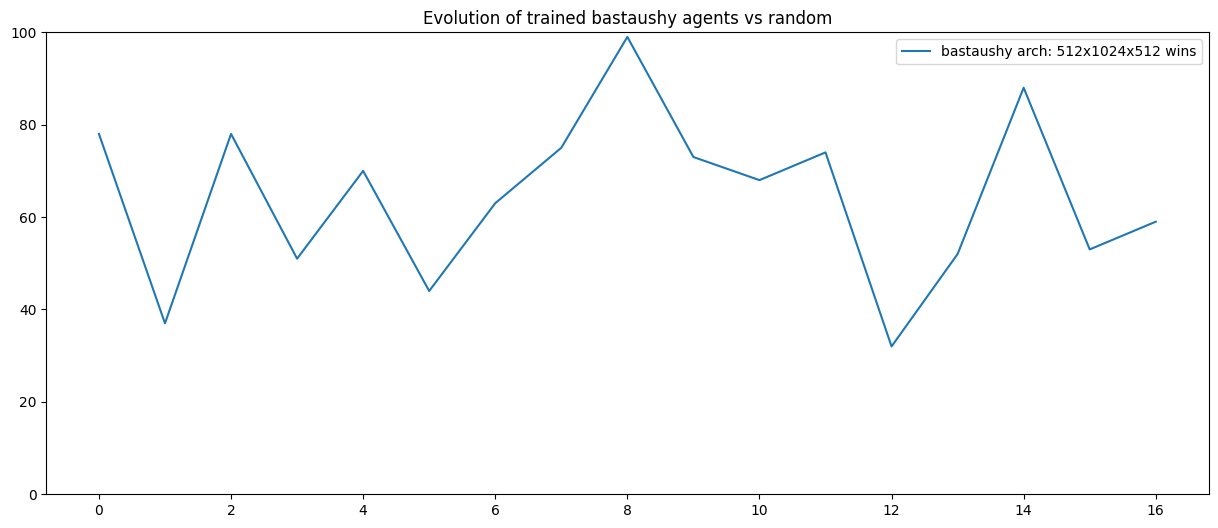

In [100]:
plt.figure(figsize=(15,6))
NUM_MODELS = 15

for arch in NET_ARCHS:
    
    #if arch in :
    
        arch_name = arch2str(arch)

        # cubic_interpolation_model = interp1d(range(len(bastaushy_vs_random_wins[arch_name])), bastaushy_vs_random_wins[arch_name], kind = "cubic", fill_value="extrapolate")
         
        # # Plotting the Graph
        # if arch in selected_archs:
        #     X_= np.linspace(0, NUM_MODELS, NUM_MODELS - 1)
        #     Y_= cubic_interpolation_model(X_)
        # else:
        #     X_= np.linspace(0, 7, 10)
        #     Y_= cubic_interpolation_model(X_)
        plt.plot(range(len(bastaushy_vs_random_wins[arch_name])), bastaushy_vs_random_wins[arch_name], label=f'bastaushy arch: {arch_name} wins')
        
plt.legend()
plt.title("Evolution of trained bastaushy agents vs random")
plt.ylim(0, 100)
plt.show()

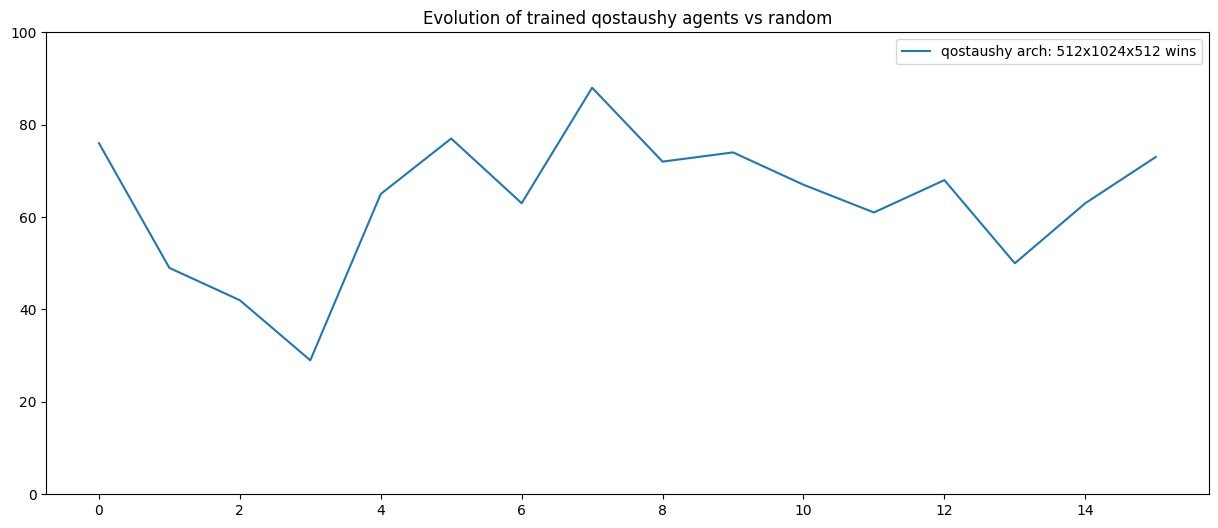

In [104]:
plt.figure(figsize=(15,6))

for arch in NET_ARCHS:
    
        arch_name = arch2str(arch)
        
        # cubic_interpolation_model = interp1d(range(len(qostaushy_vs_random_wins[arch_name])), qostaushy_vs_random_wins[arch_name], kind = "cubic")
         
        # # Plotting the Graph
        # if arch in selected_archs:
        #     X_= np.linspace(0, NUM_MODELS, NUM_MODELS - 1)
        #     Y_= cubic_interpolation_model(X_)
        # else:
        #     X_= np.linspace(0, 7, 10)
        #     Y_= cubic_interpolation_model(X_)
        
        plt.plot(range(len(qostaushy_vs_random_wins[arch_name])), qostaushy_vs_random_wins[arch_name], label=f'qostaushy arch: {arch_name} wins')
        
plt.legend()
plt.title("Evolution of trained qostaushy agents vs random")
plt.ylim(0, 100)
plt.show()

### 🐦 Play all trained policies

In [40]:
bastaushy_wins = {arch2str(key): [] for key in NET_ARCHS}

for arch in NET_ARCHS:
    
    arch_name = arch2str(arch)
    
    for n_agent, agent in tqdm(enumerate(agents_learned_bastaushy[arch_name])):

        PLAYS = {"bastaushy": 0, "qostaushy": 0}
        
        full_opp_qostaushy = []
        
        for arch_loc in NET_ARCHS:
            full_opp_qostaushy += agents_learned_qostaushy[arch2str(arch_loc)] 

        for n_agent_opp, agent_opponent in enumerate(full_opp_qostaushy):
            env = _get_env()

            policies = MultiAgentPolicyManager(policies=[agent, agent_opponent], env=env)
            
            env = DummyVectorEnv([lambda: env])

            collector = Collector(policies, env, exploration_noise=False)

            result = collector.collect(n_episode=1, reset_before_collect=True)
            # rews, lens = result["rews"], result["lens"]
            # print(f"Final reward bastaushy #{n_agent} with acrh {arch_name}: {rews[:, 0].mean()}, length: {lens.mean()}")
            # print(f"Final reward qostaushy #{n_agent_opp}: {rews[:, 1].mean()}, length: {lens.mean()}")

        # print(f"Bastaushy arch {arch_name} #{n_agent} wins {PLAYS["bastaushy"]} times")

        bastaushy_wins[arch_name].append(PLAYS["bastaushy"])

0it [00:00, ?it/s]

In [41]:
bastaushy_wins

{'512x1024x512': [3, 1, 2, 4, 2]}

In [42]:
qostaushy_wins = {arch2str(key): [] for key in NET_ARCHS}

for arch in NET_ARCHS:
    
    arch_name = arch2str(arch)
    
    for n_agent, agent in tqdm(enumerate(agents_learned_qostaushy[arch_name])):

        PLAYS = {"bastaushy": 0, "qostaushy": 0}
        
        full_opp_bastaushy = []
        
        for arch_loc in NET_ARCHS:
            
            full_opp_bastaushy += agents_learned_bastaushy[arch2str(arch_loc)] 
            
        for n_agent_opp, agent_opponent in enumerate(full_opp_bastaushy):

            env = _get_env()

            policies = MultiAgentPolicyManager(policies=[agent_opponent, agent], env=env)
            
            env = DummyVectorEnv([lambda: env])

            collector = Collector(policies, env, exploration_noise=False)

            result = collector.collect(n_episode=1, reset_before_collect=True)

        # print(f"Qostaushy arch {arch_name} #{n_agent} wins {PLAYS["qostaushy"]} times")

        qostaushy_wins[arch_name].append(PLAYS["qostaushy"])

0it [00:00, ?it/s]

In [43]:
qostaushy_wins

{'512x1024x512': [3, 2, 1, 3, 4]}

### 🦑 Save data to files

In [ ]:
for arch in tqdm(NET_ARCHS):
    if arch not in selected_archs:
        for _ in range(9, NUM_MODELS + 1):
            bastaushy_wins[arch_name].append(0)
            qostaushy_wins[arch_name].append(0)

In [36]:
with open("../data/bastaushy_vs_others.csv", "w") as outfile:
    writer = csv.writer(outfile)
    
    writer.writerow(bastaushy_wins.keys())

    writer.writerows(zip(*bastaushy_wins.values()))

In [37]:
with open("../data/qostaushy_vs_others.csv", "w") as outfile:
    writer = csv.writer(outfile)
    
    writer.writerow(qostaushy_wins.keys())

    writer.writerows(zip(*qostaushy_wins.values()))

### 🦚 Read data

In [35]:
df_vs_others_basta = pd.read_csv("../data/bastaushy_vs_others.csv")
df_vs_others_qosta = pd.read_csv("../data/qostaushy_vs_others.csv")

len(df_vs_others_basta['64x128x64'].values)

8

In [36]:
vs_others_basta = df_vs_others_basta.to_dict()

bastaushy_wins = {key: [] for key in vs_others_basta.keys()}

for key in vs_others_basta.keys():
    bastaushy_wins[key] = list(vs_others_basta[key].values())

In [37]:
vs_others_qosta = df_vs_others_qosta.to_dict()

qostaushy_wins = {key: [] for key in vs_others_qosta.keys()}

for key in vs_others_qosta.keys():
    qostaushy_wins[key] = list(vs_others_qosta[key].values())

### 🐈 Plot play results

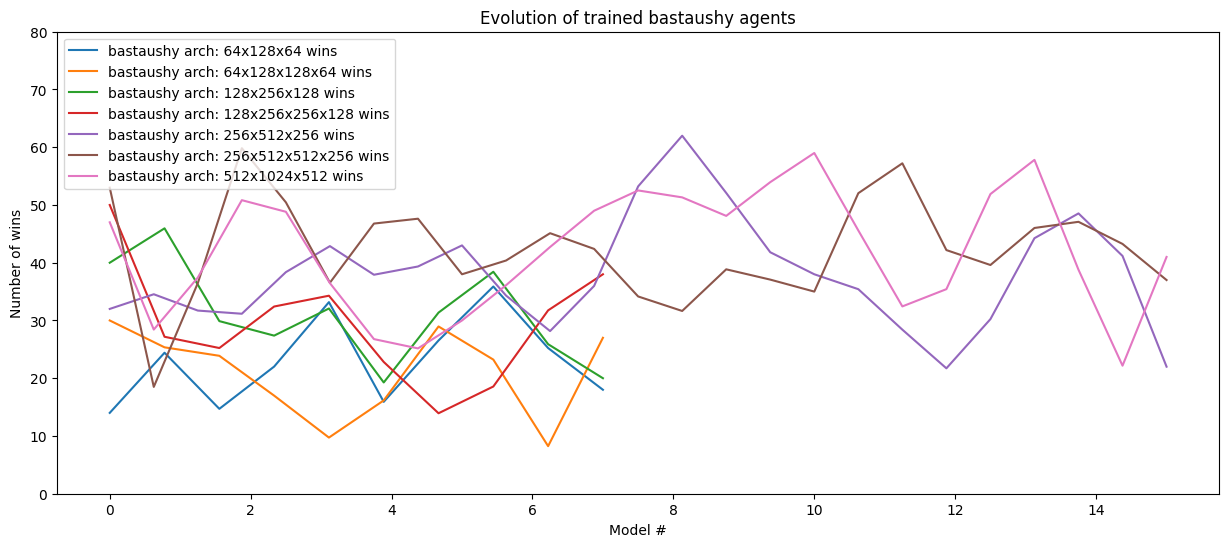

In [66]:
plt.figure(figsize=(15,6))

for arch in NET_ARCHS:

    #if arch in selected_archs:
    
        arch_name = arch2str(arch)
        cubic_interpolation_model = interp1d(range(len(bastaushy_wins[arch_name])), bastaushy_wins[arch_name], kind = "cubic")
         
        # Plotting the Graph
        if arch in selected_archs:
            X_= np.linspace(0, NUM_MODELS, NUM_MODELS + 10)
            Y_= cubic_interpolation_model(X_)
        else:
            X_= np.linspace(0, 7, 10)
            Y_= cubic_interpolation_model(X_)
        plt.plot(X_, Y_, label=f'bastaushy arch: {arch_name} wins')
        #plt.plot(range(len(bastaushy_wins[arch_name])), bastaushy_wins[arch_name], label=f'bastaushy arch: {arch_name} wins')
    
plt.legend()
plt.xlabel("Model #")
plt.ylabel("Number of wins")
plt.ylim(0, 80)
plt.title("Evolution of trained bastaushy agents")
plt.show()

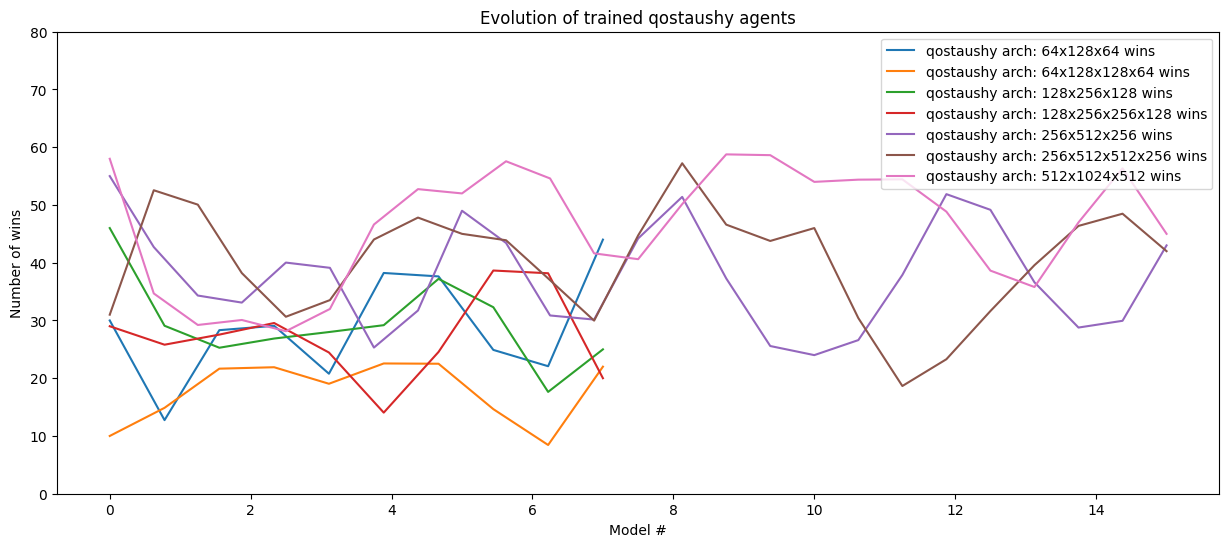

In [67]:
plt.figure(figsize=(15,6))

for arch in NET_ARCHS:
    
    #if arch in selected_archs:
    
        arch_name = arch2str(arch)
        cubic_interpolation_model = interp1d(range(len(qostaushy_wins[arch_name])), qostaushy_wins[arch_name], kind = "cubic")
         
        # Plotting the Graph
        if arch in selected_archs:
            X_= np.linspace(0, NUM_MODELS, NUM_MODELS + 10)
            Y_= cubic_interpolation_model(X_)
        else:
            X_= np.linspace(0, 7, 10)
            Y_= cubic_interpolation_model(X_)
        plt.plot(X_, Y_, label=f'qostaushy arch: {arch_name} wins')
    
plt.legend()
plt.xlabel("Model #")
plt.ylabel("Number of wins")
plt.ylim(0, 80)

plt.title("Evolution of trained qostaushy agents")
plt.show()